# Supervised and Unsupervised FastText Embeddings plus Passive-Aggressive Classifier Pipeline

## Environment Setup

In [1]:
# Imports the required libraries

# Imports the libraries for basic Python functionality
import gc # Garbage collection is important for clearing memory when training the huge fastText models
import os
import re 
# For saving models
import joblib

# Imports the text and data processing packages
import pandas as pd
import numpy as np
from tqdm import tqdm
# For tracking .progress_apply progress
tqdm.pandas() 
import nltk
from nltk.tokenize import word_tokenize

# Imports the extra feature extraction libraries
from nrclex import NRCLex
import spacy
import textstat

# Imports the model training libraries (FastText, PassiveAggressive Classifier, cross-validation  etc.)
import fasttext # Imports FastText
from sklearn.preprocessing import StandardScaler, MinMaxScaler # For scaling extra features/removing outliers
from sklearn.model_selection import KFold # Imports KFold cross-val for FastText hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # Used to tune the PAClassifier C regularization hyperparameter
from sklearn.calibration import CalibratedClassifierCV # Impors the wrapper for PAClassifier to output probabilities
from sklearn.linear_model import PassiveAggressiveClassifier
# Imports the scikit-learn evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Imports the visualization-related libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Sets up the filepath to where all the .csv files containing the engineered feature scores are saved
root_path = "../../FPData/BasicFeatureExtractionDFs/"

####################################################### SETS UP FULL-SCALE DATASET FILEPATHS #############################################

# Sets up WELFake train, validation and test dataset paths
train_path_wf = os.path.join(root_path, "WELFake_train_basic_features.csv")
val_path_wf = os.path.join(root_path, "WELFake_val_basic_features.csv")
test_path_wf = os.path.join(root_path, "WELFake_test_basic_features.csv")
# Constraint
train_path_ct = os.path.join(root_path, "Constraint_train_basic_features.csv")
val_path_ct = os.path.join(root_path, "Constraint_val_basic_features.csv")
test_path_ct = os.path.join(root_path, "Constraint_test_basic_features.csv")
# Fakeddit
train_path_fe = os.path.join(root_path, "Fakeddit_train_basic_features.csv")
val_path_fe = os.path.join(root_path, "Fakeddit_val_basic_features.csv")
test_path_fe = os.path.join(root_path, "Fakeddit_test_basic_features.csv")
# PolitiFact
train_path_pf = os.path.join(root_path, "PolitiFact_train_basic_features.csv")
val_path_pf = os.path.join(root_path, "PolitiFact_val_basic_features.csv")
test_path_pf = os.path.join(root_path, "PolitiFact_test_basic_features.csv")
# GossipCop
train_path_gc = os.path.join(root_path, "GossipCop_train_basic_features.csv")
val_path_gc = os.path.join(root_path, "GossipCop_val_basic_features.csv")
test_path_gc = os.path.join(root_path, "GossipCop_test_basic_features.csv")
# All-Four Combined
train_path_all_four = os.path.join(root_path, "all_four_datasets_train_basic_features.csv")
val_path_all_four = os.path.join(root_path, "all_four_datasets_val_basic_features.csv")
test_path_all_four = os.path.join(root_path, "all_four_datasets_test_basic_features.csv")\

####################################################### SETS UP FIVE-SHOT DATASET FILEPATHS #############################################

# Five-Shot: WELFake target
train_path_five_shot_wf_target = os.path.join(root_path, "Five_Shot_WELFake_Target_basic_features.csv")
# Five-Shot: Constraint target
train_path_five_shot_ct_target = os.path.join(root_path, "Five_Shot_Constraint_Target_basic_features.csv")
# Five-Shot: PolitiFact target
train_path_five_shot_pf_target = os.path.join(root_path, "Five_Shot_PolitiFact_Target_basic_features.csv")
# Five-Shot: GossipCop target
train_path_five_shot_gc_target = os.path.join(root_path, "Five_Shot_GossipCop_Target_basic_features.csv")

####################################################### SETS UP ZERO-SHOT DATASET FILEPATHS #############################################

# Zero-Shot: WELFake target
train_path_zero_shot_wf_target = os.path.join(root_path, "Zero_Shot_WELFake_Target_basic_features.csv")
# Zero-Shot: Constraint target
train_path_zero_shot_ct_target = os.path.join(root_path, "Zero_Shot_Constraint_Target_basic_features.csv")
# Zero-Shot: PolitiFact target
train_path_zero_shot_pf_target = os.path.join(root_path, "Zero_Shot_PolitiFact_Target_basic_features.csv")
# Zero-Shot: GossipCop target
train_path_zero_shot_gc_target = os.path.join(root_path, "Zero_Shot_GossipCop_Target_basic_features.csv")

####################################################### LOADS IN FULL-SCALE DATASETS AS DATAFRAMES #########################################
# WELFake
wf_train_df = pd.read_csv(train_path_wf)
wf_val_df = pd.read_csv(val_path_wf)
wf_test_df = pd.read_csv(test_path_wf)
# Constraint
ct_train_df = pd.read_csv(train_path_ct)
ct_val_df = pd.read_csv(val_path_ct)
ct_test_df = pd.read_csv(test_path_ct)
# Fakeddit
fe_train_df = pd.read_csv(train_path_fe)
fe_val_df = pd.read_csv(val_path_fe)
fe_test_df = pd.read_csv(test_path_fe)
# PolitiFact
pf_train_df = pd.read_csv(train_path_pf)
pf_val_df = pd.read_csv(val_path_pf)
pf_test_df = pd.read_csv(test_path_pf)
# GossipCop
gc_train_df = pd.read_csv(train_path_gc)
gc_val_df = pd.read_csv(val_path_gc)
gc_test_df = pd.read_csv(test_path_gc)

# Reads in the all-four combined dataset
all_four_train_df = pd.read_csv(train_path_all_four)
all_four_val_df = pd.read_csv(val_path_all_four)
all_four_test_df = pd.read_csv(test_path_all_four)


####################################################### LOADS IN FIVE-SHOT DATASETS AS DATAFRAMES #########################################

# Five-Shot: WELFake target training dataset
five_shot_wf_target_train_df = pd.read_csv(train_path_five_shot_wf_target)
# Five-Shot: Constraint target training dataset
five_shot_ct_target_train_df = pd.read_csv(train_path_five_shot_ct_target)
# Five-Shot: PolitiFact target training dataset
five_shot_pf_target_train_df = pd.read_csv(train_path_five_shot_pf_target)
# Five-Shot: GossipCop target training dataset
five_shot_gc_target_train_df = pd.read_csv(train_path_five_shot_gc_target)

####################################################### LOADS IN ZERO-SHOT DATASETS AS DATAFRAMES #########################################

# Zero-Shot: WELFake target training dataset
zero_shot_wf_target_train_df = pd.read_csv(train_path_zero_shot_wf_target)
# Zero-Shot: Constraint target training dataset
zero_shot_ct_target_train_df = pd.read_csv(train_path_zero_shot_ct_target)
# Zero-Shot: PolitiFact target training dataset
zero_shot_pf_target_train_df = pd.read_csv(train_path_zero_shot_pf_target)
# Zero-Shot: GossipCop target training dataset
zero_shot_gc_target_train_df = pd.read_csv(train_path_zero_shot_gc_target)

## Text Pre-Processing

In [3]:
def preprocessTextForFastTextEmbeddingsModel(text):
    """
        A very basic text preprocessing function. It only cleans text from extra whitespace and newlines, as well as lowercasing,
        in preparation for training a FastText model, which cannot handle newlines and trailing spaces.
        Does not remove punctuation as based on feature analysis, this can be an important distinguishing factor for fake news.
        Also does not aggressively normalize (lemmatize/stemming) words as this is handled by the fastText sub-word model.
        
        Input Parameters:
            text (str): the text to clean
        Output:
            text (str): the cleaned text
    """
    # Converts the text to lowercase
    text = text.lower()
   
    # Removes any newlines and extra whitespace (the \s regex matches any whitespace character including tabs/newlines)
    text = re.sub(r"\s+", ' ', text)

    # Strips any remaining trailing whitespace
    text = text.strip()
   
    return text

In [4]:
# WELFake
wf_train_df["clean_text"] = wf_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
wf_val_df["clean_text"] = wf_val_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
wf_test_df["clean_text"] = wf_test_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)




00%|███████████████████████████████████| 11237/11237 [00:02<00:00, 5013.53it/s]

In [5]:
# Verify validation and teest lengths to check if loaded properly
print(len(wf_val_df), len(wf_test_df))

9325 11237


In [6]:
# Fakeddit
fe_train_df["clean_text"] = fe_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
fe_val_df["clean_text"] = fe_val_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
fe_test_df["clean_text"] = fe_test_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)




00%|█████████████████████████████████| 71095/71095 [00:00<00:00, 460781.83it/s]

In [7]:
print(len(fe_val_df), len(fe_test_df)) # Check right val and test sets are loaded

70332 71095


In [4]:
# Constraint
ct_train_df["clean_text"] = ct_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
ct_val_df["clean_text"] = ct_val_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
ct_test_df["clean_text"] = ct_test_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)




00%|███████████████████████████████████| 2122/2122 [00:00<00:00, 182226.63it/s]

In [5]:
print(len(ct_val_df), len(ct_test_df)) # Check right val and test sets are loaded

2128 2122


In [9]:
# PolitiFact
pf_train_df["clean_text"] = pf_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
pf_val_df["clean_text"] = pf_val_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
pf_test_df["clean_text"] = pf_test_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)




00%|███████████████████████████████████████| 126/126 [00:00<00:00, 4406.37it/s]

In [11]:
print(len(pf_val_df), len(pf_test_df)) # Check right val and test sets are loaded

104 126


In [12]:
# GossipCop
gc_train_df["clean_text"] = gc_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
gc_val_df["clean_text"] = gc_val_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
gc_test_df["clean_text"] = gc_test_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)




00%|████████████████████████████████████| 3199/3199 [00:00<00:00, 10292.59it/s]

In [13]:
print(len(gc_val_df), len(gc_test_df)) # Check right val and test sets are loaded

2630 3199


In [5]:
# All-Four Combined
all_four_train_df["clean_text"] = all_four_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
all_four_val_df["clean_text"] = all_four_val_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)
all_four_test_df["clean_text"] = all_four_test_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)




00%|██████████████████████████████████| 16683/16683 [00:00<00:00, 17381.11it/s]

In [6]:
print(len(all_four_val_df), len(all_four_test_df)) # Check right val and test sets are loaded

14187 16683


In [76]:
# Five-Shot: WELFake target
five_shot_wf_target_train_df["clean_text"] = five_shot_wf_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 17857/17857 [00:01<00:00, 16502.81it/s]

In [77]:
# Five-Shot: Constraint target
five_shot_ct_target_train_df["clean_text"] = five_shot_ct_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 53041/53041 [00:04<00:00, 12733.27it/s]

In [22]:
# Five-Shot: PolitiFact target
five_shot_pf_target_train_df["clean_text"] = five_shot_pf_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 58983/58983 [00:03<00:00, 16228.82it/s]

In [22]:
# Five-Shot: GossipCop target
five_shot_gc_target_train_df["clean_text"] = five_shot_gc_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 48377/48377 [00:02<00:00, 17625.72it/s]

In [79]:
# Zero-Shot: WELFake target
zero_shot_wf_target_train_df["clean_text"] = zero_shot_wf_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 17852/17852 [00:01<00:00, 16650.33it/s]

In [80]:
# Zero-Shot: Constraint target
zero_shot_ct_target_train_df["clean_text"] = zero_shot_ct_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 53036/53036 [00:04<00:00, 12729.55it/s]

In [23]:
# Zero-Shot: PolitiFact target
zero_shot_pf_target_train_df["clean_text"] = zero_shot_pf_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 58978/58978 [00:04<00:00, 12969.26it/s]

In [81]:
# Zero-Shot: GossipCop target
zero_shot_gc_target_train_df["clean_text"] = zero_shot_gc_target_train_df["text"].progress_apply(preprocessTextForFastTextEmbeddingsModel)


00%|██████████████████████████████████| 48372/48372 [00:03<00:00, 14962.18it/s]

## Training and Loading the FastText Models

In [5]:
def prepareDataForFastText(df, output_file, text_col_name, label_col_name):
    """
    Converts a training dataset with text and label columns into FastText format for training the model, i.e.
    "__label__ <text>". Reference: https://fasttext.cc/docs/en/supervised-tutorial.html
    "All the labels start by the __label__ prefix, which is how fastText recognize what is a label or what is a word."
        
        Input Parameters:
            df (pd.DataFrame): a training dataset for training a fastText model with a new text and label column
            output_file (str): .txt filename to save the fastText training data to
            text_col_name (str): name of the text column in the training DataFrame
            label_col_name (str): name of the label column in the training DataFrame
        Output File:
            output_file (str): name of the output text fastText format file being created
    """
    # Opens the inputted .txt file to write the lines to
    with open(output_file, 'w') as f:
        
        # Iterates over the texts and labels in the training DataFrame
        for text, label in zip(df[text_col_name], df[label_col_name]):
            
            # Converts the text-label pairs into FastText formatted strings of: __label__<label> <text>
            f.write(f'__label__{label} {text}\n')
            
    return output_file


def trainFastTextModel(
    train_file,
    save_path,
    num_folds=5,
    autotune_duration=300
):
    """
    Trains a FastText model with k-fold cross-validation and autotune, selecting the best model based on F1-score.
    Reference: https://medium.com/data-science/fasttext-for-text-classification-a4b38cbff27c

        Input Parameters:
            train_file (str): the .txt filename containing the FastText-formatted "__label__ <text>" data
            save_path (str): the filepath string to save the best model to (it should end in .bin)
            num_folds (int): the number of folds for K-fold cross-validation. The default value is 5
            autotune_duration (int): the time in seconds for fastText autotune to run per fold, default is 300 seconds = 5 minutes

        Output:
            best_model (fasttext.FastText._FastText): the trained FastText model with the best validation F1-score
    """
    
    # Reads in the dataset saved as a .txt file in "__label__ text" format in
    with open(train_file, 'r') as f:
        data = f.readlines()
    
    # Sets up the k-fold cross-validation using inbuilt KFold from scikit-learn. Uses random_state for reproducibility of results
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=5)
    best_model = None # Keeps track of best model so far
    best_f1 = 0 # Keeps track of best F1-score so far
    
    # Performs the cross-validation: start printing each fold's index from 1 instead of 0 for more intuitive readability
    for fold, (train_idx, val_idx) in enumerate(kf.split(data), 1):

        # Prints progress
        print(f"Training fold {fold}/{num_folds}...")
        
        # Splits the data into training and validation sets based on the indices autogenerated with KFold 
        train_data = [data[i] for i in train_idx]
        val_data = [data[i] for i in val_idx]
        
        # Saves the train and validation sets temporarily as .txt files
        train_file_temp = "temp_train.txt"
        val_file_temp = "temp_val.txt"

        # Opens train temp file
        with open(train_file_temp, 'w') as train_f:
            train_f.writelines(train_data)

        # Opens validation temp file
        with open(val_file_temp, 'w') as val_f:
            val_f.writelines(val_data)
        
        # Trains the FastText model with autotune to optimize the hyperparameters, e.g. embedding dimension
        model = fasttext.train_supervised(
            input=train_file_temp, # Inputs the temporary training data file for this split
            autotuneValidationFile=val_file_temp, # Inputs the temporary validation data file for this split
            autotuneDuration=autotune_duration # Default for each fold is is 5 minutes (300 seconds)
        )
        
        # Extracts the ground truth news (0 = real, 1 = fake) labels from the .txt validation file; splits to get only the "label"
        # part of the line, then removes "__label__" to get the label out
        y_true = [line.split()[0].replace("__label__", '') for line in val_data] 
        
        # Calculates the predictions on the validation set: splits each line on the space, and removes the second part (the news text).
        # Then, .strip() removes trailing whitespace from the text. Next, [0][0] access the first array returned by model.predict to
        # extract only the top predicted label, "replace" removes the "__label__" prefix before the actual label
        y_pred = [model.predict(line.split(' ', 1)[1].strip())[0][0].replace("__label__", '') for line in val_data]

        # Extracts the macro F1-score using the validation set ground truth and predicted labels
        f1 = f1_score(y_true, y_pred, average="macro")

        # Prints the F1-score for this fold
        print(f"Fold {fold}: Validation F1-score = {f1:.4f}")
        
        # Updates the best model and score if and only if this fold is better in terms of F1-score
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
        
        # Clears the memory used by the current model to not crash the kernel, which was often a problem
        del model
        gc.collect()
    
    # Saves the best model to the specified path
    if best_model:
        best_model.save_model(save_path)
        print(f"Best model saved with F1-score {best_f1:.4f} at {save_path}!!!")
        
    # Prints this error message in case something goes wrong
    else: 
        print("Error: The model was not successfully optimized :(")

    # Returns the best FastText model
    return best_model

In [6]:
# Sets up the path where to store the trained models
fasttext_root_path = "../../FPData/FastText/"

In [16]:
# Downloads the pre-trained FastText model for embedding extraction for the five-shot and zero-shot evaluation scenarios
pretrained_model = fasttext.load_model(os.path.join(fasttext_root_path, "cc.en.300.bin"))

In [17]:
## Full-Scale Datasets: uses hyperparameter optimization with fastText auto-tune functionality
 
# WELFake

# Sets up paths for FastText .txt file and the model
wf_text_filepath = os.path.join(fasttext_root_path, "welfake_fasttext_train.txt")
wf_model_filepath = os.path.join(fasttext_root_path, "welfake_fasttext_model.bin")

# Prepares the texts and labels 
prepareDataForFastText(wf_train_df, wf_text_filepath, "clean_text", "label")

# Trains the FastText model
wf_model = trainFastTextModel(wf_text_filepath, wf_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   12 Best score:  0.979427 ETA:   0h 0m 0s
Training again with best arguments
Read 18M words
Number of words:  442816
Number of labels: 2
Progress: 100.0% words/sec/thread: 1761154 lr:  0.000000 avg.loss:  0.010493 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.9797
Training fold 2/5...


Progress: 100.0% Trials:   12 Best score:  0.978465 ETA:   0h 0m 0s
Training again with best arguments
Read 18M words
Number of words:  440456
Number of labels: 2
Progress: 100.0% words/sec/thread: 3352490 lr:  0.000000 avg.loss:  0.034885 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.9784
Training fold 3/5...


Progress: 100.0% Trials:   16 Best score:  0.980871 ETA:   0h 0m 0s
Training again with best arguments
Read 18M words
Number of words:  440915
Number of labels: 2
Progress: 100.0% words/sec/thread: 4592821 lr:  0.000000 avg.loss:  0.028642 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.9804
Training fold 4/5...



Training again with best arguments
Read 18M words9 ETA:   0h 0m 0s
Number of words:  439488
Number of labels: 2
Progress: 100.0% words/sec/thread: 1381048 lr:  0.000000 avg.loss:  0.009428 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.9800
Training fold 5/5...


Progress: 100.0% Trials:   12 Best score:  0.980029 ETA:   0h 0m 0s
Training again with best arguments
Read 18M words
Number of words:  442908
Number of labels: 2
Progress: 100.0% words/sec/thread:  823240 lr:  0.000000 avg.loss:  0.008578 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.9802
Best model saved with F1-score 0.9804 at ../../FPData/FastText/welfake_fasttext_model.bin!!!


In [18]:
# Loads the model back in
wf_model = fasttext.load_model("welfake_fasttext_model.bin")

In [19]:
# Fakeddit

# Sets up paths for FastText .txt file and the model
fe_text_filepath = os.path.join(fasttext_root_path, "fakeddit_fasttext_train.txt")
fe_model_filepath = os.path.join(fasttext_root_path, "fakeddit_fasttext_model.bin")

# Prepares the texts and labels 
prepareDataForFastText(fe_train_df, fe_text_filepath, "clean_text", "label")

# Trains the FastText model
fe_model = trainFastTextModel(fe_text_filepath, fe_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   15 Best score:  0.874082 ETA:   0h 0m 0s
Training again with best arguments
Read 6M words
Number of words:  261141
Number of labels: 2
Progress: 100.0% words/sec/thread:  122859 lr:  0.000000 avg.loss:  0.201908 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.8724
Training fold 2/5...



Training again with best arguments
Read 6M words30 ETA:   0h 0m 0s
Number of words:  260843
Number of labels: 2
Progress: 100.0% words/sec/thread:  185616 lr:  0.000000 avg.loss:  0.230083 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.8730
Training fold 3/5...


Progress: 100.0% Trials:   15 Best score:  0.872661 ETA:   0h 0m 0s
Training again with best arguments
Read 6M words
Number of words:  260611
Number of labels: 2
Progress: 100.0% words/sec/thread:  178979 lr:  0.000000 avg.loss:  0.197012 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.8702
Training fold 4/5...


Progress: 100.0% Trials:   27 Best score:  0.872769 ETA:   0h 0m 0s
Training again with best arguments
Read 6M words
Number of words:  261207
Number of labels: 2
Progress: 100.0% words/sec/thread:  238046 lr:  0.000000 avg.loss:  0.307038 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.8701
Training fold 5/5...


Progress: 100.0% Trials:   14 Best score:  0.875007 ETA:   0h 0m 0s
Training again with best arguments
Read 6M words
Number of words:  261102
Number of labels: 2
Progress: 100.0% words/sec/thread:  109198 lr:  0.000000 avg.loss:  0.195875 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.8729
Best model saved with F1-score 0.8730 at ../../FPData/FastText/fakeddit_fasttext_model.bin!!!


In [20]:
# Loads the model back in
fe_model = fasttext.load_model(os.path.join(fasttext_root_path, "fakeddit_fasttext_model.bin"))

In [7]:
# Constraint

# Sets up paths for FastText .txt file and the model
ct_text_filepath = os.path.join(fasttext_root_path, "constraint_fasttext_train.txt")
ct_model_filepath = os.path.join(fasttext_root_path, "constraint_fasttext_model.bin")

# Prepares the texts and labels 
prepareDataForFastText(ct_train_df, ct_text_filepath, "clean_text", "label")

# Trains the FastText model
ct_model = trainFastTextModel(ct_text_filepath, ct_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   97 Best score:  0.958464 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  23136
Number of labels: 2
Progress: 100.0% words/sec/thread:  219894 lr:  0.000000 avg.loss:  0.004378 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.9582
Training fold 2/5...


Progress: 100.0% Trials:   76 Best score:  0.952157 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  23103
Number of labels: 2
Progress: 100.0% words/sec/thread:   84966 lr:  0.000000 avg.loss:  0.040754 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.9457
Training fold 3/5...


Progress: 100.0% Trials:   76 Best score:  0.960000 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  23181
Number of labels: 2
Progress: 100.0% words/sec/thread:  127542 lr:  0.000000 avg.loss:  0.011951 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.9591
Training fold 4/5...


Progress: 100.0% Trials:   58 Best score:  0.954510 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  23166
Number of labels: 2
Progress: 100.0% words/sec/thread:   52232 lr:  0.000000 avg.loss:  0.010639 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.9537
Training fold 5/5...


Progress: 100.0% Trials:   19 Best score:  0.939608 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  23456
Number of labels: 2
Progress: 100.0% words/sec/thread:    5898 lr:  0.000000 avg.loss:  0.051877 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.9299
Best model saved with F1-score 0.9591 at ../../FPData/FastText/constraint_fasttext_model.bin!!!


In [8]:
# Loads the model back in
ct_model = fasttext.load_model(os.path.join(fasttext_root_path, "constraint_fasttext_model.bin"))

In [10]:
# PolitiFact

# Sets up paths for FastText .txt file and the model
pf_text_filepath = os.path.join(fasttext_root_path, "politifact_fasttext_train.txt")
pf_model_filepath = os.path.join(fasttext_root_path, "politifact_fasttext_model.bin")

# Prepares the texts and labels 
prepareDataForFastText(pf_train_df, pf_text_filepath, "clean_text", "label")

# Trains the FastText model
pf_model = trainFastTextModel(pf_text_filepath, pf_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   67 Best score:  0.875000 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  36080
Number of labels: 2
Progress: 100.0% words/sec/thread:  406185 lr:  0.000000 avg.loss:  0.243080 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.8702
Training fold 2/5...


Progress: 100.0% Trials:  427 Best score:  0.919540 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  37708
Number of labels: 2
Progress: 100.0% words/sec/thread: 1715441 lr:  0.000000 avg.loss:  0.100031 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.9195
Training fold 3/5...


Progress: 100.0% Trials:  363 Best score:  0.873563 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  37359
Number of labels: 2
Progress: 100.0% words/sec/thread: 1353259 lr:  0.000000 avg.loss:  0.300489 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.8616
Training fold 4/5...


Progress: 100.0% Trials:  759 Best score:  0.735632 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  35826
Number of labels: 2
Progress: 100.0% words/sec/thread:  410340 lr:  0.000000 avg.loss:  0.694017 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.4821
Training fold 5/5...


Progress: 100.0% Trials:  500 Best score:  0.931034 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  38043
Number of labels: 2
Progress:  93.5% words/sec/thread: 2066436 lr:  0.312534 avg.loss:  0.076507 ETA:   0h 0m 0s

Fold 5: Validation F1-score = 0.9079
Best model saved with F1-score 0.9195 at ../../FPData/FastText/politifact_fasttext_model.bin!!!


Progress: 100.0% words/sec/thread: 2014712 lr:  0.000000 avg.loss:  0.071192 ETA:   0h 0m 0s


In [11]:
# Loads the model back in
pf_model = fasttext.load_model(os.path.join(fasttext_root_path, "politifact_fasttext_model.bin"))

In [13]:
# GossipCop

# Sets up paths for FastText .txt file and the model
gc_text_filepath = os.path.join(fasttext_root_path, "gossipcop_fasttext_train.txt")
gc_model_filepath = os.path.join(fasttext_root_path, "gossipcop_fasttext_model.bin")

# Prepares the texts and labels 
prepareDataForFastText(gc_train_df, gc_text_filepath, "clean_text", "label")

# Trains the FastText model
gc_model = trainFastTextModel(gc_text_filepath, gc_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   76 Best score:  0.874151 ETA:   0h 0m 0s
Training again with best arguments
Read 5M words
Number of words:  266689
Number of labels: 2
Progress: 100.0% words/sec/thread: 6275272 lr:  0.000000 avg.loss:  0.097772 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.7888
Training fold 2/5...


Progress: 100.0% Trials:   72 Best score:  0.861023 ETA:   0h 0m 0s
Training again with best arguments
Read 5M words
Number of words:  261967
Number of labels: 2
Progress: 100.0% words/sec/thread: 3733028 lr:  0.000000 avg.loss:  0.129200 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.7640
Training fold 3/5...


Progress: 100.0% Trials:   73 Best score:  0.851902 ETA:   0h 0m 0s
Training again with best arguments
Read 5M words
Number of words:  265054
Number of labels: 2
Progress: 100.0% words/sec/thread: 3460474 lr:  0.000000 avg.loss:  0.106342 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.7599
Training fold 4/5...


Progress: 100.0% Trials:   67 Best score:  0.846014 ETA:   0h 0m 0s
Training again with best arguments
Read 5M words
Number of words:  263425
Number of labels: 2
Progress: 100.0% words/sec/thread: 2338606 lr:  0.000000 avg.loss:  0.144635 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.7557
Training fold 5/5...


Progress: 100.0% Trials:   99 Best score:  0.854620 ETA:   0h 0m 0s
Training again with best arguments
Read 5M words
Number of words:  269916
Number of labels: 2
Progress: 100.0% words/sec/thread:  410232 lr:  0.000000 avg.loss:  0.430360 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.7623
Best model saved with F1-score 0.7888 at ../../FPData/FastText/gossipcop_fasttext_model.bin!!!


In [122]:
# Loads the model back in
gc_model = fasttext.load_model(os.path.join(fasttext_root_path, "gossipcop_fasttext_model.bin"))

In [9]:
# All-Four Combined: tune and train FastText model on texts and labels
all_four_text_filepath = os.path.join(fasttext_root_path, "all_four_fasttext_train.txt")
all_four_model_filepath = os.path.join(fasttext_root_path, "all_four_fasttext_model.bin")

# Converts texts and labels into FastText .txt format of "__label__ text" on each of the lines
prepareDataForFastText(all_four_train_df, all_four_text_filepath, "clean_text", "label")

# Trains the model
all_four_model = trainFastTextModel(all_four_text_filepath, all_four_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   11 Best score:  0.932424 ETA:   0h 0m 0s
Training again with best arguments
Read 24M words
Number of words:  613971
Number of labels: 2
Progress: 100.0% words/sec/thread: 4144392 lr:  0.000000 avg.loss:  0.144813 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.9305
Training fold 2/5...


Progress: 100.0% Trials:   11 Best score:  0.931920 ETA:   0h 0m 0s
Training again with best arguments
Read 24M words
Number of words:  614073
Number of labels: 2
Progress: 100.0% words/sec/thread: 4180987 lr:  0.000000 avg.loss:  0.143996 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.9300
Training fold 3/5...


Progress: 100.0% Trials:   11 Best score:  0.932088 ETA:   0h 0m 0s
Training again with best arguments
Read 24M words
Number of words:  614043
Number of labels: 2
Progress: 100.0% words/sec/thread: 4121173 lr:  0.000000 avg.loss:  0.144759 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.9304
Training fold 4/5...


Progress: 100.0% Trials:   11 Best score:  0.935117 ETA:   0h 0m 0s
Training again with best arguments
Read 24M words
Number of words:  615224
Number of labels: 2
Progress: 100.0% words/sec/thread: 4124893 lr:  0.000000 avg.loss:  0.144100 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.9335
Training fold 5/5...


Progress: 100.0% Trials:   11 Best score:  0.932082 ETA:   0h 0m 0s
Training again with best arguments
Read 24M words
Number of words:  614981
Number of labels: 2
Progress: 100.0% words/sec/thread: 4170059 lr:  0.000000 avg.loss:  0.143720 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.9303
Best model saved with F1-score 0.9335 at ../../FPData/FastText/all_four_fasttext_model.bin!!!


In [9]:
# Loads the model back in
all_four_model = fasttext.load_model(os.path.join(fasttext_root_path, "all_four_fasttext_model.bin"))

In [10]:
# Prints out the all-four combined FastText autotuned embedding size
embedding_dim = all_four_model.get_dimension()
print("Embedding size:", embedding_dim)

Embedding size: 72


## Extracting FastText Embeddings from Texts with the Pre-Trained Models

- Use **model.get_sentence_vector(text)** to get the average FastText embedding for the whole news text
- "For a supervised model getSentenceVector will simply average the word vectors for each word in a line of text." - Reference: https://github.com/facebookresearch/fastText/issues/323#issuecomment-353167113

In [17]:
def getFastTextEmbedding(model, text):
    """
    A quick helper function to get a FastText embedding for text

        Input Parameters:
            model (fasttext.FastText._FastText): the pre-trained FastText model appropriate to the specific dataset
            text (str): the news text to convert into an averaged embedding

        Output:
            np nd.array: the averaged FastText vector for the inputted text
    """
    return model.get_sentence_vector(text)

def addEmbeddingsColumnToDataFrameAndSave(df, model, save_path):
    """
    Adds a new FastText embedding column to a DataFrame with a "clean_text" column

        Input Parameters:
            df (pd.DataFrame): the pandas DataFrame for a specific news dataset
            model (fasttext.FastText._FastText): the pre-trained FastText model appropriate to this specific dataset
            save_path (str): filepath where to save the new DataFrame with FastText embeddings to

        Output:
            fasttext_df (pd.DataFrame): the pandas DataFrame for the dataset but now with a "fasttext_embeddings" column
    """

    # Makes a deep copy of the original DataFrame
    fasttext_df = df.copy()

    # Applies the function above to extract FastText embedding for each text using the pre-trained model
    fasttext_df["fasttext_embeddings"] = fasttext_df["clean_text"].progress_apply(lambda text: getFastTextEmbedding(model, text))
    fasttext_df.to_csv(save_path)
    return fasttext_df

In [50]:
# WELFake: extracts average FastText embeddings for each dataset split using the supervised model
wf_train_df = addEmbeddingsColumnToDataFrameAndSave(wf_train_df, wf_model, "../../FPData/FastText/welfake_train_embeds.csv")
wf_val_df = addEmbeddingsColumnToDataFrameAndSave(wf_val_df, wf_model, "../../FPData/FastText/welfake_val_embeds.csv")
wf_test_df = addEmbeddingsColumnToDataFrameAndSave(wf_test_df, wf_model, "../../FPData/FastText/welfake_test_embeds.csv")




00%|██████████████████████████████████| 11237/11237 [00:00<00:00, 16352.15it/s]

In [97]:
# Fakeddit: extracts average FastText embeddings for each dataset split using the supervised model
fe_train_df = addEmbeddingsColumnToDataFrameAndSave(fe_train_df, fe_model, "../../FPData/FastText/fakeddit_train_embeds.csv")
fe_val_df = addEmbeddingsColumnToDataFrameAndSave(fe_val_df, fe_model, "../../FPData/FastText/fakeddit_val_embeds.csv")
fe_test_df = addEmbeddingsColumnToDataFrameAndSave(fe_test_df, fe_model, "../../FPData/FastText/fakeddit_test_embeds.csv")




00%|██████████████████████████████████| 71095/71095 [00:01<00:00, 55078.21it/s]

In [102]:
print(len(fe_train_df), len(fe_val_df), len(fe_test_df))

648076 70332 71095


In [110]:
# Constraint: extracts average FastText embeddings for each dataset split using the supervised model
ct_train_df = addEmbeddingsColumnToDataFrameAndSave(ct_train_df, ct_model, "../../FPData/FastText/constraint_train_embeds.csv")
ct_val_df = addEmbeddingsColumnToDataFrameAndSave(ct_val_df, ct_model, "../../FPData/FastText/constraint_val_embeds.csv")
ct_test_df = addEmbeddingsColumnToDataFrameAndSave(ct_test_df, ct_model, "../../FPData/FastText/constraint_test_embeds.csv")




00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 77479.59it/s]

In [111]:
print(len(ct_train_df), len(ct_val_df), len(ct_test_df))

6376 2128 2122


In [24]:
# PolitiFact: extracts average FastText embeddings for each dataset split using the supervised model
pf_train_df = addEmbeddingsColumnToDataFrameAndSave(pf_train_df, pf_model, "../../FPData/FastText/politifact_train_embeds.csv")
pf_val_df = addEmbeddingsColumnToDataFrameAndSave(pf_val_df, pf_model, "../../FPData/FastText/politifact_val_embeds.csv")
pf_test_df = addEmbeddingsColumnToDataFrameAndSave(pf_test_df, pf_model, "../../FPData/FastText/politifact_test_embeds.csv")




00%|███████████████████████████████████████| 126/126 [00:00<00:00, 1166.94it/s]

In [25]:
print(len(pf_train_df), len(pf_val_df), len(pf_test_df))

436 104 126


In [124]:
# GossipCop: extracts average FastText embeddings for each dataset split using the supervised model
gc_train_df = addEmbeddingsColumnToDataFrameAndSave(gc_train_df, gc_model, "../../FPData/FastText/gossipcop_train_embeds.csv")
gc_val_df = addEmbeddingsColumnToDataFrameAndSave(gc_val_df, gc_model, "../../FPData/FastText/gossipcop_val_embeds.csv")
gc_test_df = addEmbeddingsColumnToDataFrameAndSave(gc_test_df, gc_model, "../../FPData/FastText/gossipcop_test_embeds.csv")




00%|████████████████████████████████████| 3199/3199 [00:00<00:00, 24657.01it/s]

In [126]:
print(len(gc_train_df), len(gc_val_df), len(gc_test_df))

11042 2630 3199


In [12]:
# All-Four Combined: extracts average FastText embeddings for each dataset split using the supervised model
all_four_train_df = addEmbeddingsColumnToDataFrameAndSave(all_four_train_df, all_four_model, "../../FPData/FastText/all_four_train_embeds.csv")
all_four_val_df = addEmbeddingsColumnToDataFrameAndSave(all_four_val_df, all_four_model, "../../FPData/FastText/all_four_val_embeds.csv")
all_four_test_df = addEmbeddingsColumnToDataFrameAndSave(all_four_test_df, all_four_model, "../../FPData/FastText/all_four_test_embeds.csv")




00%|██████████████████████████████████| 16683/16683 [00:01<00:00, 14074.24it/s]

In [40]:
# Five-Shot - WELFake Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
five_shot_wf_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    five_shot_wf_target_train_df,
    pretrained_model, "../../FPData/FastText/five_shot_wf_target_train_embeds.csv")

# Ensures that the WELFake validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the few-shot scenario!
five_shot_wf_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    wf_val_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_wf_target_val_embeds.csv"
)

five_shot_wf_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    wf_test_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_wf_target_test_embeds.csv"
)




00%|███████████████████████████████████| 11237/11237 [00:03<00:00, 2820.42it/s]

In [41]:
gc.collect()

281

In [42]:
# Five-Shot - Constraint Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
five_shot_ct_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    five_shot_ct_target_train_df,
    pretrained_model, "../../FPData/FastText/five_shot_ct_target_train_embeds.csv")

# Ensures that the Constraint validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the few-shot scenario
five_shot_ct_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    ct_val_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_ct_target_val_embeds.csv"
)

five_shot_ct_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    ct_test_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_ct_target_test_embeds.csv"
)




00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 36369.22it/s]

In [29]:
# Five-Shot - PolitiFact Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
five_shot_pf_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    five_shot_pf_target_train_df,
    pretrained_model, "../../FPData/FastText/five_shot_pf_target_train_embeds.csv")

# Ensures that the PolitiFact validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the few-shot scenario
five_shot_pf_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    pf_val_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_pf_target_val_embeds.csv"
)

five_shot_pf_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    pf_test_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_pf_target_test_embeds.csv"
)




00%|████████████████████████████████████████| 126/126 [00:00<00:00, 734.42it/s]

In [46]:
# Five-Shot - GossipCop Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
five_shot_gc_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    five_shot_gc_target_train_df,
    pretrained_model, "../../FPData/FastText/five_shot_gc_target_train_embeds.csv")

# Ensures that the GossipCop validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the few-shot scenario
five_shot_gc_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    gc_val_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_gc_target_val_embeds.csv"
)

five_shot_gc_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    gc_test_df,
    pretrained_model, 
    "../../FPData/FastText/five_shot_gc_target_test_embeds.csv"
)




00%|█████████████████████████████████████| 3199/3199 [00:01<00:00, 2746.79it/s]

In [47]:
gc.collect()

0

In [16]:
# Zero-Shot - WELFake Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
zero_shot_wf_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    zero_shot_wf_target_train_df,
    pretrained_model, "../../FPData/FastText/zero_shot_wf_target_train_embeds.csv")

# Ensures that the WELFake validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the zero-shot scenario
zero_shot_wf_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    wf_val_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_wf_target_val_embeds.csv"
)

zero_shot_wf_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    wf_test_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_wf_target_test_embeds.csv"
)




00%|███████████████████████████████████| 11237/11237 [00:03<00:00, 2956.39it/s]

In [17]:
# Zero-Shot - Constraint Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
zero_shot_ct_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    zero_shot_ct_target_train_df,
    pretrained_model, "../../FPData/FastText/zero_shot_ct_target_train_embeds.csv")

# Ensures that the Constraint validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the zero-shot scenario
zero_shot_ct_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    ct_val_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_ct_target_val_embeds.csv"
)

zero_shot_ct_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    ct_test_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_ct_target_test_embeds.csv"
)




00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 36409.10it/s]

In [30]:
# Zero-Shot - PolitiFact Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
zero_shot_pf_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    zero_shot_pf_target_train_df,
    pretrained_model, "../../FPData/FastText/zero_shot_pf_target_train_embeds.csv")

# Ensures that the PolitiFact validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the zero-shot scenario
zero_shot_pf_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    pf_val_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_pf_target_val_embeds.csv"
)

zero_shot_pf_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    pf_test_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_pf_target_test_embeds.csv"
)




00%|███████████████████████████████████████| 126/126 [00:00<00:00, 1229.79it/s]

In [19]:
# Zero-Shot - GossipCop Target: extracts average FastText embeddings for each dataset split using the pre-trained "cc.en.300.bin" model
zero_shot_gc_target_train_df = addEmbeddingsColumnToDataFrameAndSave(
    zero_shot_gc_target_train_df,
    pretrained_model, "../../FPData/FastText/zero_shot_gc_target_train_embeds.csv")

# Ensures that the GossipCop validation and test sets are also converted into embeddings using the same "cc.en.300.bin" model
# for the zero-shot scenario
zero_shot_gc_target_val_df = addEmbeddingsColumnToDataFrameAndSave(
    gc_val_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_gc_target_val_embeds.csv"
)

zero_shot_gc_target_test_df = addEmbeddingsColumnToDataFrameAndSave(
    gc_test_df,
    pretrained_model, 
    "../../FPData/FastText/zero_shot_gc_target_test_embeds.csv"
)




00%|█████████████████████████████████████| 3199/3199 [00:01<00:00, 2507.75it/s]

## Combining fastText Embeddings with Extra Engineered Features

In [31]:
def combineFeatures(
    df,
    embedding_col="fasttext_embeddings",
    scaler=None,
    use_min_max_scaler=False
):
    """
    This function combines FastText embeddings and engineered features into a single feature matrix,
    ensuring that the engineered features are scaled without dominating the range with extreme
    values.
    
        Input Parameters:
            df (pd.DataFrame): a pandas DataFrame containing the text embeddings column and the extra engineered feature columns
            embedding_col (str): the name of the embeddings column in the DataFrame
            scaler (StandardScaler or MinMaxScaler, optional): a pre-fitted scaler for feature normalization to correct ranges,
                                                               or None if this is the training set (needs to fit the scaler)
            use_min_max_scaler (boolean): determines whether to use the scikit-learn MinMaxScaler instead of StandardScaler
        
        Output:
            X (np.ndarray): the combined feature matrix containing FastText embeddings and scaled extra engineered feats
            current_scaler (scikit-learn StandardScaler or MinMaxScaler): 
                    the fitted scaler (only returned if "scaler" was None, i.e. training data, else returns only the features matrix)
    """
    
    # Stores the extra engineered feature column names for extracting the extra features
    feature_cols = [
        "exclamation_point_frequency", "third_person_pronoun_frequency", 
        "noun_to_verb_ratio", "cardinal_named_entity_frequency",
        "person_named_entity_frequency", "nrc_positive_emotion_score", 
        "nrc_trust_emotion_score", "flesch_kincaid_readability_score",
        "difficult_words_readability_score", "capital_letter_frequency"
    ]
    
    # Processes the FastText embeddings: converts them to NumPy array if not already (if loaded from .csv, they will be a string!)
    # Adds these extracted embeddings to a list of embeddings to construct NumPy feature matrix later!!!
    embeddings_list = []

    # Iterates over the DataFrame with FastText embeddings
    for i in tqdm(range(len(df)), desc="Processing embeddings..."):
        
        # Extracts the embedding from the DataFrame at each index
        embedding = df[embedding_col].iloc[i]
        
        try:
            # Checks if the embedding is already a NuMpy array
            if isinstance(embedding, np.ndarray):
                
                embeddings_list.append(embedding) # Appends it to list of embeddings, don't need to do anything here
                
            else:
                
                # If the embedding is formatted as a string, then this converts it to a NumPy array, by removing
                # the square brackets around it and using the spaces between each float as separators
                embedding = np.fromstring(embedding.strip("[]"), sep=" ")
                embeddings_list.append(embedding) # Appends the NumPy embedding to list of embeddings

        # Could not convert NumPy array to string! Prints an error and continues to the next row in the DataFrame
        except (ValueError, AttributeError) as e: 
            print(f"There was an processing the FastText embedding at index {i}: {e}!!!!")
            continue

    # Stacks the list of NumPy embeddings vertically as rows into a 2D NumPy array
    embeddings_array = np.vstack(embeddings_list)  
    
    # Scales the engineered features using either the pre-fitted scaler (for the validation/test sets) or fits new one (training set)
    current_scaler = scaler

    # If this is the training set: fits a new scaler based on the type specified in the input arguments
    if current_scaler is None: 
        
        # Initializes the specified kind of scaler for training data
        if use_min_max_scaler: 
            current_scaler = MinMaxScaler()
        else:
            current_scaler = StandardScaler()
            
        # Transforms and stores the engineered features for training set
        engineered_features = current_scaler.fit_transform(df[feature_cols]) 
        
    # Validation or test set: uses the pre-fitted scaler to transform the features for consistency with the training set
    else: 
        # Transforms and stores the engineered features for validation/test set
        engineered_features = current_scaler.transform(df[feature_cols])
    
    # For extra security, this checks for overly large values in engineered features and scales them if necessary
    max_abs_value_features = np.max(np.abs(engineered_features)) # Extracts themaximum absolute value from the engineered features
    
    # If the maximum value is more than 1:
    if max_abs_value_features > 1:
        
        # Calculates a scaling factor to multiply all features by so they do not exceed an absolute value greater than 1
        scale_factor = 1 / max_abs_value_features 
        
        # Normalizes the features so largest values will have to lie between -1 and 1
        engineered_features = engineered_features * scale_factor
    
    # Combines the fastText embeddings and supplementary engineered features into a matrix of rows=samples
    X = np.hstack([embeddings_array, engineered_features])
    
    # Returns the combined features and the scaler ONLY if no scaler was provided, i.e. this is train data
    if scaler is None:
        return X, current_scaler
        
    # Returns only the combined features if scaler was provided, meaning this is validation set
    return X

## Training the Passive-Aggressive Classifier Model

In [32]:
def trainPACModel(X_train, y_train):

    """
        Optimizes the C-regularization hyperparameter value using GridSearchCV for a PassiveAggressive classifier
        on a specific training set, and outputs the model trained with the best C-value as well as the
        C-value itself.

        Input Parameters:
            X_train (np nd.array): the 2D features matrix of size num_samples x num_featuers
            y_train (np nd.array or list): the 1D array of corresponding labels for the samples

        Output:
            best_pac (scikit-learn PassiveAggressiveClassifier instance): the trained Passive Aggressive classifier using the optimal 
                        C hyperparameter found
            best_C (float): best value of C, regularization parameter, found using GridSearchCV
    """
    
    # Initializes a classifier
    pac = PassiveAggressiveClassifier(max_iter=1000, random_state=5)

    # Defines a hyperparameter grid for C (most important hyperparameter is the C regularization parameter)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Performs grid search with five-fold cross-validation using macro F1-score, uses all CPU cores
    grid_search = GridSearchCV(pac, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Extracts the best C value out of the grid_search object 
    best_C = grid_search.best_params_['C']
    print(f"The best C value was: {best_C}")

    # Trains the final model using the best C value
    best_pac = PassiveAggressiveClassifier(C=best_C, max_iter=1000, random_state=5) # Use random state for reproducibility
    best_pac.fit(X_train, y_train)

    # Returns the final model and optimal C value
    return best_pac, best_C

In [33]:
# Reusable function for evaluating the classifier;s performance
def classifierEvaluation(y_val, y_pred, dataset_name, average_type="macro", cmap="viridis"):
  """
    Outputs the main metrics when evaluating a model on a validation or test set and displays the heatmap for the confusion matrix
    
    Input Parameters:
      y_val (list): the list or array of ground truth fake news labels (0 = real, 1 = fake)
      y_pred (list): the list or array of predicted labels
      average_type (str): determines whether to use macro or micro evaluation metrics, 
                          macro is better when classes are imbalanced to gauge performance on minority
      cmap (str): the matplotlib colormap for creating the Seaborn-generated heatamp for the confusion matrix
    
    Output:
      dict: a dictionary storing scores for the 4 core evaluation (macro) metrics
  """

  # Calculates the basic metrics' performance scores
  accuracy = accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred, average=average_type)
  recall = recall_score(y_val, y_pred, average=average_type)
  macro_f1 = f1_score(y_val, y_pred, average=average_type)

  # Prints the results
  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision (Macro): {precision:.4f}')
  print(f'Recall (Macro): {recall:.4f}')
  print(f'Macro F1-score: {macro_f1:.4f}')

  # Prints the detailed scikit-learn classification report
  print("\nClassification Report:\n")
  print(classification_report(y_val, y_pred))

  # Generates a confusion matrix object with scikit-learn
  c_matrix = confusion_matrix(y_val, y_pred)

  # Visualizes the confusion matrix using a Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Sets the confusion matrix figure size
  sns.heatmap(c_matrix, annot=True, fmt='d', cmap=cmap, # fmt = 'd' means output integers for the counts
            xticklabels=["real", "fake"], yticklabels=["real", "fake"]) # Maps 0 = real, 1 = fake
  plt.title(f"Confusion Matrix for Fake News Detection: {dataset_name}")
  plt.xlabel("Predicted Class")
  plt.ylabel("Ground Truth")
  plt.show()

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "macro_f1": macro_f1}

## Full-Scale Evaluation Scenarios

### WELFake

#### Standard Scaler




rocessing embeddings...: 100%|███████| 11237/11237 [00:00<00:00, 335593.30it/s]

The best C value was: 0.01
Accuracy: 0.9823
Precision (Macro): 0.9812
Recall (Macro): 0.9825
Macro F1-score: 0.9818

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5463
           1       0.97      0.98      0.98      3862

    accuracy                           0.98      9325
   macro avg       0.98      0.98      0.98      9325
weighted avg       0.98      0.98      0.98      9325



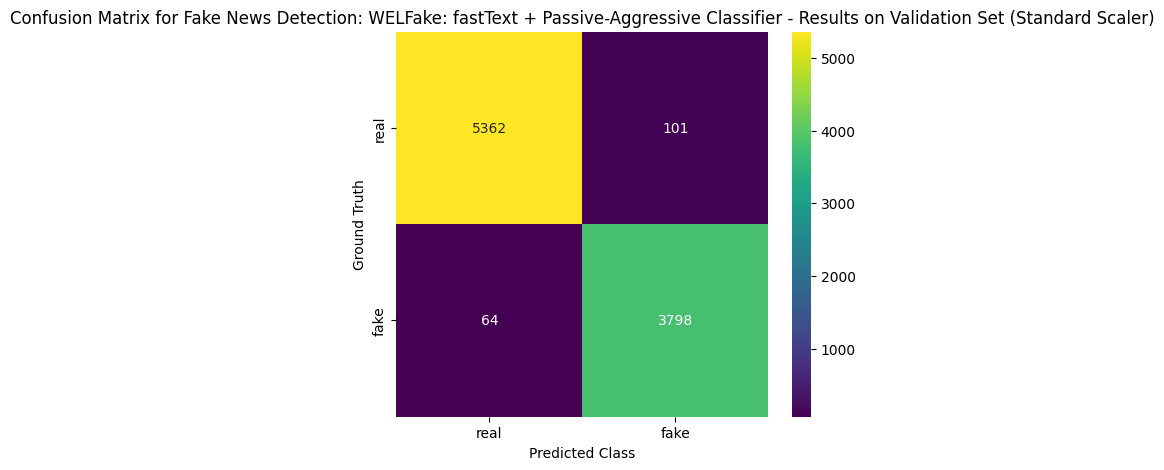

Accuracy: 0.9822
Precision (Macro): 0.9803
Recall (Macro): 0.9820
Macro F1-score: 0.9811

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6976
           1       0.97      0.98      0.98      4261

    accuracy                           0.98     11237
   macro avg       0.98      0.98      0.98     11237
weighted avg       0.98      0.98      0.98     11237



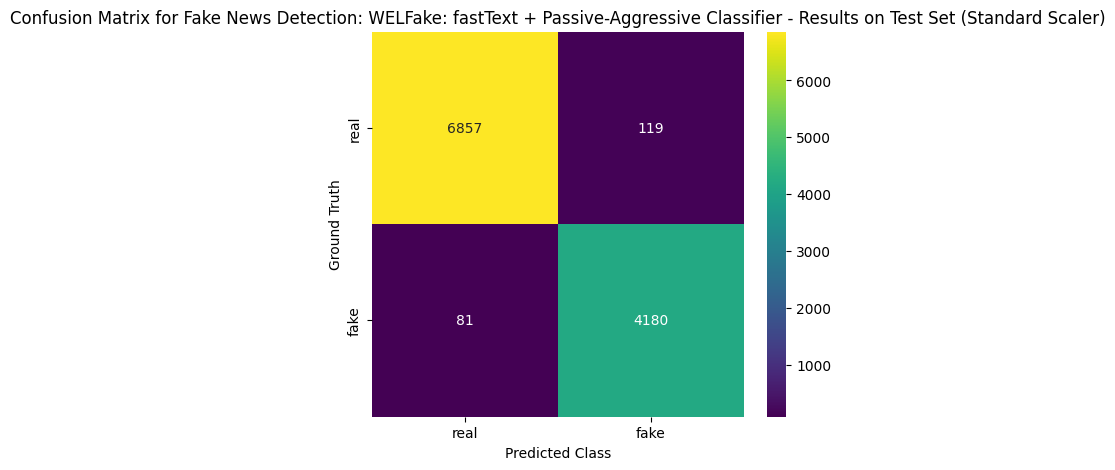

In [54]:
# Processes the full-scale train and validation sets into features matrices and labels using the StandardScaler

# Training data: returns both the features and a fitted StandardScaler
wf_X_train_std, wf_standard_fitted_scaler = combineFeatures(wf_train_df, scaler=None)

# Validation data - uses the pre-fitted standard scaler 
wf_X_val_std = combineFeatures(wf_val_df, scaler=wf_standard_fitted_scaler)
# Test data - uses the pre-fitted standard scaler
wf_X_test_std = combineFeatures(wf_test_df, scaler=wf_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
wf_train_output_file_std = "../../FPData/FastText/wf_X_train_embeddings_std_scaled.npy"
wf_val_output_file_std = "../../FPData/FastText/wf_X_val_embeddings_std_scaled.npy"
wf_test_output_file_std = "../../FPData/FastText/wf_X_test_embeddings_std_scaled.npy"

np.save(wf_train_output_file_std, wf_X_train_std)
np.save(wf_val_output_file_std, wf_X_val_std)
np.save(wf_test_output_file_std, wf_X_test_std)

# Extracts the labels
wf_y_train = wf_train_df["label"].values
wf_y_val = wf_val_df["label"].values
wf_y_test = wf_test_df["label"].values

# Trains the model using the standard scaled data
wf_std_pac_model, wf_std_best_c = trainPACModel(wf_X_train_std, wf_y_train)

# Evaluates the model on validation set
wf_y_val_pred_std = wf_std_pac_model.predict(wf_X_val_std)
wf_std_val_eval_dict = classifierEvaluation(wf_y_val, wf_y_val_pred_std, 
                                            "WELFake: fastText + Passive-Aggressive Classifier - Results on Validation Set (Standard Scaler)")

# Evaluates the model on the test set
wf_y_test_pred_std = wf_std_pac_model.predict(wf_X_test_std)
wf_std_test_eval_dict = classifierEvaluation(wf_y_test, wf_y_test_pred_std, 
                                             "WELFake: fastText + Passive-Aggressive Classifier - Results on Test Set (Standard Scaler)")

#### Min-Max Scaler




rocessing embeddings...: 100%|███████| 11237/11237 [00:00<00:00, 324562.85it/s]

The best C value was: 0.001
Accuracy: 0.9812
Precision (Macro): 0.9796
Recall (Macro): 0.9820
Macro F1-score: 0.9807

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5463
           1       0.97      0.99      0.98      3862

    accuracy                           0.98      9325
   macro avg       0.98      0.98      0.98      9325
weighted avg       0.98      0.98      0.98      9325



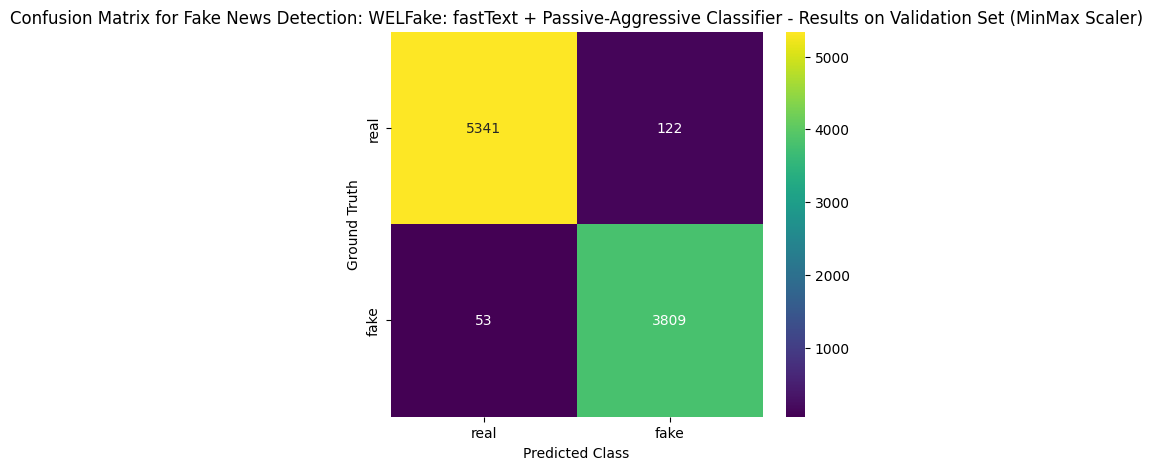

Accuracy: 0.9811
Precision (Macro): 0.9785
Recall (Macro): 0.9817
Macro F1-score: 0.9800

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6976
           1       0.97      0.98      0.98      4261

    accuracy                           0.98     11237
   macro avg       0.98      0.98      0.98     11237
weighted avg       0.98      0.98      0.98     11237



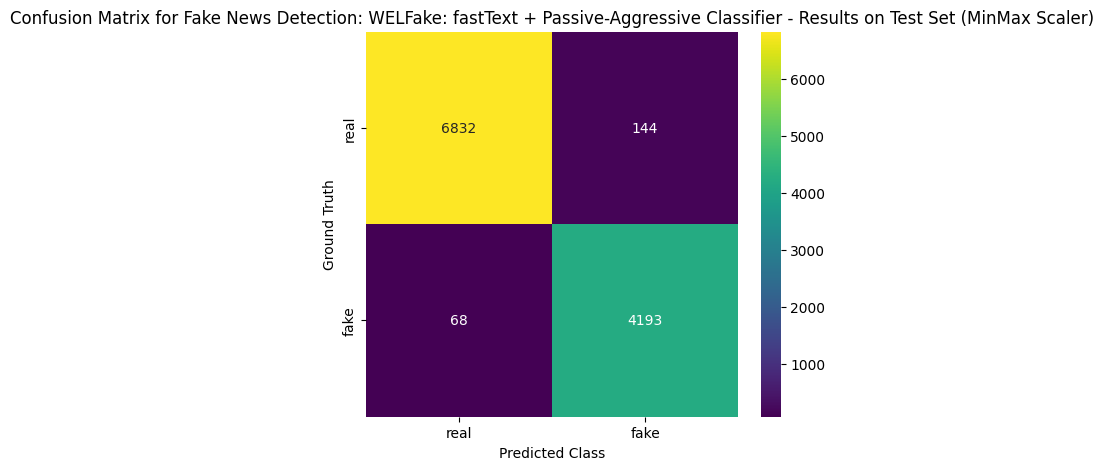

In [70]:
# Processes the full-scale train and validation sets into features matrices and labels using the MinMax scaler

# Training data - returns both the features and a fitted MinMax scaler
wf_X_train_minmax, wf_minmax_fitted_scaler = combineFeatures(wf_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
wf_X_val_minmax = combineFeatures(wf_val_df, scaler=wf_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
wf_X_test_minmax = combineFeatures(wf_test_df, scaler=wf_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
wf_train_output_file_minmax = "../../FPData/FastText/wf_X_train_embeddings_minmax_scaled.npy"
wf_val_output_file_minmax = "../../FPData/FastText/wf_X_val_embeddings_minmax_scaled.npy"
wf_test_output_file_minmax = "../../FPData/FastText/wf_X_test_embeddings_minmax_scaled.npy"

np.save(wf_train_output_file_minmax, wf_X_train_minmax)
np.save(wf_val_output_file_minmax, wf_X_val_minmax)
np.save(wf_test_output_file_minmax, wf_X_test_minmax)

# Trains the model using minmax scaled data
wf_minmax_pac_model, wf_minmax_best_c = trainPACModel(wf_X_train_minmax, wf_y_train)

# Evaluates the model on validation set
wf_y_val_pred_minmax = wf_minmax_pac_model.predict(wf_X_val_minmax)
wf_minmax_val_eval_dict = classifierEvaluation(wf_y_val, wf_y_val_pred_minmax, 
                                            "WELFake: fastText + Passive-Aggressive Classifier - Results on Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on test set
wf_y_test_pred_minmax = wf_minmax_pac_model.predict(wf_X_test_minmax)
wf_minmax_test_eval_dict = classifierEvaluation(wf_y_test, wf_y_test_pred_minmax,
                                             "WELFake: fastText + Passive-Aggressive Classifier - Results on Test Set (MinMax Scaler)"
                                            )

### Fakeddit

#### StandardScaler




rocessing embeddings...: 100%|███████| 71095/71095 [00:00<00:00, 296868.82it/s]

The best C value was: 0.01
Accuracy: 0.8768
Precision (Macro): 0.8754
Recall (Macro): 0.8744
Macro F1-score: 0.8749

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     39299
           1       0.86      0.85      0.86     31033

    accuracy                           0.88     70332
   macro avg       0.88      0.87      0.87     70332
weighted avg       0.88      0.88      0.88     70332



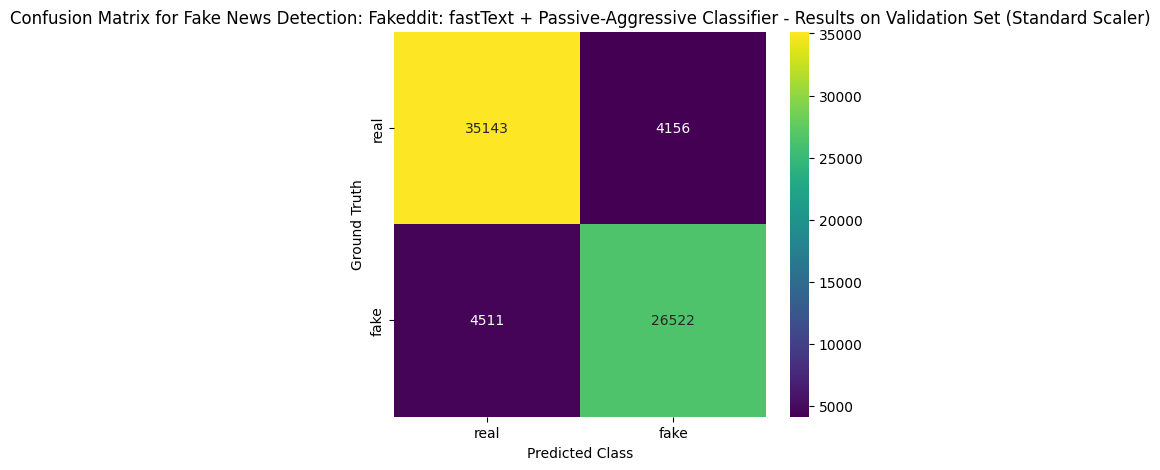

Accuracy: 0.8771
Precision (Macro): 0.8756
Recall (Macro): 0.8746
Macro F1-score: 0.8750

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     39910
           1       0.86      0.85      0.86     31185

    accuracy                           0.88     71095
   macro avg       0.88      0.87      0.88     71095
weighted avg       0.88      0.88      0.88     71095



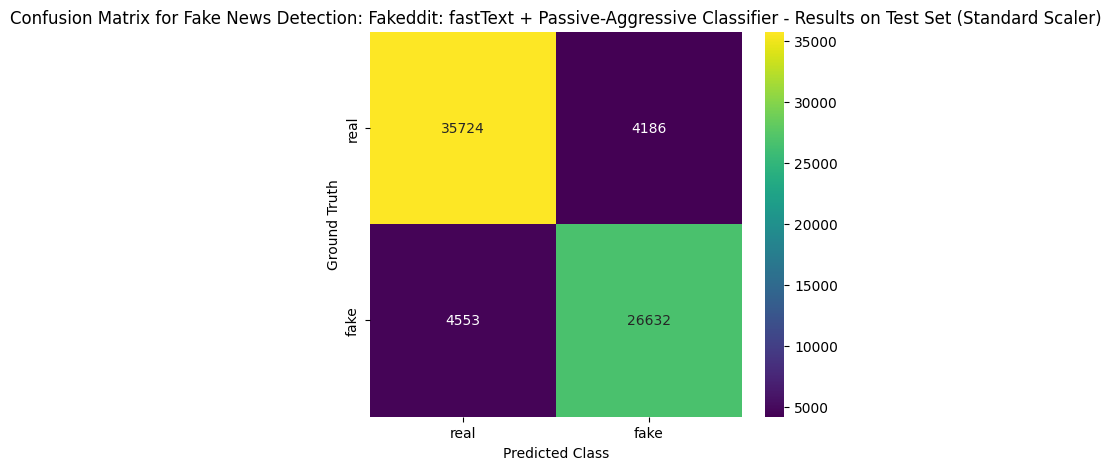

In [103]:
# Training data - returns both the features and a fitted Standard Scaler
fe_X_train_std, fe_standard_fitted_scaler = combineFeatures(fe_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
fe_X_val_std = combineFeatures(fe_val_df, scaler=fe_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
fe_X_test_std = combineFeatures(fe_test_df, scaler=fe_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
fe_train_output_file_std = "../../FPData/FastText/fe_X_train_embeddings_std_scaled.npy"
fe_val_output_file_std = "../../FPData/FastText/fe_X_val_embeddings_std_scaled.npy"
fe_test_output_file_std = "../../FPData/FastText/fe_X_test_embeddings_std_scaled.npy"
np.save(fe_train_output_file_std, fe_X_train_std)
np.save(fe_val_output_file_std, fe_X_val_std)
np.save(fe_test_output_file_std, fe_X_test_std)

# Gets the labels
fe_y_train = fe_train_df["label"].values
fe_y_val = fe_val_df["label"].values
fe_y_test = fe_test_df["label"].values

# Trains the model using standard scaled data
fe_std_pac_model, fe_std_best_c = trainPACModel(fe_X_train_std, fe_y_train)

# Evaluates the model on the validation set
fe_y_val_pred_std = fe_std_pac_model.predict(fe_X_val_std)
fe_std_val_eval_dict = classifierEvaluation(fe_y_val, fe_y_val_pred_std, 
                                            "Fakeddit: fastText + Passive-Aggressive Classifier - Results on Validation Set (Standard Scaler)")

# Evaluates the model on the test set
fe_y_test_pred_std = fe_std_pac_model.predict(fe_X_test_std)
fe_std_test_eval_dict = classifierEvaluation(fe_y_test, fe_y_test_pred_std, 
                                             "Fakeddit: fastText + Passive-Aggressive Classifier - Results on Test Set (Standard Scaler)")

#### Min-Max Scaler




rocessing embeddings...: 100%|███████| 71095/71095 [00:00<00:00, 283571.40it/s]

The best C value was: 0.01
Accuracy: 0.8764
Precision (Macro): 0.8750
Recall (Macro): 0.8742
Macro F1-score: 0.8746

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     39299
           1       0.86      0.86      0.86     31033

    accuracy                           0.88     70332
   macro avg       0.87      0.87      0.87     70332
weighted avg       0.88      0.88      0.88     70332



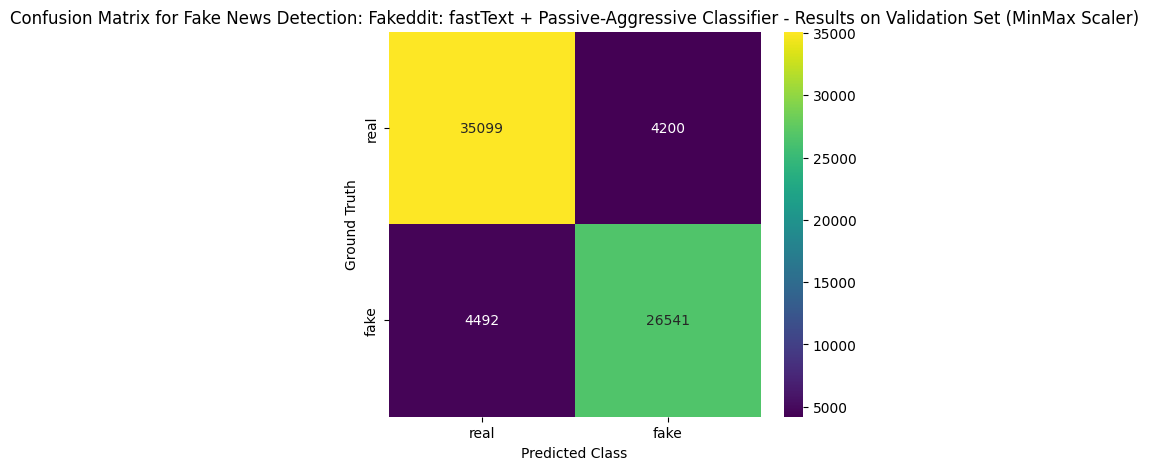

Accuracy: 0.8769
Precision (Macro): 0.8753
Recall (Macro): 0.8745
Macro F1-score: 0.8749

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     39910
           1       0.86      0.86      0.86     31185

    accuracy                           0.88     71095
   macro avg       0.88      0.87      0.87     71095
weighted avg       0.88      0.88      0.88     71095



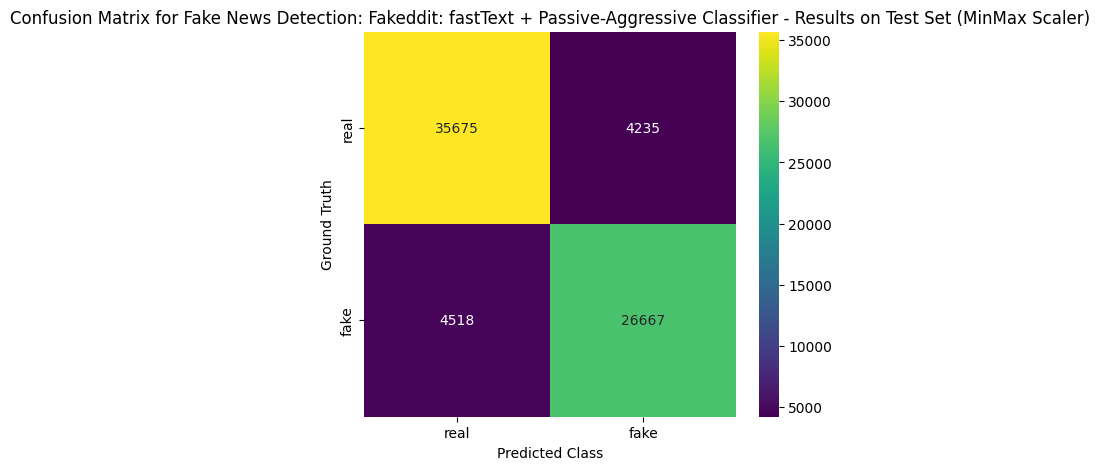

In [104]:
# Training data - returns both the features and a fitted MinMax scaler
fe_X_train_minmax, fe_minmax_fitted_scaler = combineFeatures(fe_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
fe_X_val_minmax = combineFeatures(fe_val_df, scaler=fe_minmax_fitted_scaler)
# Test data - uses the fitted minmax scaler
fe_X_test_minmax = combineFeatures(fe_test_df, scaler=fe_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
fe_train_output_file_minmax = "../../FPData/FastText/fe_X_train_embeddings_minmax_scaled.npy"
fe_val_output_file_minmax = "../../FPData/FastText/fe_X_val_embeddings_minmax_scaled.npy"
fe_test_output_file_minmax = "../../FPData/FastText/fe_X_test_embeddings_minmax_scaled.npy"
np.save(fe_train_output_file_minmax, fe_X_train_minmax)
np.save(fe_val_output_file_minmax, fe_X_val_minmax)
np.save(fe_test_output_file_minmax, fe_X_test_minmax)

# Trains the model using minmax scaled data
fe_minmax_pac_model, fe_minmax_best_c = trainPACModel(fe_X_train_minmax, fe_y_train)

# Evaluates the model on the validation set
fe_y_val_pred_minmax = fe_minmax_pac_model.predict(fe_X_val_minmax)
fe_minmax_val_eval_dict = classifierEvaluation(fe_y_val, fe_y_val_pred_minmax, 
                                            "Fakeddit: fastText + Passive-Aggressive Classifier - Results on Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
fe_y_test_pred_minmax = fe_minmax_pac_model.predict(fe_X_test_minmax)
fe_minmax_test_eval_dict = classifierEvaluation(fe_y_test, fe_y_test_pred_minmax,
                                             "Fakeddit: fastText + Passive-Aggressive Classifier - Results on Test Set (MinMax Scaler)"
                                            )

### Constraint

#### StandardScaler




rocessing embeddings...: 100%|█████████| 2122/2122 [00:00<00:00, 266492.40it/s]

The best C value was: 0.01
Accuracy: 0.9441
Precision (Macro): 0.9443
Recall (Macro): 0.9436
Macro F1-score: 0.9439

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1116
           1       0.95      0.93      0.94      1012

    accuracy                           0.94      2128
   macro avg       0.94      0.94      0.94      2128
weighted avg       0.94      0.94      0.94      2128



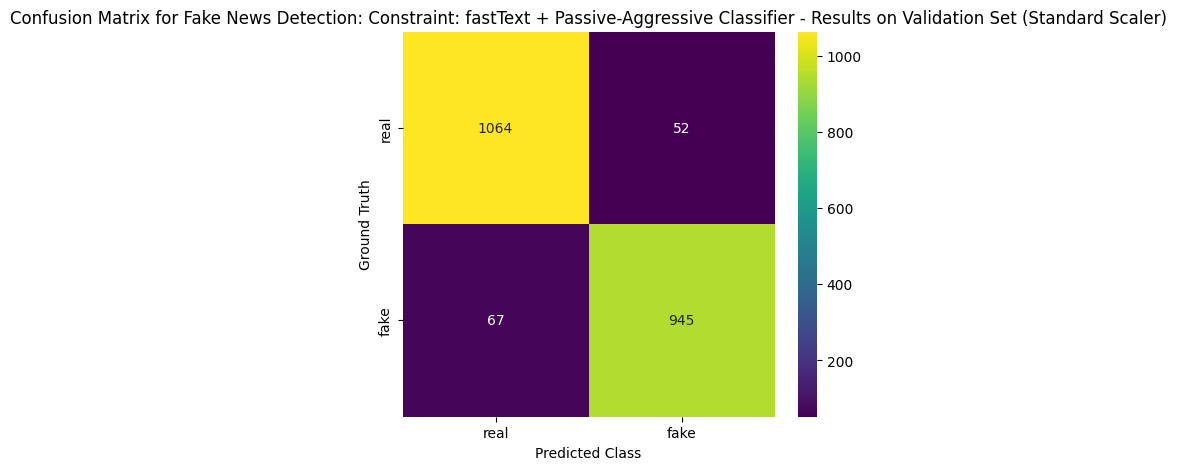

Accuracy: 0.9430
Precision (Macro): 0.9431
Recall (Macro): 0.9425
Macro F1-score: 0.9428

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1115
           1       0.95      0.93      0.94      1007

    accuracy                           0.94      2122
   macro avg       0.94      0.94      0.94      2122
weighted avg       0.94      0.94      0.94      2122



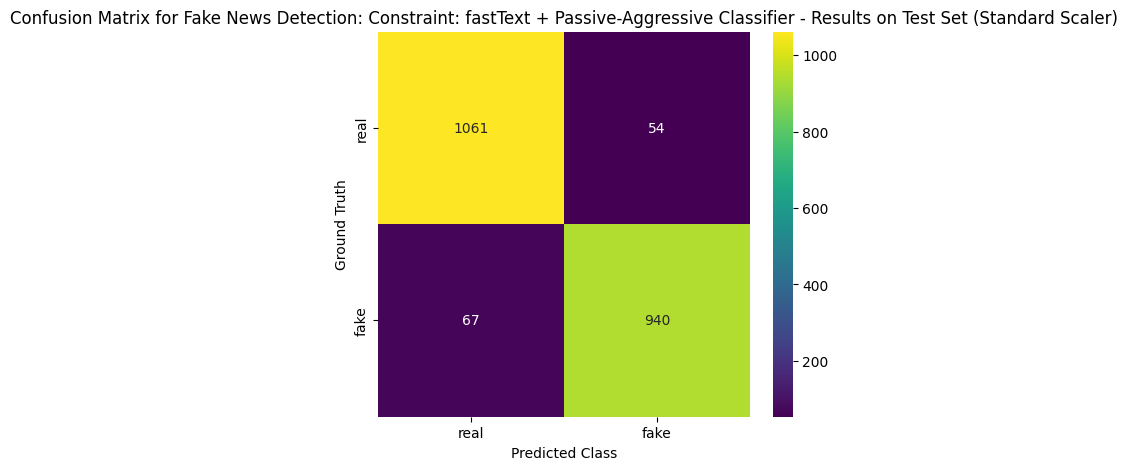

In [117]:
# Training data - returns both the features and a fitted StandardScaler
ct_X_train_std, ct_standard_fitted_scaler = combineFeatures(ct_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
ct_X_val_std = combineFeatures(ct_val_df, scaler=ct_standard_fitted_scaler)
# Test data - uses the fitted standard scaler
ct_X_test_std = combineFeatures(ct_test_df, scaler=ct_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
ct_train_output_file_std = "../../FPData/FastText/ct_X_train_embeddings_std_scaled.npy"
ct_val_output_file_std = "../../FPData/FastText/ct_X_val_embeddings_std_scaled.npy"
ct_test_output_file_std = "../../FPData/FastText/ct_X_test_embeddings_std_scaled.npy"
np.save(ct_train_output_file_std, ct_X_train_std)
np.save(ct_val_output_file_std, ct_X_val_std)
np.save(ct_test_output_file_std, ct_X_test_std)

# Gets the labels
ct_y_train = ct_train_df["label"].values
ct_y_val = ct_val_df["label"].values
ct_y_test = ct_test_df["label"].values

# Trains the model using the standard scaled data
ct_std_pac_model, ct_std_best_c = trainPACModel(ct_X_train_std, ct_y_train)

# Evaluates the model on the validation set
ct_y_val_pred_std = ct_std_pac_model.predict(ct_X_val_std)
ct_std_val_eval_dict = classifierEvaluation(ct_y_val, ct_y_val_pred_std, 
                                            "Constraint: fastText + Passive-Aggressive Classifier - Results on Validation Set (Standard Scaler)")

# Evaluates the model on the test set
ct_y_test_pred_std = ct_std_pac_model.predict(ct_X_test_std)
ct_std_test_eval_dict = classifierEvaluation(ct_y_test, ct_y_test_pred_std, 
                                             "Constraint: fastText + Passive-Aggressive Classifier - Results on Test Set (Standard Scaler)")


#### Min-Max Scaler




rocessing embeddings...: 100%|█████████| 2122/2122 [00:00<00:00, 256374.96it/s]

The best C value was: 0.1
Accuracy: 0.9436
Precision (Macro): 0.9441
Recall (Macro): 0.9430
Macro F1-score: 0.9434

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1116
           1       0.95      0.93      0.94      1012

    accuracy                           0.94      2128
   macro avg       0.94      0.94      0.94      2128
weighted avg       0.94      0.94      0.94      2128



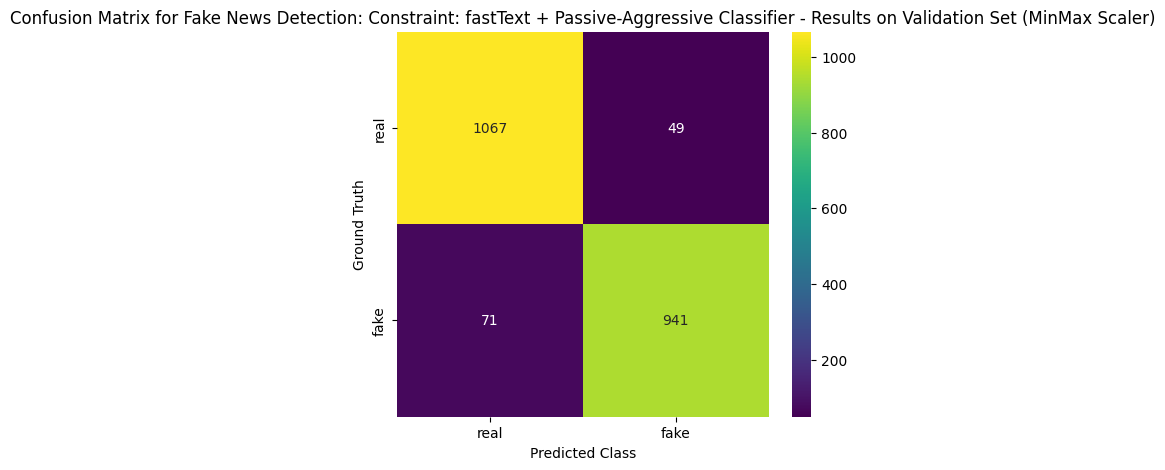

Accuracy: 0.9439
Precision (Macro): 0.9441
Recall (Macro): 0.9434
Macro F1-score: 0.9437

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1115
           1       0.95      0.93      0.94      1007

    accuracy                           0.94      2122
   macro avg       0.94      0.94      0.94      2122
weighted avg       0.94      0.94      0.94      2122



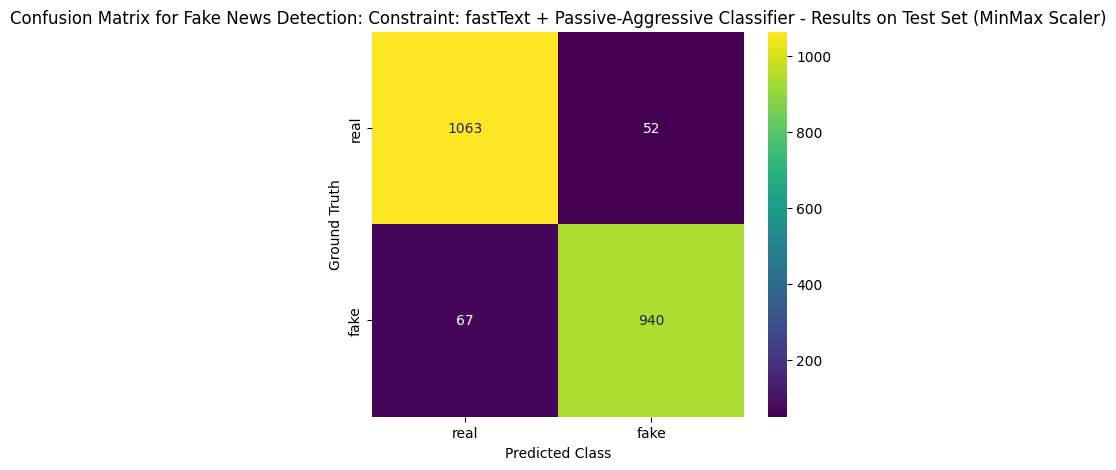

In [118]:
# Training data: returns both the features and a fitted MinMax scaler
ct_X_train_minmax, ct_minmax_fitted_scaler = combineFeatures(ct_train_df, scaler=None, use_min_max_scaler=True) 

# Validation data - uses the fitted minmax scaler 
ct_X_val_minmax = combineFeatures(ct_val_df, scaler=ct_minmax_fitted_scaler)
# Test data - uses the fitted minmax scaler
ct_X_test_minmax = combineFeatures(ct_test_df, scaler=ct_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
ct_train_output_file_minmax = "../../FPData/FastText/ct_X_train_embeddings_minmax_scaled.npy"
ct_val_output_file_minmax = "../../FPData/FastText/ct_X_val_embeddings_minmax_scaled.npy"
ct_test_output_file_minmax = "../../FPData/FastText/ct_X_test_embeddings_minmax_scaled.npy"
np.save(ct_train_output_file_minmax, ct_X_train_minmax)
np.save(ct_val_output_file_minmax, ct_X_val_minmax)
np.save(ct_test_output_file_minmax, ct_X_test_minmax)

# Trains the model using the minmax scaled data
ct_minmax_pac_model, ct_minmax_best_c = trainPACModel(ct_X_train_minmax, ct_y_train)

# Evaluates the model on the validation set
ct_y_val_pred_minmax = ct_minmax_pac_model.predict(ct_X_val_minmax)
ct_minmax_val_eval_dict = classifierEvaluation(ct_y_val, ct_y_val_pred_minmax, 
                                            "Constraint: fastText + Passive-Aggressive Classifier - Results on Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
ct_y_test_pred_minmax = ct_minmax_pac_model.predict(ct_X_test_minmax)
ct_minmax_test_eval_dict = classifierEvaluation(ct_y_test, ct_y_test_pred_minmax,
                                             "Constraint: fastText + Passive-Aggressive Classifier - Results on Test Set (MinMax Scaler)"
                                            )


### PolitiFact

#### StandardScaler




rocessing embeddings...: 100%|███████████| 126/126 [00:00<00:00, 191201.99it/s]

The best C value was: 0.1
Accuracy: 0.8846
Precision (Macro): 0.8817
Recall (Macro): 0.8851
Macro F1-score: 0.8831

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        59
           1       0.85      0.89      0.87        45

    accuracy                           0.88       104
   macro avg       0.88      0.89      0.88       104
weighted avg       0.89      0.88      0.88       104



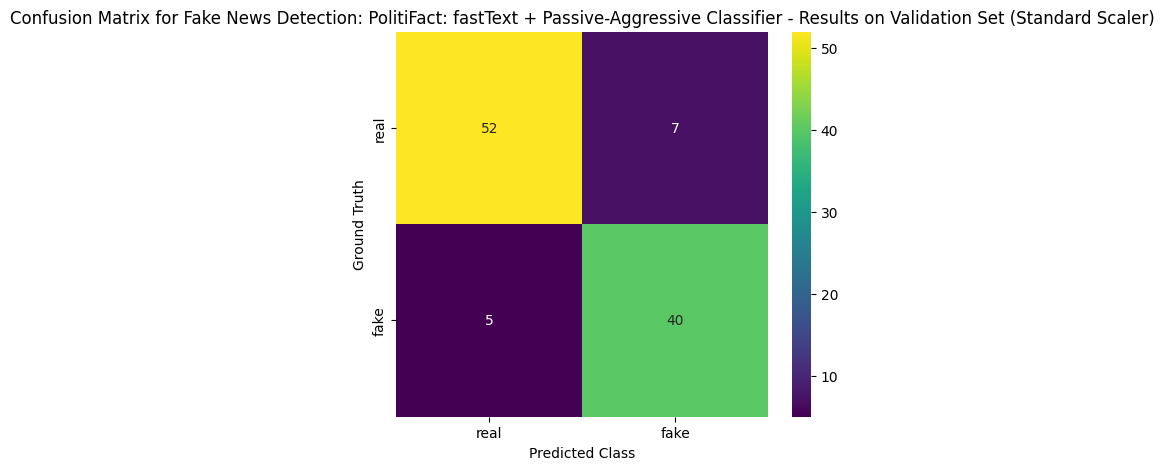

Accuracy: 0.8968
Precision (Macro): 0.9006
Recall (Macro): 0.8985
Macro F1-score: 0.8968

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        61
           1       0.95      0.85      0.89        65

    accuracy                           0.90       126
   macro avg       0.90      0.90      0.90       126
weighted avg       0.90      0.90      0.90       126



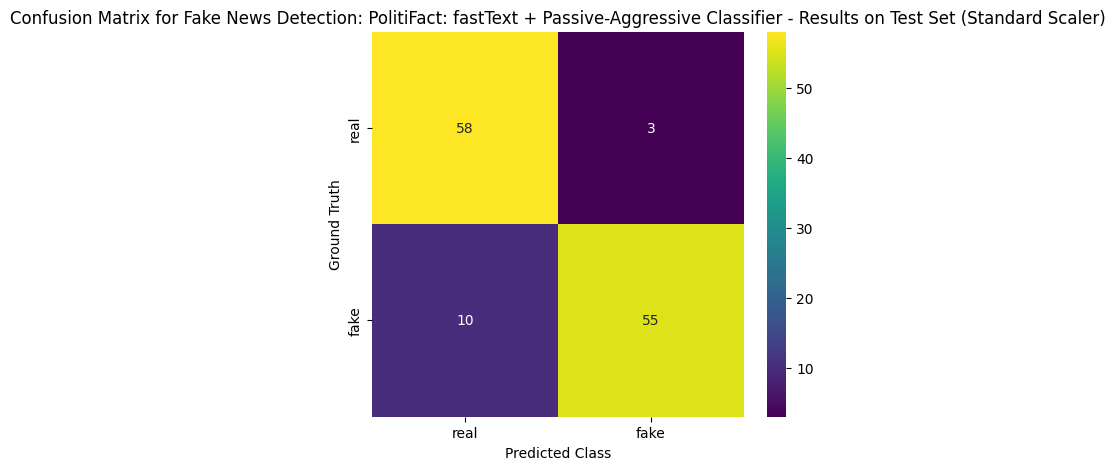

In [119]:
# Training data - returns both the features and a fitted Standard Scaler
pf_X_train_std, pf_standard_fitted_scaler = combineFeatures(pf_train_df, scaler=None) 

# Validation data - uses the fitted standard scaler 
pf_X_val_std = combineFeatures(pf_val_df, scaler=pf_standard_fitted_scaler) 

# Test data - uses the fitted standard scaler
pf_X_test_std = combineFeatures(pf_test_df, scaler=pf_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
pf_train_output_file_std = "../../FPData/FastText/pf_X_train_embeddings_std_scaled.npy"
pf_val_output_file_std = "../../FPData/FastText/pf_X_val_embeddings_std_scaled.npy"
pf_test_output_file_std = "../../FPData/FastText/pf_X_test_embeddings_std_scaled.npy"
np.save(pf_train_output_file_std, pf_X_train_std)
np.save(pf_val_output_file_std, pf_X_val_std)
np.save(pf_test_output_file_std, pf_X_test_std)

# Gets the labels
pf_y_train = pf_train_df["label"].values
pf_y_val = pf_val_df["label"].values
pf_y_test = pf_test_df["label"].values

# Trains the model using standard scaled data
pf_std_pac_model, pf_std_best_c = trainPACModel(pf_X_train_std, pf_y_train)

# Evaluates the model on the validation set
pf_y_val_pred_std = pf_std_pac_model.predict(pf_X_val_std)
pf_std_val_eval_dict = classifierEvaluation(pf_y_val, pf_y_val_pred_std, 
                                            "PolitiFact: fastText + Passive-Aggressive Classifier - Results on Validation Set (Standard Scaler)")

# Evaluates the model on the test set
pf_y_test_pred_std = pf_std_pac_model.predict(pf_X_test_std)
pf_std_test_eval_dict = classifierEvaluation(pf_y_test, pf_y_test_pred_std, 
                                             "PolitiFact: fastText + Passive-Aggressive Classifier - Results on Test Set (Standard Scaler)")


#### Min-Max Scaler



Processing embeddings...: 100%|████████████| 126/126 [00:00<00:00, 43708.73it/s]

The best C value was: 0.1
Accuracy: 0.8942
Precision (Macro): 0.8974
Recall (Macro): 0.9041
Macro F1-score: 0.8940

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.83      0.90        59
           1       0.81      0.98      0.89        45

    accuracy                           0.89       104
   macro avg       0.90      0.90      0.89       104
weighted avg       0.91      0.89      0.89       104



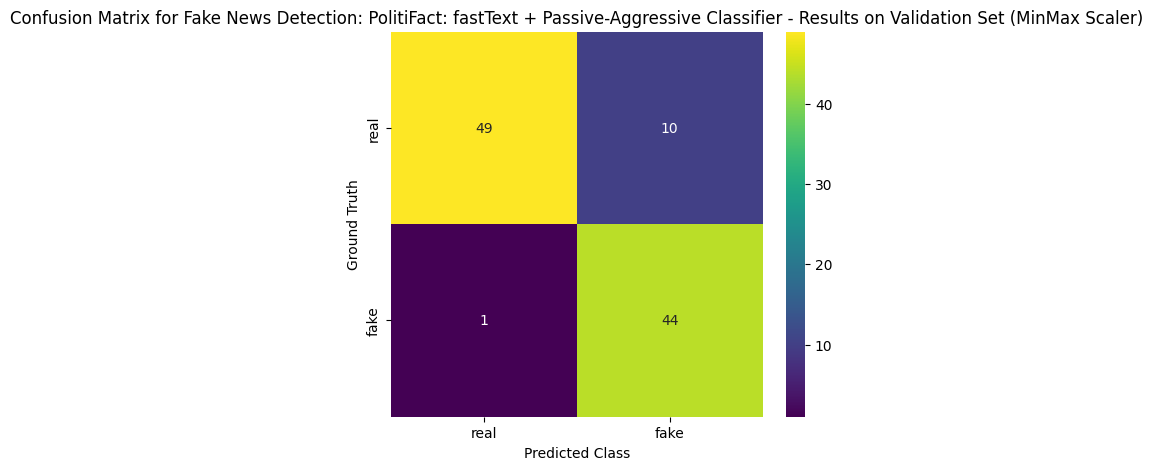

Accuracy: 0.8889
Precision (Macro): 0.8915
Recall (Macro): 0.8903
Macro F1-score: 0.8889

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        61
           1       0.93      0.85      0.89        65

    accuracy                           0.89       126
   macro avg       0.89      0.89      0.89       126
weighted avg       0.89      0.89      0.89       126



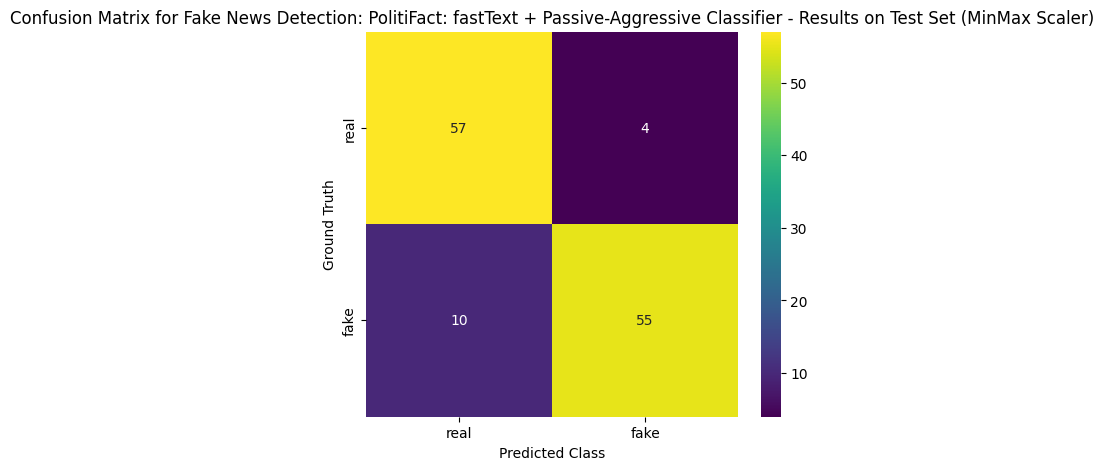

In [120]:
# Training data - returns both the features and a fitted MinMax scaler
pf_X_train_minmax, pf_minmax_fitted_scaler = combineFeatures(pf_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
pf_X_val_minmax = combineFeatures(pf_val_df, scaler=pf_minmax_fitted_scaler) 
# Test data - uses the fitted minmax scaler
pf_X_test_minmax = combineFeatures(pf_test_df, scaler=pf_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
pf_train_output_file_minmax = "../../FPData/FastText/pf_X_train_embeddings_minmax_scaled.npy"
pf_val_output_file_minmax = "../../FPData/FastText/pf_X_val_embeddings_minmax_scaled.npy"
pf_test_output_file_minmax = "../../FPData/FastText/pf_X_test_embeddings_minmax_scaled.npy"
np.save(pf_train_output_file_minmax, pf_X_train_minmax)
np.save(pf_val_output_file_minmax, pf_X_val_minmax)
np.save(pf_test_output_file_minmax, pf_X_test_minmax)

# Trains the model using minmax scaled data
pf_minmax_pac_model, pf_minmax_best_c = trainPACModel(pf_X_train_minmax, pf_y_train)

# Evaluates the model on the validation set
pf_y_val_pred_minmax = pf_minmax_pac_model.predict(pf_X_val_minmax)
pf_minmax_val_eval_dict = classifierEvaluation(pf_y_val, pf_y_val_pred_minmax, 
                                            "PolitiFact: fastText + Passive-Aggressive Classifier - Results on Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
pf_y_test_pred_minmax = pf_minmax_pac_model.predict(pf_X_test_minmax)
pf_minmax_test_eval_dict = classifierEvaluation(pf_y_test, pf_y_test_pred_minmax,
                                             "PolitiFact: fastText + Passive-Aggressive Classifier - Results on Test Set (MinMax Scaler)"
                                            )


### GossipCop

#### StandardScaler




rocessing embeddings...: 100%|█████████| 3199/3199 [00:00<00:00, 325266.74it/s]

The best C value was: 0.01
Accuracy: 0.8494
Precision (Macro): 0.8103
Recall (Macro): 0.7368
Macro F1-score: 0.7627

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2018
           1       0.75      0.53      0.62       612

    accuracy                           0.85      2630
   macro avg       0.81      0.74      0.76      2630
weighted avg       0.84      0.85      0.84      2630



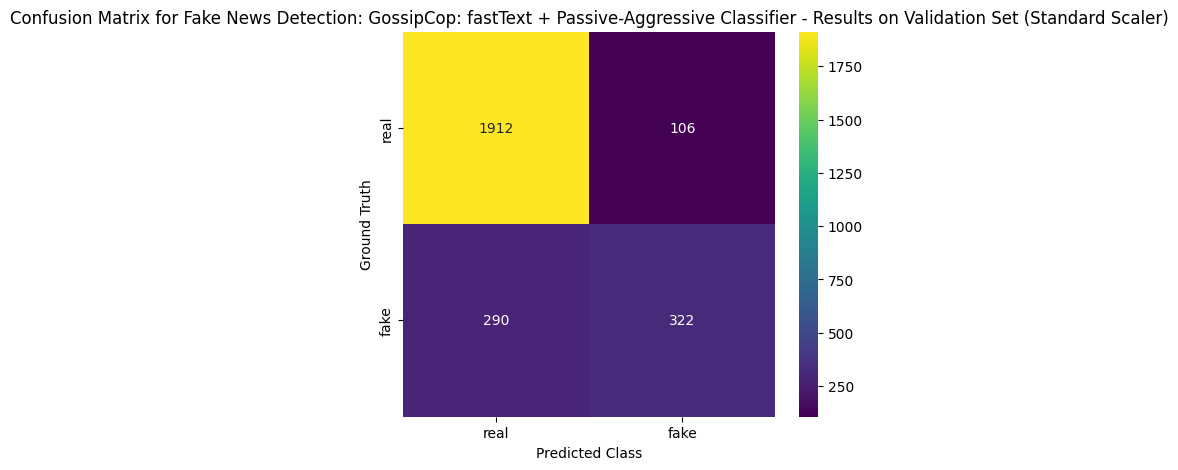

Accuracy: 0.8443
Precision (Macro): 0.8018
Recall (Macro): 0.7352
Macro F1-score: 0.7591

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2444
           1       0.74      0.53      0.62       755

    accuracy                           0.84      3199
   macro avg       0.80      0.74      0.76      3199
weighted avg       0.84      0.84      0.83      3199



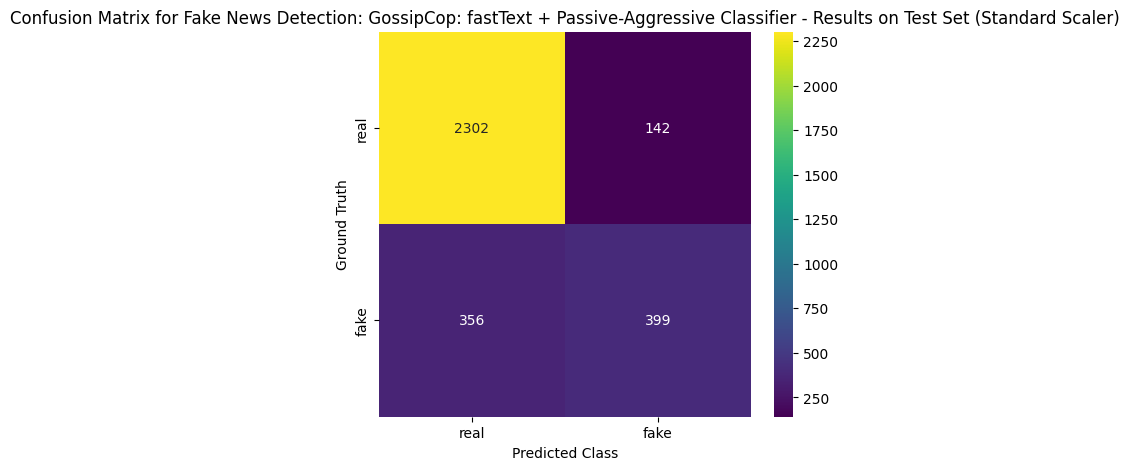

In [128]:
# Training data - returns both the features and a fitted Standard scaler
gc_X_train_std, gc_standard_fitted_scaler = combineFeatures(gc_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
gc_X_val_std = combineFeatures(gc_val_df, scaler=gc_standard_fitted_scaler)
# Test data - uses the fitted standard scaler
gc_X_test_std = combineFeatures(gc_test_df, scaler=gc_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
gc_train_output_file_std = "../../FPData/FastText/gc_X_train_embeddings_std_scaled.npy"
gc_val_output_file_std = "../../FPData/FastText/gc_X_val_embeddings_std_scaled.npy"
gc_test_output_file_std = "../../FPData/FastText/gc_X_test_embeddings_std_scaled.npy"
np.save(gc_train_output_file_std, gc_X_train_std)
np.save(gc_val_output_file_std, gc_X_val_std)
np.save(gc_test_output_file_std, gc_X_test_std)

# Gets the labels
gc_y_train = gc_train_df["label"].values
gc_y_val = gc_val_df["label"].values
gc_y_test = gc_test_df["label"].values

# Trains the model using standard scaled data
gc_std_pac_model, gc_std_best_c = trainPACModel(gc_X_train_std, gc_y_train)

# Evaluates the model on the validation set
gc_y_val_pred_std = gc_std_pac_model.predict(gc_X_val_std)
gc_std_val_eval_dict = classifierEvaluation(gc_y_val, gc_y_val_pred_std, 
                                            "GossipCop: fastText + Passive-Aggressive Classifier - Results on Validation Set (Standard Scaler)")

# Evaluates the model on the test set
gc_y_test_pred_std = gc_std_pac_model.predict(gc_X_test_std)
gc_std_test_eval_dict = classifierEvaluation(gc_y_test, gc_y_test_pred_std, 
                                             "GossipCop: fastText + Passive-Aggressive Classifier - Results on Test Set (Standard Scaler)")


#### Min-Max Scaler




rocessing embeddings...: 100%|█████████| 3199/3199 [00:00<00:00, 316953.17it/s]

The best C value was: 0.1
Accuracy: 0.8502
Precision (Macro): 0.8089
Recall (Macro): 0.7419
Macro F1-score: 0.7663

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2018
           1       0.75      0.54      0.63       612

    accuracy                           0.85      2630
   macro avg       0.81      0.74      0.77      2630
weighted avg       0.84      0.85      0.84      2630



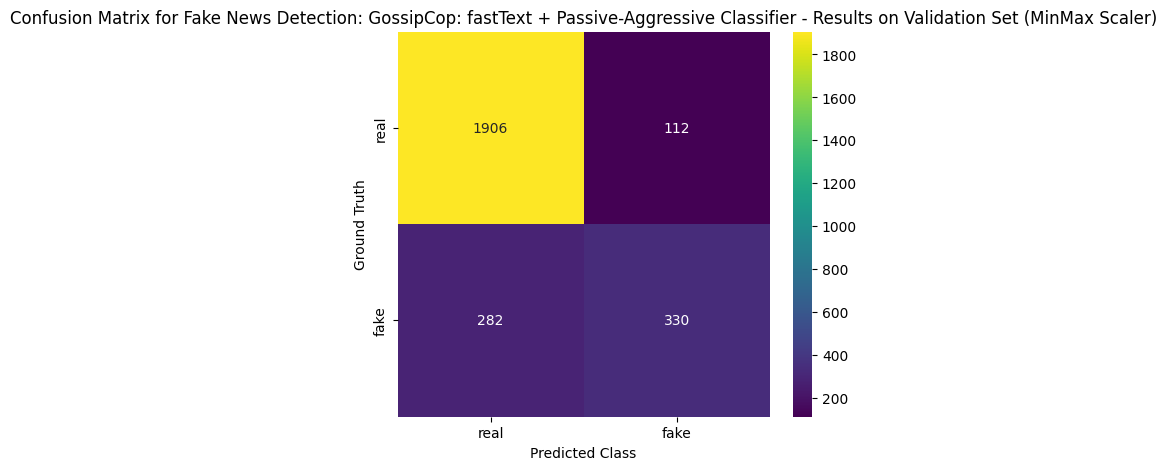

Accuracy: 0.8446
Precision (Macro): 0.7975
Recall (Macro): 0.7436
Macro F1-score: 0.7643

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2444
           1       0.72      0.55      0.63       755

    accuracy                           0.84      3199
   macro avg       0.80      0.74      0.76      3199
weighted avg       0.84      0.84      0.84      3199



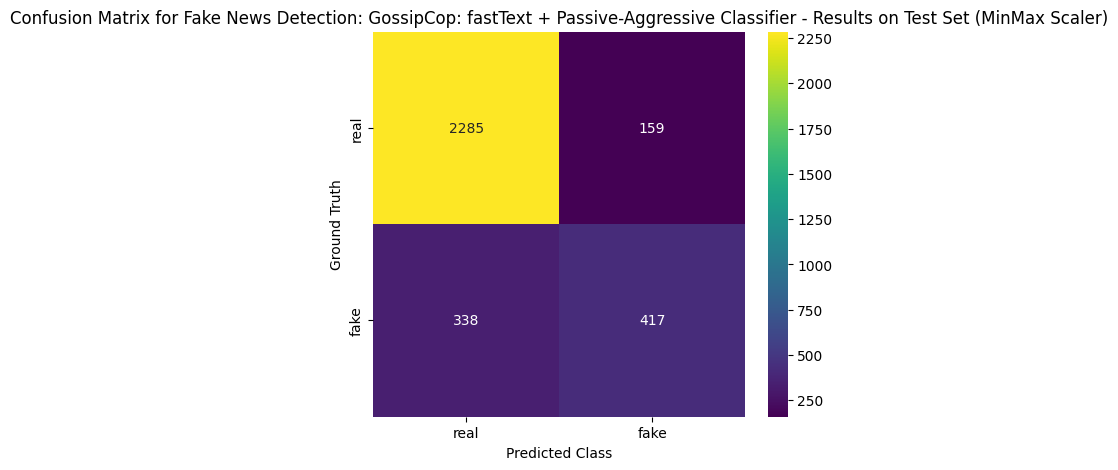

In [129]:
# Training data - returns both the features and a fitted MinMax scaler
gc_X_train_minmax, gc_minmax_fitted_scaler = combineFeatures(gc_train_df, scaler=None, use_min_max_scaler=True)  # Use MinMaxScaler

# Validation data - uses the fitted minmax scaler 
gc_X_val_minmax = combineFeatures(gc_val_df, scaler=gc_minmax_fitted_scaler)
# Test data - uses the fitted minmax scaler
gc_X_test_minmax = combineFeatures(gc_test_df, scaler=gc_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
gc_train_output_file_minmax = "../../FPData/FastText/gc_X_train_embeddings_minmax_scaled.npy"
gc_val_output_file_minmax = "../../FPData/FastText/gc_X_val_embeddings_minmax_scaled.npy"
gc_test_output_file_minmax = "../../FPData/FastText/gc_X_test_embeddings_minmax_scaled.npy"
np.save(gc_train_output_file_minmax, gc_X_train_minmax)
np.save(gc_val_output_file_minmax, gc_X_val_minmax)
np.save(gc_test_output_file_minmax, gc_X_test_minmax)

# Trains the model using minmax scaled data
gc_minmax_pac_model, gc_minmax_best_c = trainPACModel(gc_X_train_minmax, gc_y_train)

# Evaluates the model on the validation set
gc_y_val_pred_minmax = gc_minmax_pac_model.predict(gc_X_val_minmax)
gc_minmax_val_eval_dict = classifierEvaluation(gc_y_val, gc_y_val_pred_minmax, 
                                               "GossipCop: fastText + Passive-Aggressive Classifier - Results on Validation Set (MinMax Scaler)"
                                              )

# Evaluates the model on the test set
gc_y_test_pred_minmax = gc_minmax_pac_model.predict(gc_X_test_minmax)
gc_minmax_test_eval_dict = classifierEvaluation(gc_y_test, gc_y_test_pred_minmax,
                                                "GossipCop: fastText + Passive-Aggressive Classifier - Results on Test Set (MinMax Scaler)"
                                               )


### All-Four Combined

#### StandardScaler




rocessing embeddings...: 100%|███████| 16683/16683 [00:00<00:00, 347584.24it/s]

The best C value was: 0.01
Accuracy: 0.9328
Precision (Macro): 0.9296
Recall (Macro): 0.9289
Macro F1-score: 0.9293

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8656
           1       0.92      0.91      0.91      5531

    accuracy                           0.93     14187
   macro avg       0.93      0.93      0.93     14187
weighted avg       0.93      0.93      0.93     14187



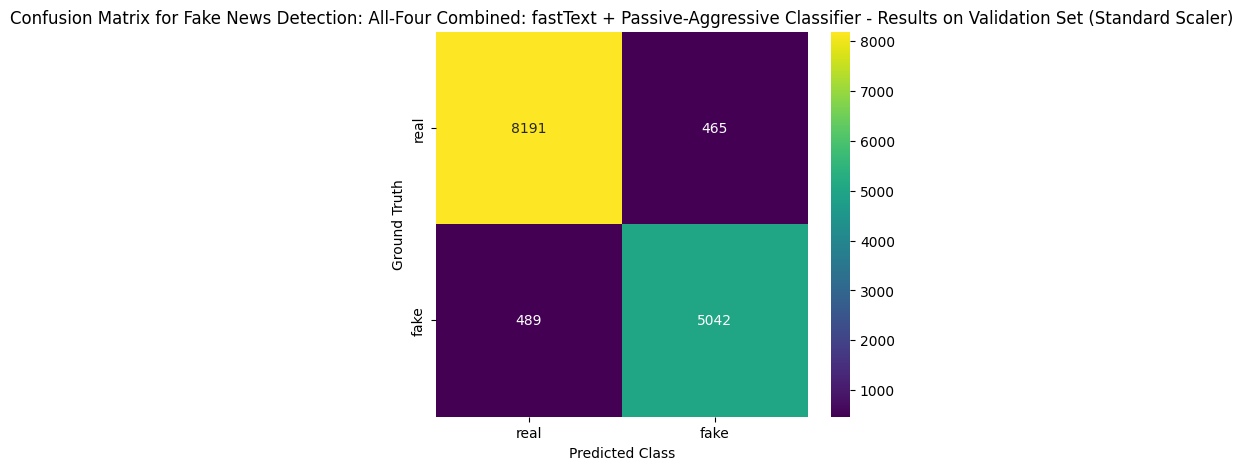

Accuracy: 0.9323
Precision (Macro): 0.9275
Recall (Macro): 0.9263
Macro F1-score: 0.9269

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10596
           1       0.91      0.90      0.91      6087

    accuracy                           0.93     16683
   macro avg       0.93      0.93      0.93     16683
weighted avg       0.93      0.93      0.93     16683



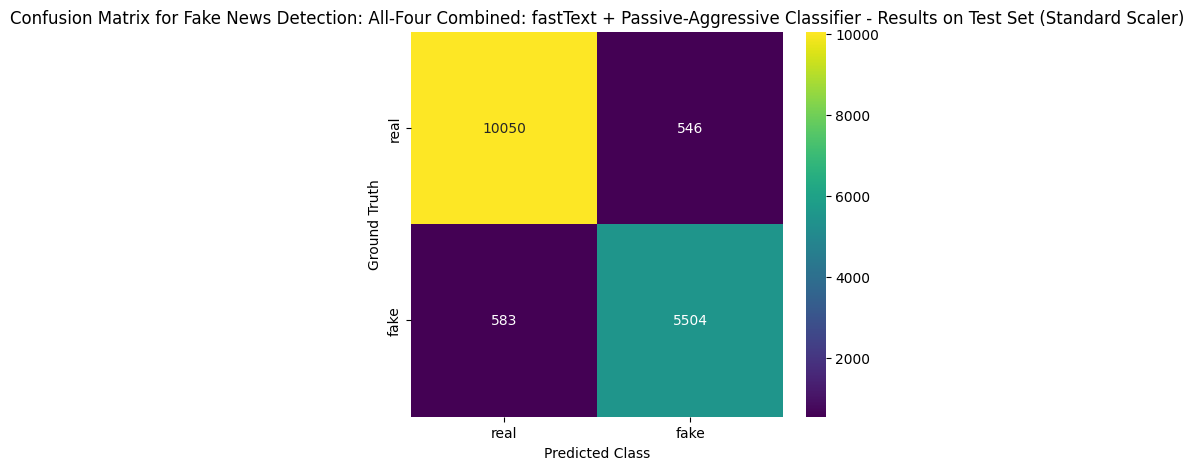

In [18]:
# Training data - returns both the features and a fitted Standard scaler
all_four_X_train_std, all_four_standard_fitted_scaler = combineFeatures(all_four_train_df, scaler=None)

# Validation data - now uses the fitted standard scaler 
all_four_X_val_std = combineFeatures(all_four_val_df, scaler=all_four_standard_fitted_scaler)
# Test data - now also uses the fitted standard scaler
all_four_X_test_std = combineFeatures(all_four_test_df, scaler=all_four_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
all_four_train_output_file_std = "../../FPData/FastText/all_four_X_train_embeddings_std_scaled.npy"
all_four_val_output_file_std = "../../FPData/FastText/all_four_X_val_embeddings_std_scaled.npy"
all_four_test_output_file_std = "../../FPData/FastText/all_four_X_test_embeddings_std_scaled.npy"
np.save(all_four_train_output_file_std, all_four_X_train_std)
np.save(all_four_val_output_file_std, all_four_X_val_std)
np.save(all_four_test_output_file_std, all_four_X_test_std)

# Extracts the labels for all splits
all_four_y_train = all_four_train_df["label"].values
all_four_y_val = all_four_val_df["label"].values
all_four_y_test = all_four_test_df["label"].values

# Trains the model using standard scaled data
all_four_std_pac_model, all_four_std_best_c = trainPACModel(all_four_X_train_std, all_four_y_train)

# Evaluates the model on the validation set
all_four_y_val_pred_std = all_four_std_pac_model.predict(all_four_X_val_std)

all_four_std_val_eval_dict = classifierEvaluation(all_four_y_val, all_four_y_val_pred_std, 
                                                 "All-Four Combined: fastText + Passive-Aggressive Classifier - Results on Validation Set (Standard Scaler)")

# Evaluates the model on the test set
all_four_y_test_pred_std = all_four_std_pac_model.predict(all_four_X_test_std)
all_four_std_test_eval_dict = classifierEvaluation(all_four_y_test, all_four_y_test_pred_std, 
                                                  "All-Four Combined: fastText + Passive-Aggressive Classifier - Results on Test Set (Standard Scaler)")


### Wrapping the model in CalibratedClassifierCV and saving it to disk for generating LIME explanations in Streamlit app

In [56]:
# Trains the Passive-Aggressive model again
pac = PassiveAggressiveClassifier(C=all_four_std_best_c, max_iter=1000, random_state=5)

# Wraps the Passive-Aggressive Classifier in Calibrated Classifier CV to output probabilities
calibrated_pac = CalibratedClassifierCV(pac, method="sigmoid", cv=5)

# Trains the pipeline
calibrated_pac.fit(all_four_X_train_std, all_four_y_train)

# Saves the fitted scaler
joblib.dump(all_four_standard_fitted_scaler, "all_four_standard_scaler.pkl")

# Saves the trained pipeline to disk
joblib.dump(calibrated_pac, "all_four_calib_model.pkl")

['all_four_calib_model.pkl']

#### Min-Max Scaler




rocessing embeddings...: 100%|███████| 16683/16683 [00:00<00:00, 330318.00it/s]

The best C value was: 0.01
Accuracy: 0.9309
Precision (Macro): 0.9265
Recall (Macro): 0.9287
Macro F1-score: 0.9276

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      8656
           1       0.91      0.92      0.91      5531

    accuracy                           0.93     14187
   macro avg       0.93      0.93      0.93     14187
weighted avg       0.93      0.93      0.93     14187



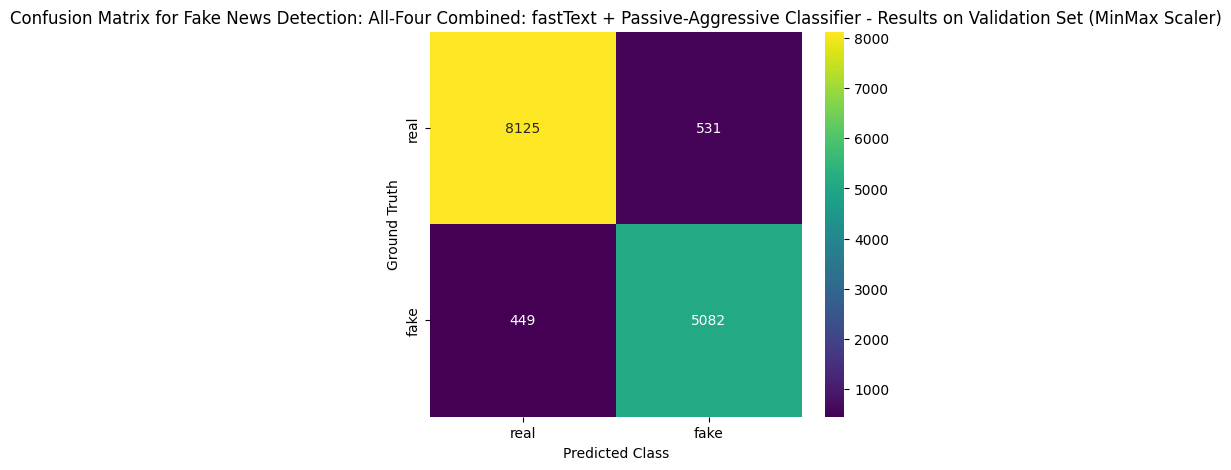

Accuracy: 0.9315
Precision (Macro): 0.9252
Recall (Macro): 0.9274
Macro F1-score: 0.9263

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     10596
           1       0.90      0.91      0.91      6087

    accuracy                           0.93     16683
   macro avg       0.93      0.93      0.93     16683
weighted avg       0.93      0.93      0.93     16683



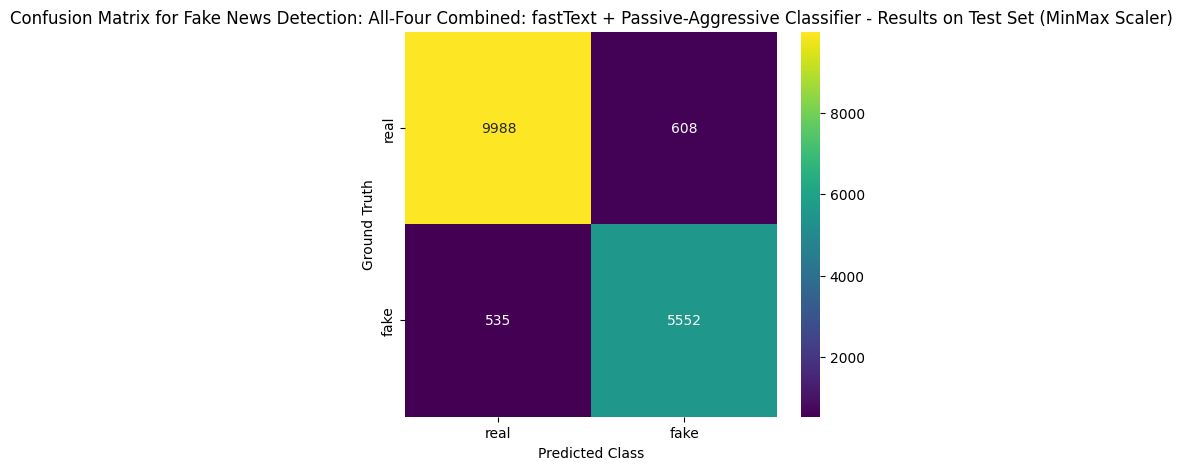

In [141]:
# Training data - returns both the features and a fitted MinMax scaler
all_four_X_train_minmax, all_four_minmax_fitted_scaler = combineFeatures(all_four_train_df, scaler=None, use_min_max_scaler=True) 

# Validation data - uses the fitted minmax scaler 
all_four_X_val_minmax = combineFeatures(all_four_val_df, scaler=all_four_minmax_fitted_scaler)
# Test data - uses the fitted minmax scaler
all_four_X_test_minmax = combineFeatures(all_four_test_df, scaler=all_four_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
all_four_train_output_file_minmax = "../../FPData/FastText/all_four_X_train_embeddings_minmax_scaled.npy"
all_four_val_output_file_minmax = "../../FPData/FastText/all_four_X_val_embeddings_minmax_scaled.npy"
all_four_test_output_file_minmax = "../../FPData/FastText/all_four_X_test_embeddings_minmax_scaled.npy"
np.save(all_four_train_output_file_minmax, all_four_X_train_minmax)
np.save(all_four_val_output_file_minmax, all_four_X_val_minmax)
np.save(all_four_test_output_file_minmax, all_four_X_test_minmax)

# Trains the model using minmax scaled data
all_four_minmax_pac_model, all_four_minmax_best_c = trainPACModel(all_four_X_train_minmax, all_four_y_train)

# Evaluates the model on the validation set
all_four_y_val_pred_minmax = all_four_minmax_pac_model.predict(all_four_X_val_minmax)
all_four_minmax_val_eval_dict = classifierEvaluation(all_four_y_val, all_four_y_val_pred_minmax, 
                                                    "All-Four Combined: fastText + Passive-Aggressive Classifier - Results on Validation Set (MinMax Scaler)"
                                                   )

# Evaluates the model on the test set
all_four_y_test_pred_minmax = all_four_minmax_pac_model.predict(all_four_X_test_minmax)
all_four_minmax_test_eval_dict = classifierEvaluation(all_four_y_test, all_four_y_test_pred_minmax,
                                                     "All-Four Combined: fastText + Passive-Aggressive Classifier - Results on Test Set (MinMax Scaler)"
                                                    )


## Five-Shot Evaluation Scenario

### Five-Shot: WELFake Target

#### StandardScaler




rocessing embeddings...: 100%|███████| 11237/11237 [00:00<00:00, 333950.20it/s]

The best C value was: 0.1
Accuracy: 0.6079
Precision (Macro): 0.5936
Recall (Macro): 0.5918
Macro F1-score: 0.5923

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      5463
           1       0.53      0.50      0.51      3862

    accuracy                           0.61      9325
   macro avg       0.59      0.59      0.59      9325
weighted avg       0.60      0.61      0.61      9325



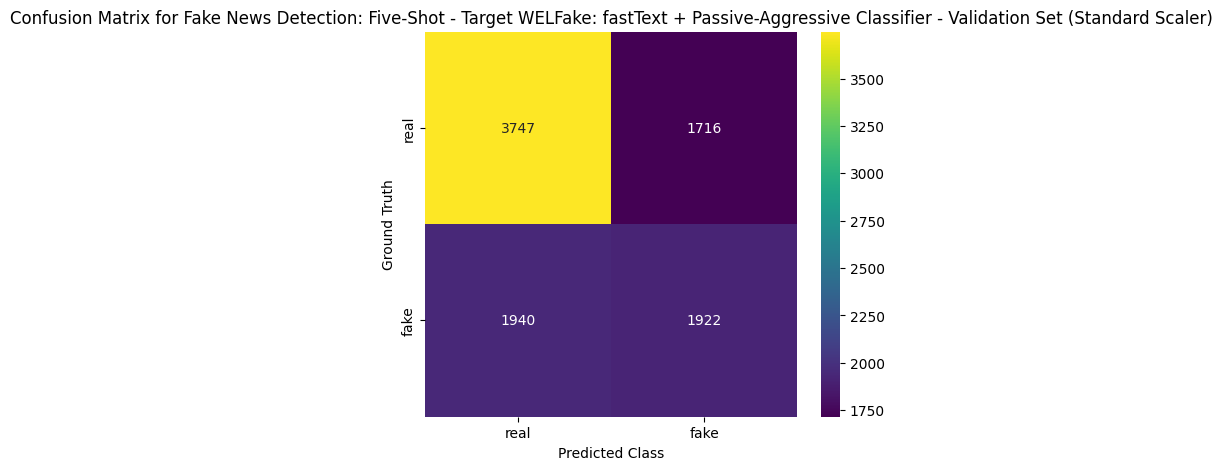

Accuracy: 0.5906
Precision (Macro): 0.5727
Recall (Macro): 0.5751
Macro F1-score: 0.5730

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      6976
           1       0.46      0.51      0.49      4261

    accuracy                           0.59     11237
   macro avg       0.57      0.58      0.57     11237
weighted avg       0.60      0.59      0.59     11237



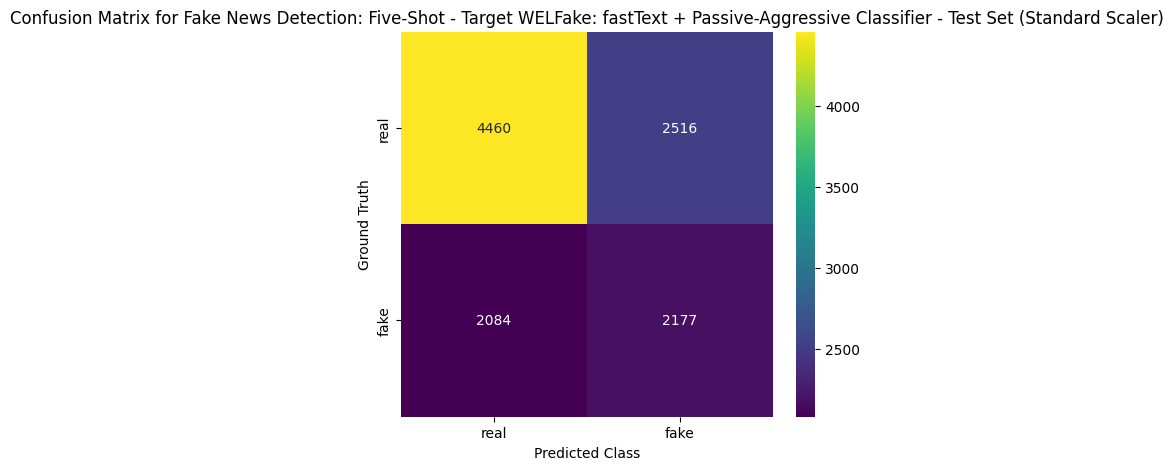

In [53]:
# Training data - returns both the features and a fitted Standard scaler
five_shot_wf_X_train_std, five_shot_wf_standard_fitted_scaler = combineFeatures(five_shot_wf_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
five_shot_wf_X_val_std = combineFeatures(five_shot_wf_target_val_df, scaler=five_shot_wf_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
five_shot_wf_X_test_std = combineFeatures(five_shot_wf_target_test_df, scaler=five_shot_wf_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
five_shot_wf_train_output_file_std = "../../FPData/FastText/five_shot_wf_X_train_embeddings_std_scaled.npy"
five_shot_wf_val_output_file_std = "../../FPData/FastText/five_shot_wf_X_val_embeddings_std_scaled.npy"
five_shot_wf_test_output_file_std = "../../FPData/FastText/five_shot_wf_X_test_embeddings_std_scaled.npy"
np.save(five_shot_wf_train_output_file_std, five_shot_wf_X_train_std)
np.save(five_shot_wf_val_output_file_std, five_shot_wf_X_val_std)
np.save(five_shot_wf_test_output_file_std, five_shot_wf_X_test_std)

# Gets the labels
five_shot_wf_y_train = five_shot_wf_target_train_df["label"].values
five_shot_wf_y_val = five_shot_wf_target_val_df["label"].values
five_shot_wf_y_test = five_shot_wf_target_test_df["label"].values

# Trains the model using standard scaled data
five_shot_wf_std_pac_model, five_shot_wf_std_best_c = trainPACModel(five_shot_wf_X_train_std, five_shot_wf_y_train)

# Evaluates the model on validation set
five_shot_wf_y_val_pred_std = five_shot_wf_std_pac_model.predict(five_shot_wf_X_val_std)
five_shot_wf_std_val_eval_dict = classifierEvaluation(five_shot_wf_y_val, five_shot_wf_y_val_pred_std, 
                                            "Five-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on test set
five_shot_wf_y_test_pred_std = five_shot_wf_std_pac_model.predict(five_shot_wf_X_test_std)
five_shot_wf_std_test_eval_dict = classifierEvaluation(five_shot_wf_y_test, five_shot_wf_y_test_pred_std, 
                                             "Five-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")

#### Min-Max Scaler




rocessing embeddings...: 100%|███████| 11237/11237 [00:00<00:00, 311730.00it/s]

The best C value was: 1
Accuracy: 0.4626
Precision (Macro): 0.5612
Recall (Macro): 0.5277
Macro F1-score: 0.4139

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.15      0.24      5463
           1       0.43      0.91      0.58      3862

    accuracy                           0.46      9325
   macro avg       0.56      0.53      0.41      9325
weighted avg       0.58      0.46      0.38      9325



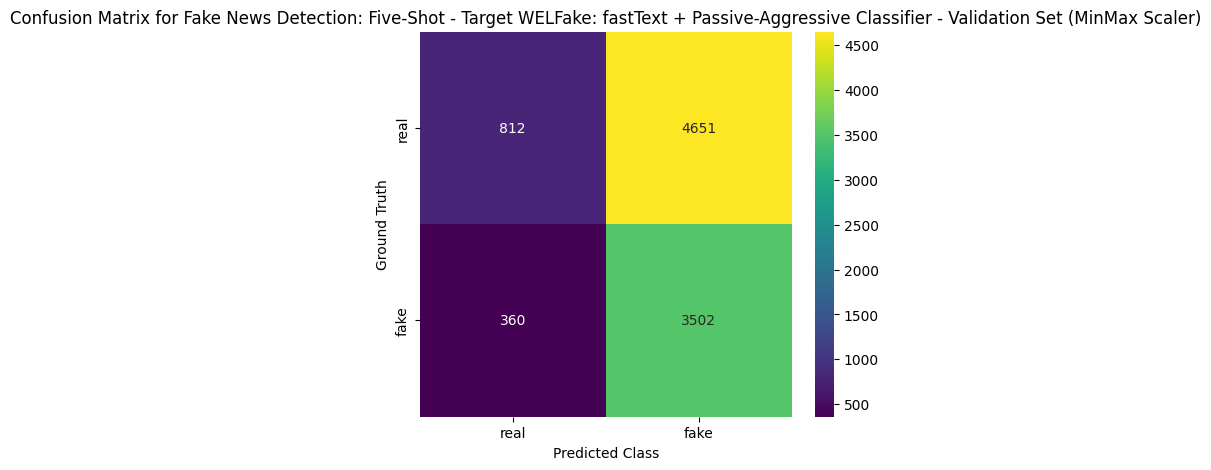

Accuracy: 0.4281
Precision (Macro): 0.5581
Recall (Macro): 0.5240
Macro F1-score: 0.3831

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.13      0.22      6976
           1       0.39      0.92      0.55      4261

    accuracy                           0.43     11237
   macro avg       0.56      0.52      0.38     11237
weighted avg       0.60      0.43      0.34     11237



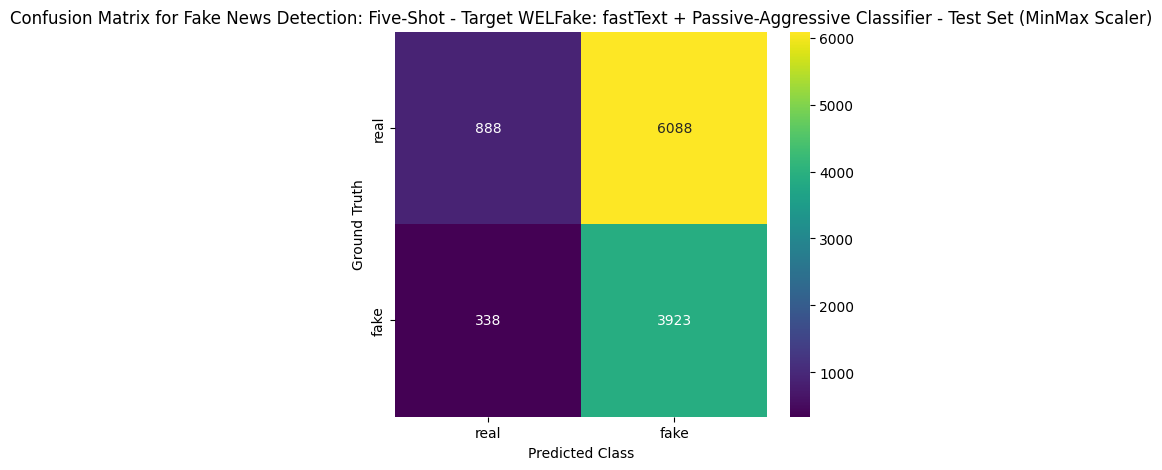

In [54]:
# Training data - returns both the features and a fitted MinMax scaler
five_shot_wf_X_train_minmax, five_shot_wf_minmax_fitted_scaler = combineFeatures(
    five_shot_wf_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
five_shot_wf_X_val_minmax = combineFeatures(five_shot_wf_target_val_df, scaler=five_shot_wf_minmax_fitted_scaler) 

# Test data - uses the fitted minmax scaler
five_shot_wf_X_test_minmax = combineFeatures(five_shot_wf_target_test_df, scaler=five_shot_wf_minmax_fitted_scaler) 

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
five_shot_wf_train_output_file_minmax = "../../FPData/FastText/five_shot_wf_X_train_embeddings_minmax_scaled.npy"
five_shot_wf_val_output_file_minmax = "../../FPData/FastText/five_shot_wf_X_val_embeddings_minmax_scaled.npy"
five_shot_wf_test_output_file_minmax = "../../FPData/FastText/five_shot_wf_X_test_embeddings_minmax_scaled.npy"
np.save(five_shot_wf_train_output_file_minmax, five_shot_wf_X_train_minmax)
np.save(five_shot_wf_val_output_file_minmax, five_shot_wf_X_val_minmax)
np.save(five_shot_wf_test_output_file_minmax, five_shot_wf_X_test_minmax)

# Trains the model using minmax scaled data
five_shot_wf_minmax_pac_model, five_shot_wf_minmax_best_c = trainPACModel(five_shot_wf_X_train_minmax, five_shot_wf_y_train)

# Evaluate the model on the validation set
five_shot_wf_y_val_pred_minmax = five_shot_wf_minmax_pac_model.predict(five_shot_wf_X_val_minmax)
five_shot_wf_minmax_val_eval_dict = classifierEvaluation(five_shot_wf_y_val, five_shot_wf_y_val_pred_minmax, 
                                            "Five-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluate the model on the test set
five_shot_wf_y_test_pred_minmax = five_shot_wf_minmax_pac_model.predict(five_shot_wf_X_test_minmax)
five_shot_wf_minmax_test_eval_dict = classifierEvaluation(five_shot_wf_y_test, five_shot_wf_y_test_pred_minmax,
                                             "Five-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )


### Five-Shot: Constraint Target

#### StandardScaler




rocessing embeddings...: 100%|█████████| 2122/2122 [00:00<00:00, 327989.13it/s]

The best C value was: 0.1
Accuracy: 0.4586
Precision (Macro): 0.4622
Recall (Macro): 0.4690
Macro F1-score: 0.4386

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.26      0.33      1116
           1       0.45      0.68      0.54      1012

    accuracy                           0.46      2128
   macro avg       0.46      0.47      0.44      2128
weighted avg       0.46      0.46      0.43      2128



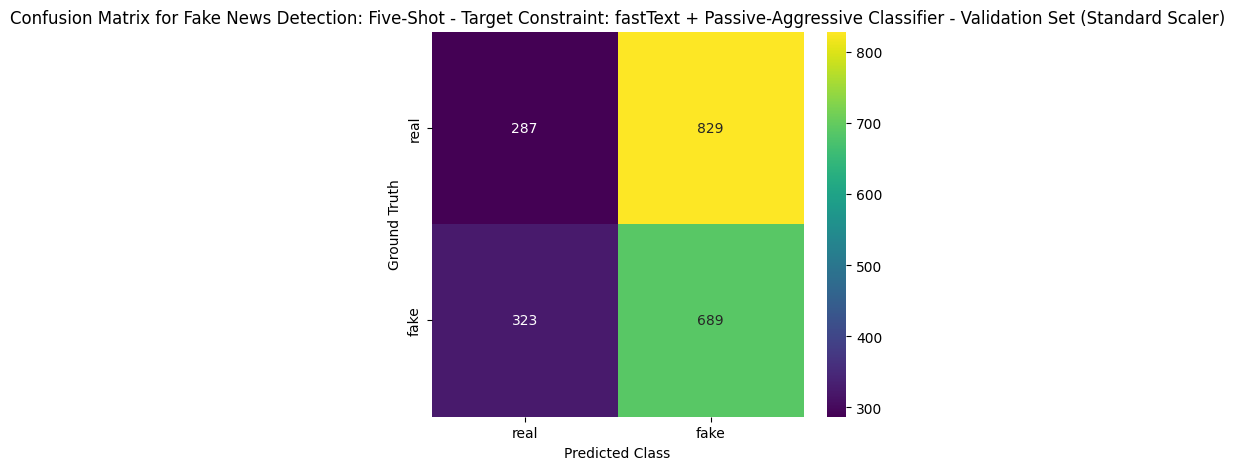

Accuracy: 0.4486
Precision (Macro): 0.4508
Recall (Macro): 0.4589
Macro F1-score: 0.4304

Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.26      0.33      1115
           1       0.45      0.66      0.53      1007

    accuracy                           0.45      2122
   macro avg       0.45      0.46      0.43      2122
weighted avg       0.45      0.45      0.43      2122



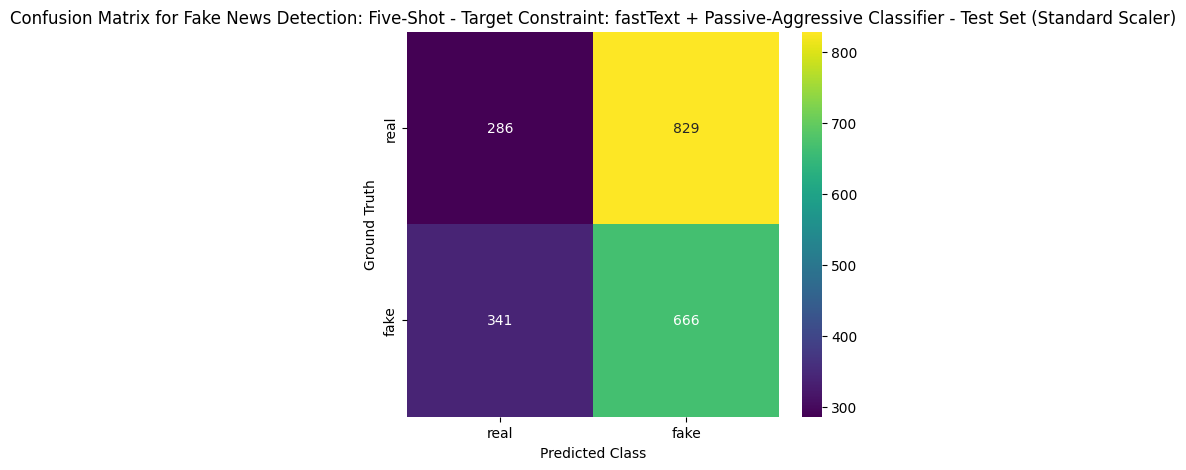

In [56]:
# Training data - returns both the features and a fitted Standard scaler
five_shot_ct_X_train_std, five_shot_ct_standard_fitted_scaler = combineFeatures(five_shot_ct_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
five_shot_ct_X_val_std = combineFeatures(five_shot_ct_target_val_df, scaler=five_shot_ct_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
five_shot_ct_X_test_std = combineFeatures(five_shot_ct_target_test_df, scaler=five_shot_ct_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
five_shot_ct_train_output_file_std = "../../FPData/FastText/five_shot_ct_X_train_embeddings_std_scaled.npy"
five_shot_ct_val_output_file_std = "../../FPData/FastText/five_shot_ct_X_val_embeddings_std_scaled.npy"
five_shot_ct_test_output_file_std = "../../FPData/FastText/five_shot_ct_X_test_embeddings_std_scaled.npy"
np.save(five_shot_ct_train_output_file_std, five_shot_ct_X_train_std)
np.save(five_shot_ct_val_output_file_std, five_shot_ct_X_val_std)
np.save(five_shot_ct_test_output_file_std, five_shot_ct_X_test_std)

# Gets the labels
five_shot_ct_y_train = five_shot_ct_target_train_df["label"].values
five_shot_ct_y_val = five_shot_ct_target_val_df["label"].values
five_shot_ct_y_test = five_shot_ct_target_test_df["label"].values

# Trains the model using standard scaled data
five_shot_ct_std_pac_model, five_shot_ct_std_best_c = trainPACModel(five_shot_ct_X_train_std, five_shot_ct_y_train)

# Evaluates the model on the validation set
five_shot_ct_y_val_pred_std = five_shot_ct_std_pac_model.predict(five_shot_ct_X_val_std)
five_shot_ct_std_val_eval_dict = classifierEvaluation(five_shot_ct_y_val, five_shot_ct_y_val_pred_std, 
                                            "Five-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
five_shot_ct_y_test_pred_std = five_shot_ct_std_pac_model.predict(five_shot_ct_X_test_std)
five_shot_ct_std_test_eval_dict = classifierEvaluation(five_shot_ct_y_test, five_shot_ct_y_test_pred_std, 
                                             "Five-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")


#### Min-Max Scaler




rocessing embeddings...: 100%|█████████| 2122/2122 [00:00<00:00, 338003.69it/s]

The best C value was: 0.1
Accuracy: 0.4873
Precision (Macro): 0.4960
Recall (Macro): 0.4966
Macro F1-score: 0.4730

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.31      0.39      1116
           1       0.47      0.69      0.56      1012

    accuracy                           0.49      2128
   macro avg       0.50      0.50      0.47      2128
weighted avg       0.50      0.49      0.47      2128



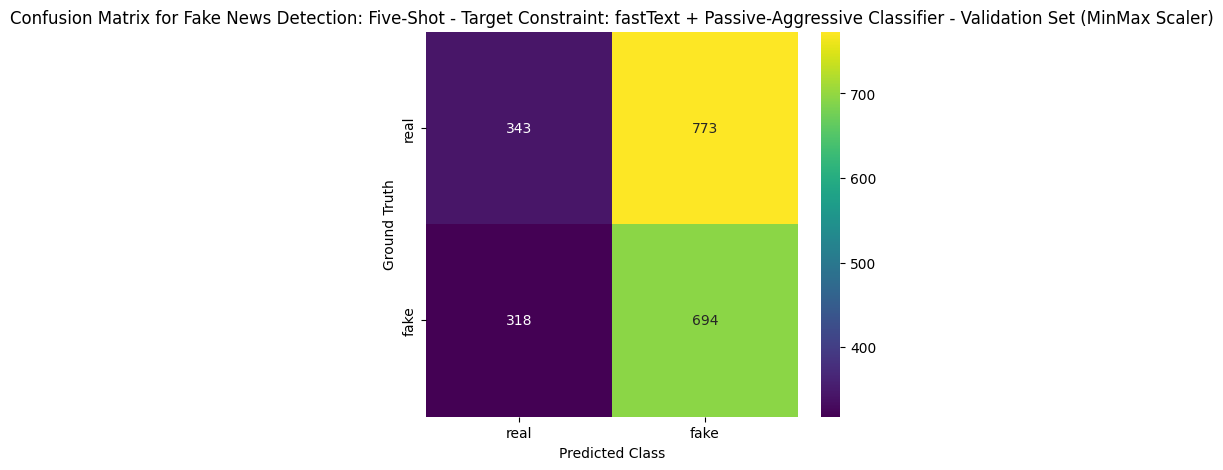

Accuracy: 0.4609
Precision (Macro): 0.4656
Recall (Macro): 0.4699
Macro F1-score: 0.4480

Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.29      0.36      1115
           1       0.45      0.65      0.53      1007

    accuracy                           0.46      2122
   macro avg       0.47      0.47      0.45      2122
weighted avg       0.47      0.46      0.44      2122



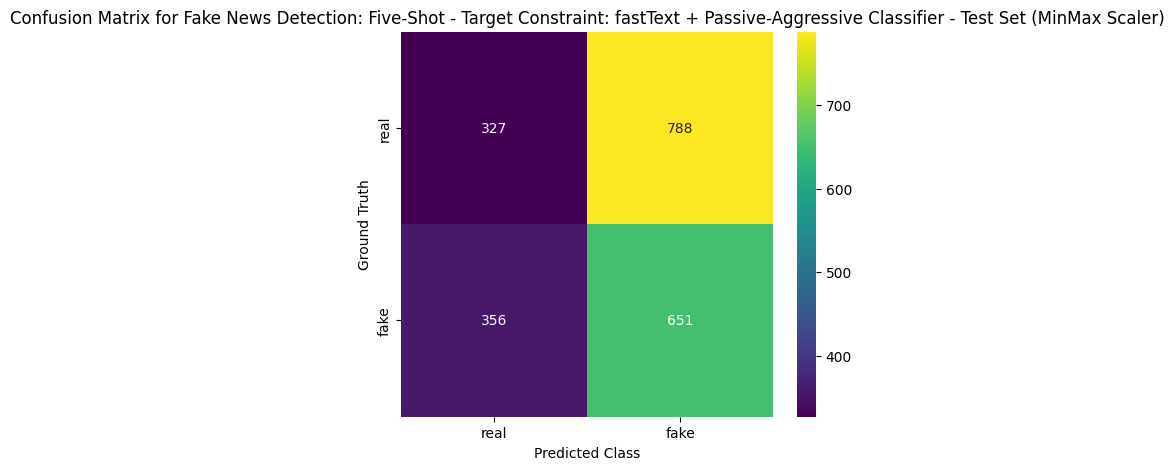

In [57]:
# Training data - returns both the features and a fitted MinMax scaler
five_shot_ct_X_train_minmax, five_shot_ct_minmax_fitted_scaler = combineFeatures(
    five_shot_ct_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
five_shot_ct_X_val_minmax = combineFeatures(five_shot_ct_target_val_df, scaler=five_shot_ct_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
five_shot_ct_X_test_minmax = combineFeatures(five_shot_ct_target_test_df, scaler=five_shot_ct_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
five_shot_ct_train_output_file_minmax = "../../FPData/FastText/five_shot_ct_X_train_embeddings_minmax_scaled.npy"
five_shot_ct_val_output_file_minmax = "../../FPData/FastText/five_shot_ct_X_val_embeddings_minmax_scaled.npy"
five_shot_ct_test_output_file_minmax = "../../FPData/FastText/five_shot_ct_X_test_embeddings_minmax_scaled.npy"
np.save(five_shot_ct_train_output_file_minmax, five_shot_ct_X_train_minmax)
np.save(five_shot_ct_val_output_file_minmax, five_shot_ct_X_val_minmax)
np.save(five_shot_ct_test_output_file_minmax, five_shot_ct_X_test_minmax)

# Trains the model using minmax scaled data
five_shot_ct_minmax_pac_model, five_shot_ct_minmax_best_c = trainPACModel(five_shot_ct_X_train_minmax, five_shot_ct_y_train)

# Evaluates the model on the validation set
five_shot_ct_y_val_pred_minmax = five_shot_ct_minmax_pac_model.predict(five_shot_ct_X_val_minmax)
five_shot_ct_minmax_val_eval_dict = classifierEvaluation(five_shot_ct_y_val, five_shot_ct_y_val_pred_minmax, 
                                            "Five-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
five_shot_ct_y_test_pred_minmax = five_shot_ct_minmax_pac_model.predict(five_shot_ct_X_test_minmax)
five_shot_ct_minmax_test_eval_dict = classifierEvaluation(five_shot_ct_y_test, five_shot_ct_y_test_pred_minmax,
                                             "Five-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )


### Five-Shot: PolitiFact Target

#### StandardScaler




rocessing embeddings...: 100%|███████████| 126/126 [00:00<00:00, 231688.87it/s]

The best C value was: 10
Accuracy: 0.7019
Precision (Macro): 0.7083
Recall (Macro): 0.7109
Macro F1-score: 0.7017

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.64      0.71        59
           1       0.62      0.78      0.69        45

    accuracy                           0.70       104
   macro avg       0.71      0.71      0.70       104
weighted avg       0.72      0.70      0.70       104



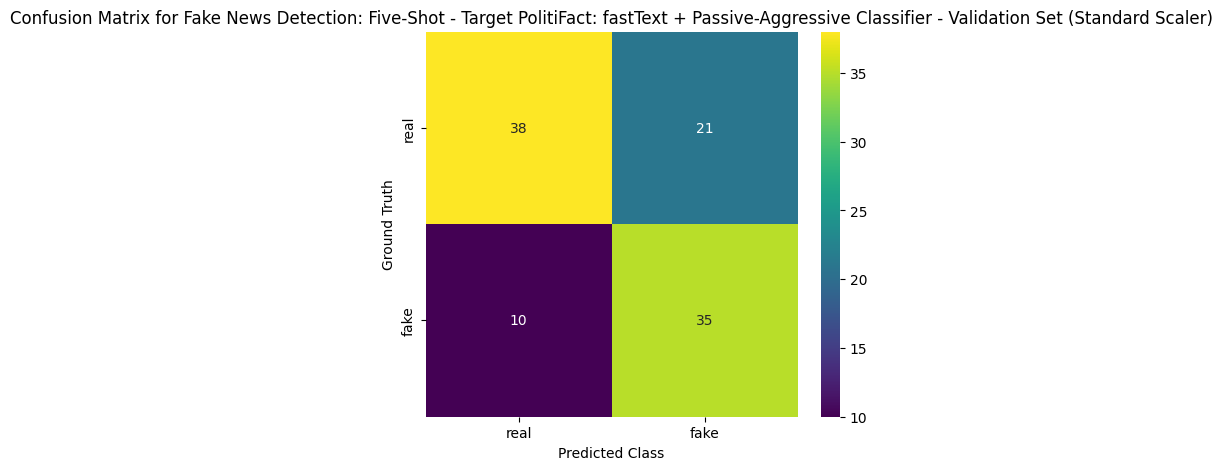

Accuracy: 0.6905
Precision (Macro): 0.6946
Recall (Macro): 0.6924
Macro F1-score: 0.6900

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.75      0.70        61
           1       0.73      0.63      0.68        65

    accuracy                           0.69       126
   macro avg       0.69      0.69      0.69       126
weighted avg       0.70      0.69      0.69       126



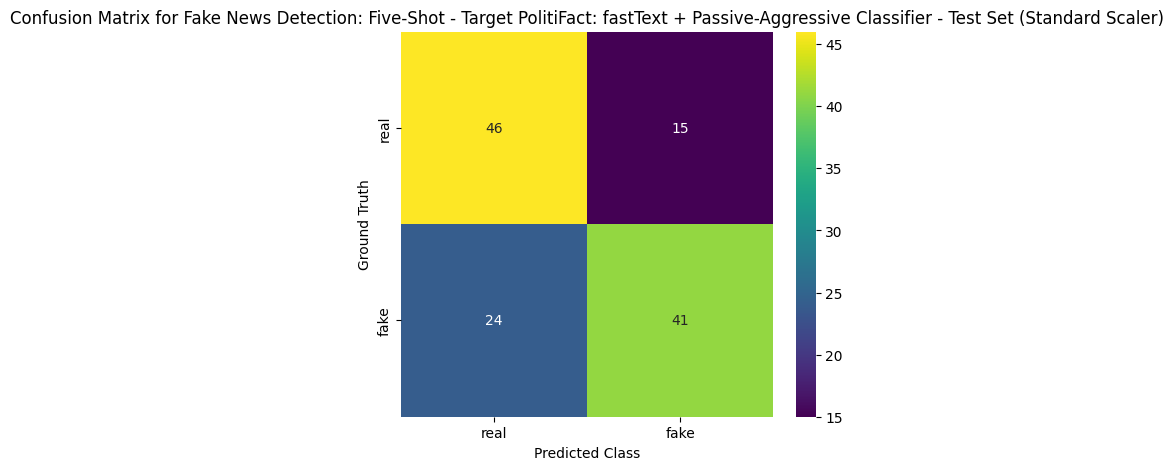

In [34]:
# Training data - returns both the features and a fitted Standard scaler
five_shot_pf_X_train_std, five_shot_pf_standard_fitted_scaler = combineFeatures(five_shot_pf_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
five_shot_pf_X_val_std = combineFeatures(five_shot_pf_target_val_df, scaler=five_shot_pf_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
five_shot_pf_X_test_std = combineFeatures(five_shot_pf_target_test_df, scaler=five_shot_pf_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
five_shot_pf_train_output_file_std = "../../FPData/FastText/five_shot_pf_X_train_embeddings_std_scaled.npy"
five_shot_pf_val_output_file_std = "../../FPData/FastText/five_shot_pf_X_val_embeddings_std_scaled.npy"
five_shot_pf_test_output_file_std = "../../FPData/FastText/five_shot_pf_X_test_embeddings_std_scaled.npy"
np.save(five_shot_pf_train_output_file_std, five_shot_pf_X_train_std)
np.save(five_shot_pf_val_output_file_std, five_shot_pf_X_val_std)
np.save(five_shot_pf_test_output_file_std, five_shot_pf_X_test_std)

# Gets the labels
five_shot_pf_y_train = five_shot_pf_target_train_df["label"].values
five_shot_pf_y_val = five_shot_pf_target_val_df["label"].values
five_shot_pf_y_test = five_shot_pf_target_test_df["label"].values

# Trains the model using standard scaled data
five_shot_pf_std_pac_model, five_shot_pf_std_best_c = trainPACModel(five_shot_pf_X_train_std, five_shot_pf_y_train)

# Evaluates the model on the validation set
five_shot_pf_y_val_pred_std = five_shot_pf_std_pac_model.predict(five_shot_pf_X_val_std)
five_shot_pf_std_val_eval_dict = classifierEvaluation(five_shot_pf_y_val, five_shot_pf_y_val_pred_std, 
                                            "Five-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
five_shot_pf_y_test_pred_std = five_shot_pf_std_pac_model.predict(five_shot_pf_X_test_std)
five_shot_pf_std_test_eval_dict = classifierEvaluation(five_shot_pf_y_test, five_shot_pf_y_test_pred_std, 
                                             "Five-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")


#### Min-Max Scaler




rocessing embeddings...: 100%|███████████| 126/126 [00:00<00:00, 300103.52it/s]

The best C value was: 0.1
Accuracy: 0.7019
Precision (Macro): 0.6982
Recall (Macro): 0.6872
Macro F1-score: 0.6893

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        59
           1       0.68      0.58      0.63        45

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104



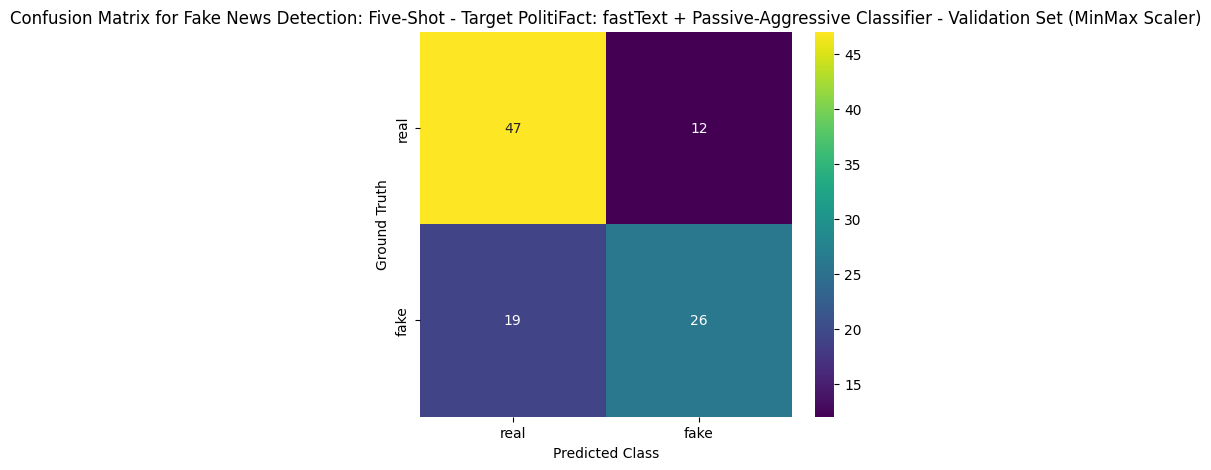

Accuracy: 0.7143
Precision (Macro): 0.7147
Recall (Macro): 0.7130
Macro F1-score: 0.7131

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.67      0.69        61
           1       0.71      0.75      0.73        65

    accuracy                           0.71       126
   macro avg       0.71      0.71      0.71       126
weighted avg       0.71      0.71      0.71       126



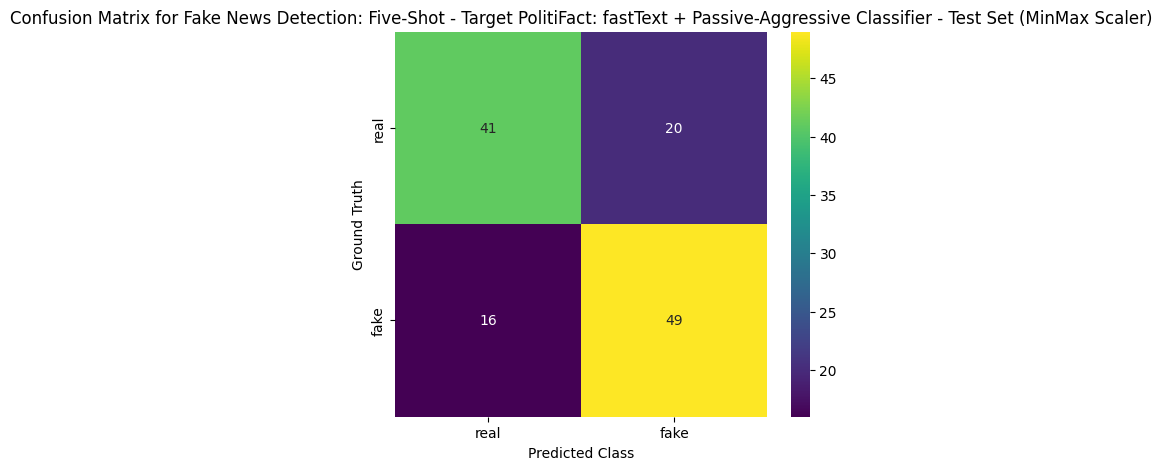

In [35]:
# Training data - returns both the features and a fitted MinMax scaler
five_shot_pf_X_train_minmax, five_shot_pf_minmax_fitted_scaler = combineFeatures(
    five_shot_pf_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
five_shot_pf_X_val_minmax = combineFeatures(five_shot_pf_target_val_df, scaler=five_shot_pf_minmax_fitted_scaler) 

# Test data - uses the fitted minmax scaler
five_shot_pf_X_test_minmax = combineFeatures(five_shot_pf_target_test_df, scaler=five_shot_pf_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
five_shot_pf_train_output_file_minmax = "../../FPData/FastText/five_shot_pf_X_train_embeddings_minmax_scaled.npy"
five_shot_pf_val_output_file_minmax = "../../FPData/FastText/five_shot_pf_X_val_embeddings_minmax_scaled.npy"
five_shot_pf_test_output_file_minmax = "../../FPData/FastText/five_shot_pf_X_test_embeddings_minmax_scaled.npy"
np.save(five_shot_pf_train_output_file_minmax, five_shot_pf_X_train_minmax)
np.save(five_shot_pf_val_output_file_minmax, five_shot_pf_X_val_minmax)
np.save(five_shot_pf_test_output_file_minmax, five_shot_pf_X_test_minmax)

# Trains the model using minmax scaled data
five_shot_pf_minmax_pac_model, five_shot_pf_minmax_best_c = trainPACModel(five_shot_pf_X_train_minmax, five_shot_pf_y_train)

# Evaluates the model on the validation set
five_shot_pf_y_val_pred_minmax = five_shot_pf_minmax_pac_model.predict(five_shot_pf_X_val_minmax)
five_shot_pf_minmax_val_eval_dict = classifierEvaluation(five_shot_pf_y_val, five_shot_pf_y_val_pred_minmax, 
                                            "Five-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
five_shot_pf_y_test_pred_minmax = five_shot_pf_minmax_pac_model.predict(five_shot_pf_X_test_minmax)
five_shot_pf_minmax_test_eval_dict = classifierEvaluation(five_shot_pf_y_test, five_shot_pf_y_test_pred_minmax,
                                             "Five-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )


### Five-Shot: GossipCop Target

#### StandardScaler




rocessing embeddings...: 100%|█████████| 3199/3199 [00:00<00:00, 310247.38it/s]

The best C value was: 0.1
Accuracy: 0.3848
Precision (Macro): 0.5504
Recall (Macro): 0.5484
Macro F1-score: 0.3847

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.24      0.38      2018
           1       0.25      0.85      0.39       612

    accuracy                           0.38      2630
   macro avg       0.55      0.55      0.38      2630
weighted avg       0.71      0.38      0.38      2630



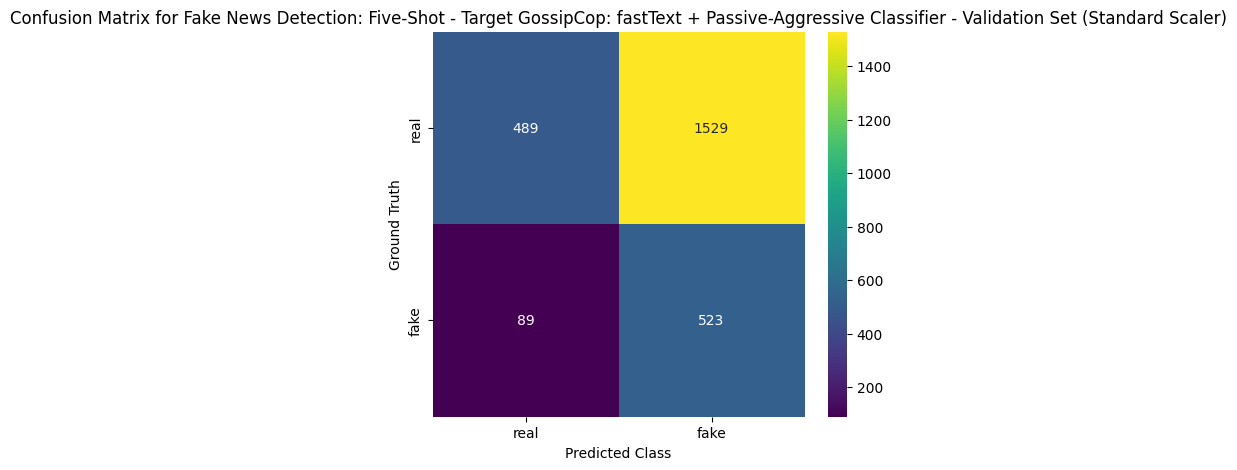

Accuracy: 0.3979
Precision (Macro): 0.5383
Recall (Macro): 0.5401
Macro F1-score: 0.3978

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.27      0.41      2444
           1       0.26      0.81      0.39       755

    accuracy                           0.40      3199
   macro avg       0.54      0.54      0.40      3199
weighted avg       0.69      0.40      0.40      3199



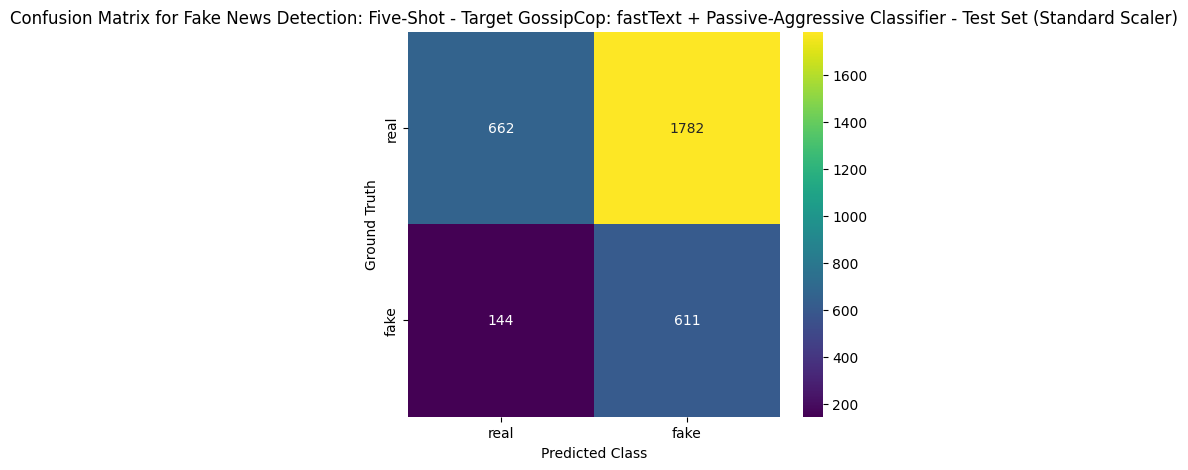

In [60]:
# Training data - returns both the features and a fitted Standard scaler
five_shot_gc_X_train_std, five_shot_gc_standard_fitted_scaler = combineFeatures(five_shot_gc_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
five_shot_gc_X_val_std = combineFeatures(five_shot_gc_target_val_df, scaler=five_shot_gc_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
five_shot_gc_X_test_std = combineFeatures(five_shot_gc_target_test_df, scaler=five_shot_gc_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
five_shot_gc_train_output_file_std = "../../FPData/FastText/five_shot_gc_X_train_embeddings_std_scaled.npy"
five_shot_gc_val_output_file_std = "../../FPData/FastText/five_shot_gc_X_val_embeddings_std_scaled.npy"
five_shot_gc_test_output_file_std = "../../FPData/FastText/five_shot_gc_X_test_embeddings_std_scaled.npy"
np.save(five_shot_gc_train_output_file_std, five_shot_gc_X_train_std)
np.save(five_shot_gc_val_output_file_std, five_shot_gc_X_val_std)
np.save(five_shot_gc_test_output_file_std, five_shot_gc_X_test_std)

# Gets the labels
five_shot_gc_y_train = five_shot_gc_target_train_df["label"].values
five_shot_gc_y_val = five_shot_gc_target_val_df["label"].values
five_shot_gc_y_test = five_shot_gc_target_test_df["label"].values

# Trains the model using the standard scaled data
five_shot_gc_std_pac_model, five_shot_gc_std_best_c = trainPACModel(five_shot_gc_X_train_std, five_shot_gc_y_train)

# Evaluates the model on the validation set
five_shot_gc_y_val_pred_std = five_shot_gc_std_pac_model.predict(five_shot_gc_X_val_std)
five_shot_gc_std_val_eval_dict = classifierEvaluation(five_shot_gc_y_val, five_shot_gc_y_val_pred_std, 
                                            "Five-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
five_shot_gc_y_test_pred_std = five_shot_gc_std_pac_model.predict(five_shot_gc_X_test_std)
five_shot_gc_std_test_eval_dict = classifierEvaluation(five_shot_gc_y_test, five_shot_gc_y_test_pred_std, 
                                             "Five-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")


#### Min-Max Scaler




rocessing embeddings...: 100%|█████████| 3199/3199 [00:00<00:00, 306358.39it/s]

The best C value was: 0.1
Accuracy: 0.4205
Precision (Macro): 0.5395
Recall (Macro): 0.5456
Macro F1-score: 0.4186

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.31      0.45      2018
           1       0.26      0.78      0.38       612

    accuracy                           0.42      2630
   macro avg       0.54      0.55      0.42      2630
weighted avg       0.69      0.42      0.44      2630



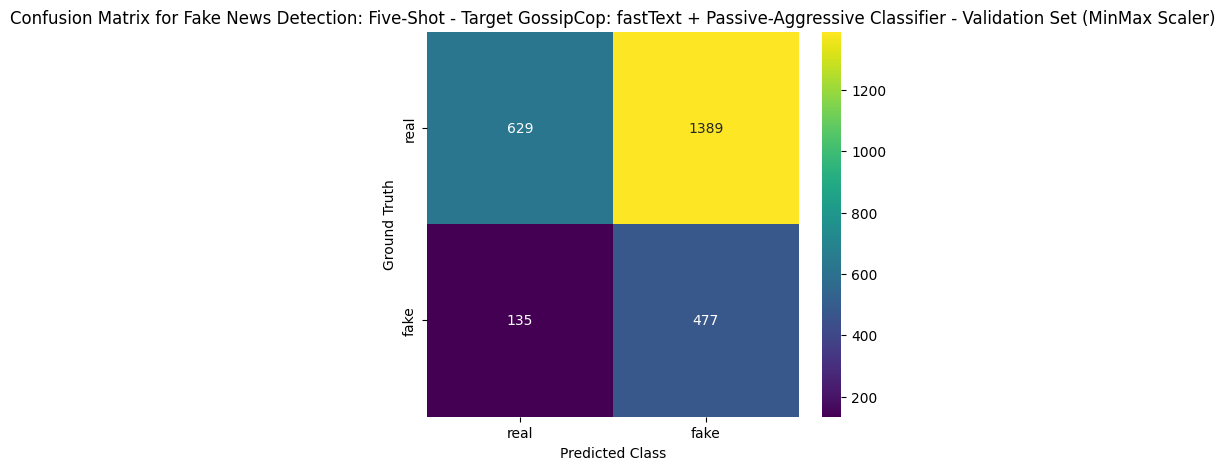

Accuracy: 0.4361
Precision (Macro): 0.5407
Recall (Macro): 0.5486
Macro F1-score: 0.4327

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.34      0.48      2444
           1       0.26      0.76      0.39       755

    accuracy                           0.44      3199
   macro avg       0.54      0.55      0.43      3199
weighted avg       0.69      0.44      0.46      3199



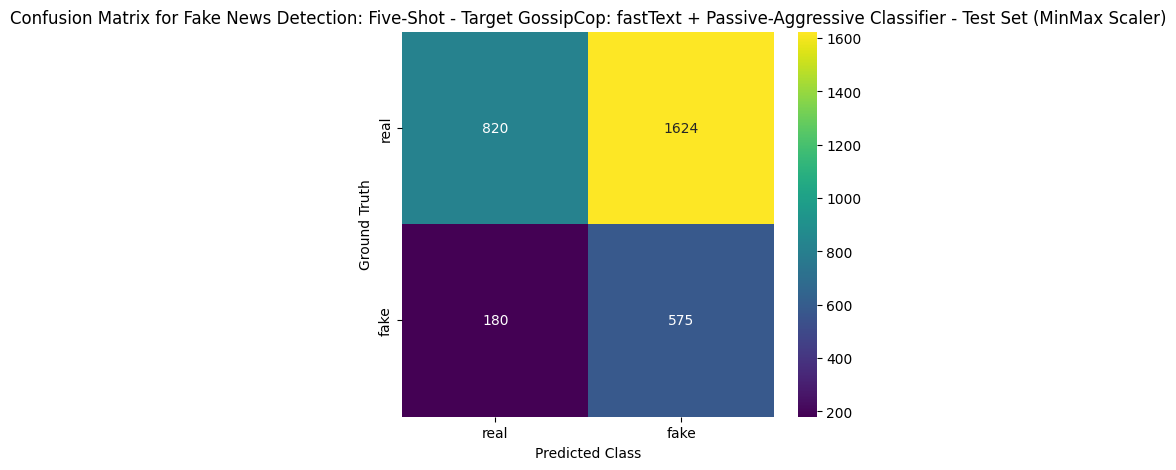

In [61]:
# Training data - returns both the features and a fitted MinMax scaler
five_shot_gc_X_train_minmax, five_shot_gc_minmax_fitted_scaler = combineFeatures(
    five_shot_gc_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
five_shot_gc_X_val_minmax = combineFeatures(five_shot_gc_target_val_df, scaler=five_shot_gc_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
five_shot_gc_X_test_minmax = combineFeatures(five_shot_gc_target_test_df, scaler=five_shot_gc_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
five_shot_gc_train_output_file_minmax = "../../FPData/FastText/five_shot_gc_X_train_embeddings_minmax_scaled.npy"
five_shot_gc_val_output_file_minmax = "../../FPData/FastText/five_shot_gc_X_val_embeddings_minmax_scaled.npy"
five_shot_gc_test_output_file_minmax = "../../FPData/FastText/five_shot_gc_X_test_embeddings_minmax_scaled.npy"
np.save(five_shot_gc_train_output_file_minmax, five_shot_gc_X_train_minmax)
np.save(five_shot_gc_val_output_file_minmax, five_shot_gc_X_val_minmax)
np.save(five_shot_gc_test_output_file_minmax, five_shot_gc_X_test_minmax)

# Trains the model using the minmax scaled data
five_shot_gc_minmax_pac_model, five_shot_gc_minmax_best_c = trainPACModel(five_shot_gc_X_train_minmax, five_shot_gc_y_train)

# Evaluates the model on the validation set
five_shot_gc_y_val_pred_minmax = five_shot_gc_minmax_pac_model.predict(five_shot_gc_X_val_minmax)
five_shot_gc_minmax_val_eval_dict = classifierEvaluation(five_shot_gc_y_val, five_shot_gc_y_val_pred_minmax, 
                                            "Five-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
five_shot_gc_y_test_pred_minmax = five_shot_gc_minmax_pac_model.predict(five_shot_gc_X_test_minmax)
five_shot_gc_minmax_test_eval_dict = classifierEvaluation(five_shot_gc_y_test, five_shot_gc_y_test_pred_minmax,
                                             "Five-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )


## Zero-Shot Evaluation Scenario

### Zero-Shot: WELFake Target

#### StandardScaler




rocessing embeddings...: 100%|███████| 11237/11237 [00:00<00:00, 330391.89it/s]

The best C value was: 100
Accuracy: 0.4267
Precision (Macro): 0.5341
Recall (Macro): 0.5056
Macro F1-score: 0.3342

Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.05      0.09      5463
           1       0.42      0.97      0.58      3862

    accuracy                           0.43      9325
   macro avg       0.53      0.51      0.33      9325
weighted avg       0.55      0.43      0.29      9325



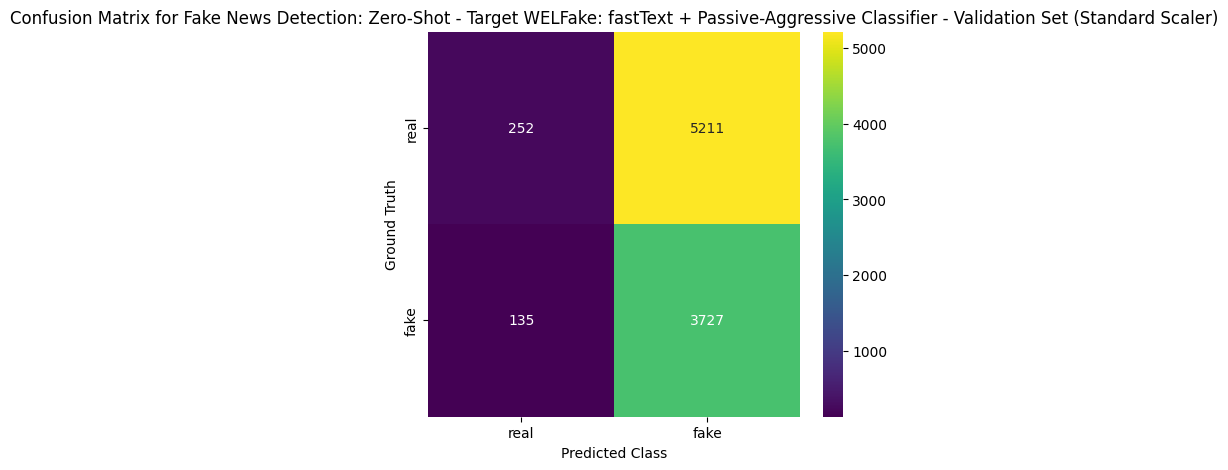

Accuracy: 0.3909
Precision (Macro): 0.5318
Recall (Macro): 0.5042
Macro F1-score: 0.3073

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.04      0.07      6976
           1       0.38      0.97      0.55      4261

    accuracy                           0.39     11237
   macro avg       0.53      0.50      0.31     11237
weighted avg       0.57      0.39      0.25     11237



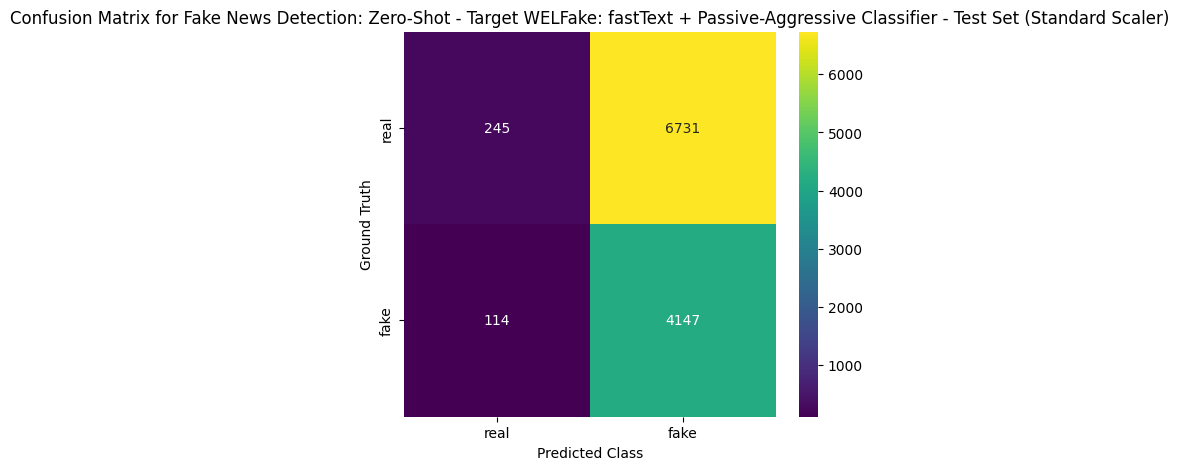

In [24]:
# Training data - returns both the features and a fitted Standard scaler
zero_shot_wf_X_train_std, zero_shot_wf_standard_fitted_scaler = combineFeatures(zero_shot_wf_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
zero_shot_wf_X_val_std = combineFeatures(zero_shot_wf_target_val_df, scaler=zero_shot_wf_standard_fitted_scaler)
# Test data - uses the fitted standard scaler
zero_shot_wf_X_test_std = combineFeatures(zero_shot_wf_target_test_df, scaler=zero_shot_wf_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
zero_shot_wf_train_output_file_std = "../../FPData/FastText/zero_shot_wf_X_train_embeddings_std_scaled.npy"
zero_shot_wf_val_output_file_std = "../../FPData/FastText/zero_shot_wf_X_val_embeddings_std_scaled.npy"
zero_shot_wf_test_output_file_std = "../../FPData/FastText/zero_shot_wf_X_test_embeddings_std_scaled.npy"
np.save(zero_shot_wf_train_output_file_std, zero_shot_wf_X_train_std)
np.save(zero_shot_wf_val_output_file_std, zero_shot_wf_X_val_std)
np.save(zero_shot_wf_test_output_file_std, zero_shot_wf_X_test_std)

# Gets the labels
zero_shot_wf_y_train = zero_shot_wf_target_train_df["label"].values
zero_shot_wf_y_val = zero_shot_wf_target_val_df["label"].values
zero_shot_wf_y_test = zero_shot_wf_target_test_df["label"].values

# Trains the model using the standard scaled data
zero_shot_wf_std_pac_model, zero_shot_wf_std_best_c = trainPACModel(zero_shot_wf_X_train_std, zero_shot_wf_y_train)

# Evaluates the model on the validation set
zero_shot_wf_y_val_pred_std = zero_shot_wf_std_pac_model.predict(zero_shot_wf_X_val_std)
zero_shot_wf_std_val_eval_dict = classifierEvaluation(zero_shot_wf_y_val, zero_shot_wf_y_val_pred_std, 
                                            "Zero-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
zero_shot_wf_y_test_pred_std = zero_shot_wf_std_pac_model.predict(zero_shot_wf_X_test_std)
zero_shot_wf_std_test_eval_dict = classifierEvaluation(zero_shot_wf_y_test, zero_shot_wf_y_test_pred_std, 
                                             "Zero-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")

#### Min-Max Scaler




rocessing embeddings...: 100%|███████| 11237/11237 [00:00<00:00, 331202.17it/s]

The best C value was: 0.1
Accuracy: 0.5454
Precision (Macro): 0.5604
Recall (Macro): 0.5607
Macro F1-score: 0.5454

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.47      0.55      5463
           1       0.47      0.65      0.54      3862

    accuracy                           0.55      9325
   macro avg       0.56      0.56      0.55      9325
weighted avg       0.58      0.55      0.55      9325



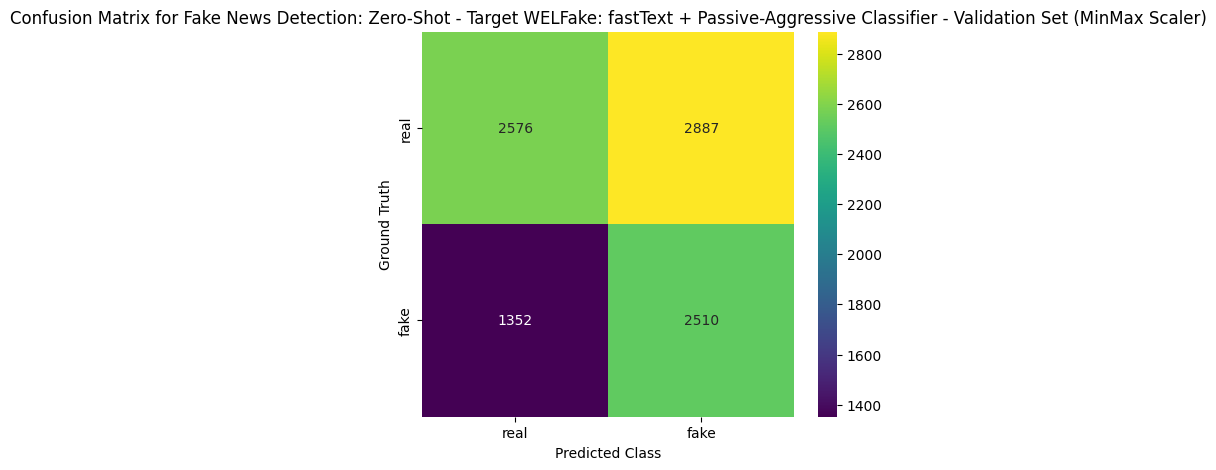

Accuracy: 0.5251
Precision (Macro): 0.5578
Recall (Macro): 0.5578
Macro F1-score: 0.5251

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.42      0.52      6976
           1       0.42      0.69      0.53      4261

    accuracy                           0.53     11237
   macro avg       0.56      0.56      0.53     11237
weighted avg       0.59      0.53      0.53     11237



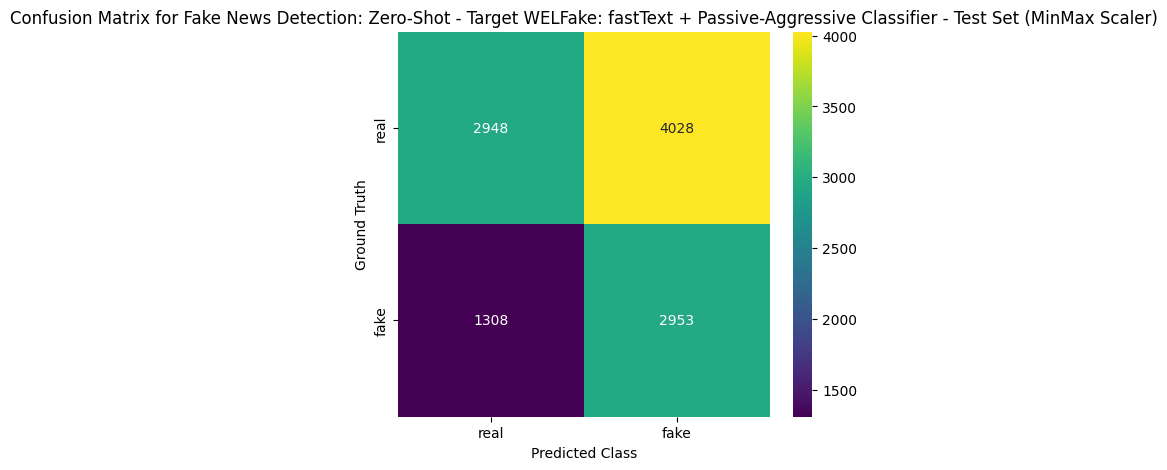

In [25]:
# Training data - returns both the features and a fitted MinMax scaler
zero_shot_wf_X_train_minmax, zero_shot_wf_minmax_fitted_scaler = combineFeatures(
    zero_shot_wf_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
zero_shot_wf_X_val_minmax = combineFeatures(zero_shot_wf_target_val_df, scaler=zero_shot_wf_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
zero_shot_wf_X_test_minmax = combineFeatures(zero_shot_wf_target_test_df, scaler=zero_shot_wf_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
zero_shot_wf_train_output_file_minmax = "../../FPData/FastText/zero_shot_wf_X_train_embeddings_minmax_scaled.npy"
zero_shot_wf_val_output_file_minmax = "../../FPData/FastText/zero_shot_wf_X_val_embeddings_minmax_scaled.npy"
zero_shot_wf_test_output_file_minmax = "../../FPData/FastText/zero_shot_wf_X_test_embeddings_minmax_scaled.npy"
np.save(zero_shot_wf_train_output_file_minmax, zero_shot_wf_X_train_minmax)
np.save(zero_shot_wf_val_output_file_minmax, zero_shot_wf_X_val_minmax)
np.save(zero_shot_wf_test_output_file_minmax, zero_shot_wf_X_test_minmax)

# Trains the model using the minmax scaled data
zero_shot_wf_minmax_pac_model, zero_shot_wf_minmax_best_c = trainPACModel(zero_shot_wf_X_train_minmax, zero_shot_wf_y_train)

# Evaluates the model on the validation set
zero_shot_wf_y_val_pred_minmax = zero_shot_wf_minmax_pac_model.predict(zero_shot_wf_X_val_minmax)
zero_shot_wf_minmax_val_eval_dict = classifierEvaluation(zero_shot_wf_y_val, zero_shot_wf_y_val_pred_minmax, 
                                            "Zero-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
zero_shot_wf_y_test_pred_minmax = zero_shot_wf_minmax_pac_model.predict(zero_shot_wf_X_test_minmax)
zero_shot_wf_minmax_test_eval_dict = classifierEvaluation(zero_shot_wf_y_test, zero_shot_wf_y_test_pred_minmax,
                                             "Zero-Shot - Target WELFake: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )


### Zero-Shot: Constraint Target

#### StandardScaler




rocessing embeddings...: 100%|█████████| 2122/2122 [00:00<00:00, 309823.97it/s]

The best C value was: 0.1
Accuracy: 0.4586
Precision (Macro): 0.4626
Recall (Macro): 0.4673
Macro F1-score: 0.4455

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.29      0.36      1116
           1       0.45      0.64      0.53      1012

    accuracy                           0.46      2128
   macro avg       0.46      0.47      0.45      2128
weighted avg       0.46      0.46      0.44      2128



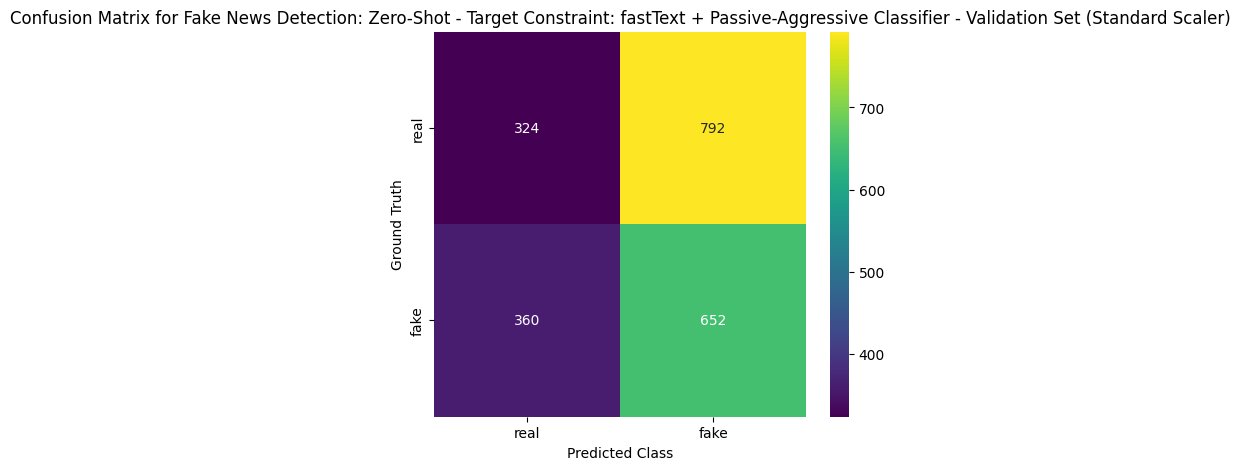

Accuracy: 0.4538
Precision (Macro): 0.4576
Recall (Macro): 0.4619
Macro F1-score: 0.4436

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.30      0.37      1115
           1       0.45      0.62      0.52      1007

    accuracy                           0.45      2122
   macro avg       0.46      0.46      0.44      2122
weighted avg       0.46      0.45      0.44      2122



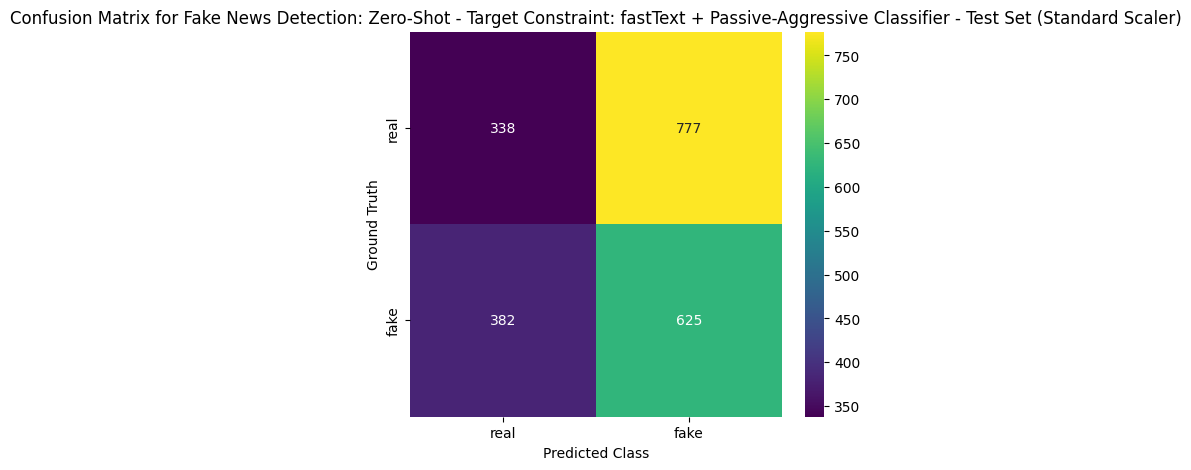

In [26]:
# Training data - returns both the features and a fitted Standard scaler
zero_shot_ct_X_train_std, zero_shot_ct_standard_fitted_scaler = combineFeatures(zero_shot_ct_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
zero_shot_ct_X_val_std = combineFeatures(zero_shot_ct_target_val_df, scaler=zero_shot_ct_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
zero_shot_ct_X_test_std = combineFeatures(zero_shot_ct_target_test_df, scaler=zero_shot_ct_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
zero_shot_ct_train_output_file_std = "../../FPData/FastText/zero_shot_ct_X_train_embeddings_std_scaled.npy"
zero_shot_ct_val_output_file_std = "../../FPData/FastText/zero_shot_ct_X_val_embeddings_std_scaled.npy"
zero_shot_ct_test_output_file_std = "../../FPData/FastText/zero_shot_ct_X_test_embeddings_std_scaled.npy"
np.save(zero_shot_ct_train_output_file_std, zero_shot_ct_X_train_std)
np.save(zero_shot_ct_val_output_file_std, zero_shot_ct_X_val_std)
np.save(zero_shot_ct_test_output_file_std, zero_shot_ct_X_test_std)

# Gets the labels
zero_shot_ct_y_train = zero_shot_ct_target_train_df["label"].values
zero_shot_ct_y_val = zero_shot_ct_target_val_df["label"].values
zero_shot_ct_y_test = zero_shot_ct_target_test_df["label"].values

# Trains the model using the standard scaled data
zero_shot_ct_std_pac_model, zero_shot_ct_std_best_c = trainPACModel(zero_shot_ct_X_train_std, zero_shot_ct_y_train)

# Evaluates the model on the validation set
zero_shot_ct_y_val_pred_std = zero_shot_ct_std_pac_model.predict(zero_shot_ct_X_val_std)
zero_shot_ct_std_val_eval_dict = classifierEvaluation(zero_shot_ct_y_val, zero_shot_ct_y_val_pred_std, 
                                            "Zero-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
zero_shot_ct_y_test_pred_std = zero_shot_ct_std_pac_model.predict(zero_shot_ct_X_test_std)
zero_shot_ct_std_test_eval_dict = classifierEvaluation(zero_shot_ct_y_test, zero_shot_ct_y_test_pred_std, 
                                             "Zero-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")


#### Min-Max Scaler




rocessing embeddings...: 100%|█████████| 2122/2122 [00:00<00:00, 296944.35it/s]

The best C value was: 1
Accuracy: 0.5367
Precision (Macro): 0.5320
Recall (Macro): 0.5274
Macro F1-score: 0.5144

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.72      0.62      1116
           1       0.52      0.34      0.41      1012

    accuracy                           0.54      2128
   macro avg       0.53      0.53      0.51      2128
weighted avg       0.53      0.54      0.52      2128



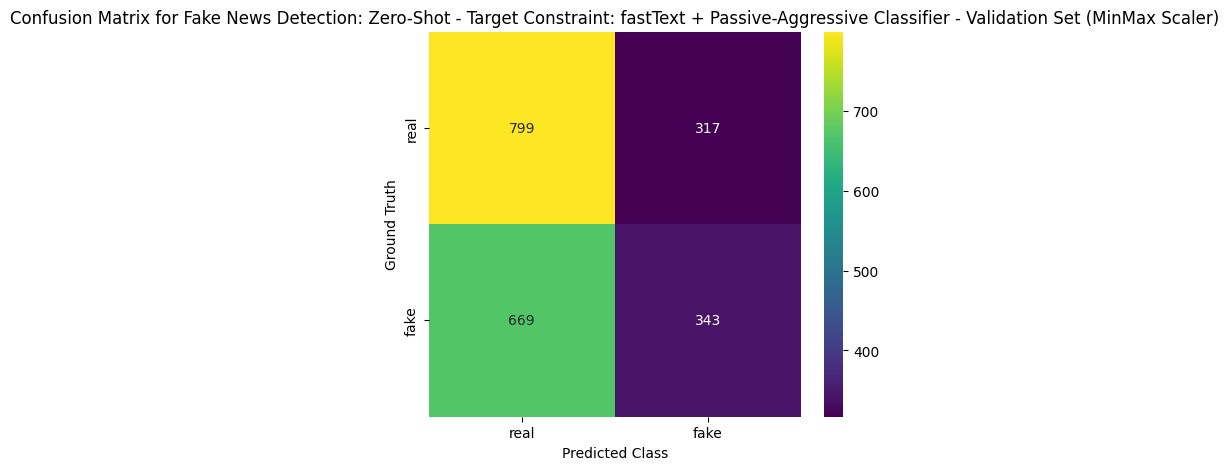

Accuracy: 0.5226
Precision (Macro): 0.5150
Recall (Macro): 0.5127
Macro F1-score: 0.4981

Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1115
           1       0.50      0.32      0.39      1007

    accuracy                           0.52      2122
   macro avg       0.51      0.51      0.50      2122
weighted avg       0.52      0.52      0.50      2122



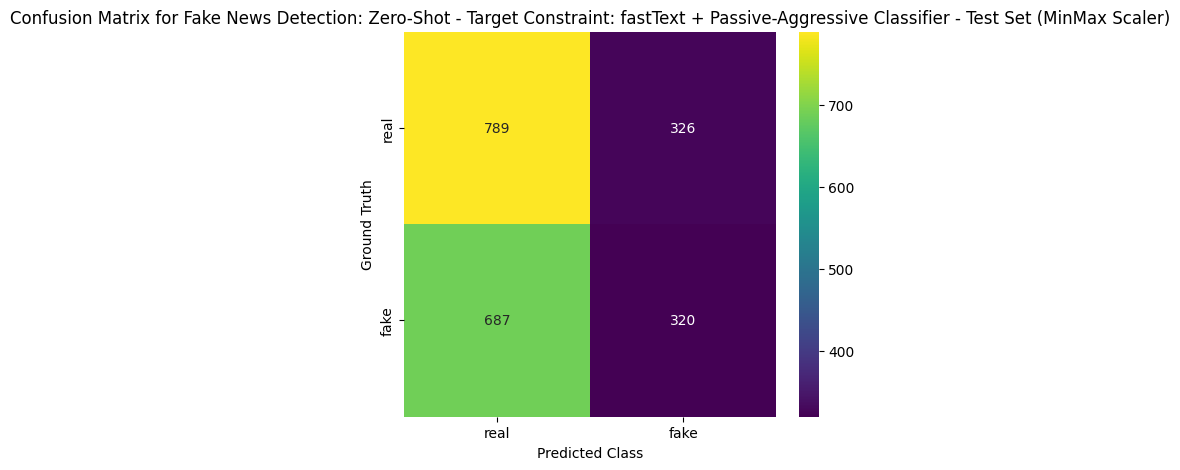

In [27]:
# Training data - returns both the features and a fitted MinMax scaler
zero_shot_ct_X_train_minmax, zero_shot_ct_minmax_fitted_scaler = combineFeatures(
    zero_shot_ct_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
zero_shot_ct_X_val_minmax = combineFeatures(zero_shot_ct_target_val_df, scaler=zero_shot_ct_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
zero_shot_ct_X_test_minmax = combineFeatures(zero_shot_ct_target_test_df, scaler=zero_shot_ct_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
zero_shot_ct_train_output_file_minmax = "../../FPData/FastText/zero_shot_ct_X_train_embeddings_minmax_scaled.npy"
zero_shot_ct_val_output_file_minmax = "../../FPData/FastText/zero_shot_ct_X_val_embeddings_minmax_scaled.npy"
zero_shot_ct_test_output_file_minmax = "../../FPData/FastText/zero_shot_ct_X_test_embeddings_minmax_scaled.npy"
np.save(zero_shot_ct_train_output_file_minmax, zero_shot_ct_X_train_minmax)
np.save(zero_shot_ct_val_output_file_minmax, zero_shot_ct_X_val_minmax)
np.save(zero_shot_ct_test_output_file_minmax, zero_shot_ct_X_test_minmax)

# Trains the model using minmax scaled data
zero_shot_ct_minmax_pac_model, zero_shot_ct_minmax_best_c = trainPACModel(zero_shot_ct_X_train_minmax, zero_shot_ct_y_train)

# Evaluates the model on the validation set
zero_shot_ct_y_val_pred_minmax = zero_shot_ct_minmax_pac_model.predict(zero_shot_ct_X_val_minmax)
zero_shot_ct_minmax_val_eval_dict = classifierEvaluation(zero_shot_ct_y_val, zero_shot_ct_y_val_pred_minmax, 
                                            "Zero-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
zero_shot_ct_y_test_pred_minmax = zero_shot_ct_minmax_pac_model.predict(zero_shot_ct_X_test_minmax)
zero_shot_ct_minmax_test_eval_dict = classifierEvaluation(zero_shot_ct_y_test, zero_shot_ct_y_test_pred_minmax,
                                             "Zero-Shot - Target Constraint: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )


### Zero-Shot: PolitiFact Target

#### StandardScaler




rocessing embeddings...: 100%|███████████| 126/126 [00:00<00:00, 315700.30it/s]

The best C value was: 0.1
Accuracy: 0.6635
Precision (Macro): 0.6964
Recall (Macro): 0.6243
Macro F1-score: 0.6084

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.92      0.76        59
           1       0.75      0.33      0.46        45

    accuracy                           0.66       104
   macro avg       0.70      0.62      0.61       104
weighted avg       0.69      0.66      0.63       104



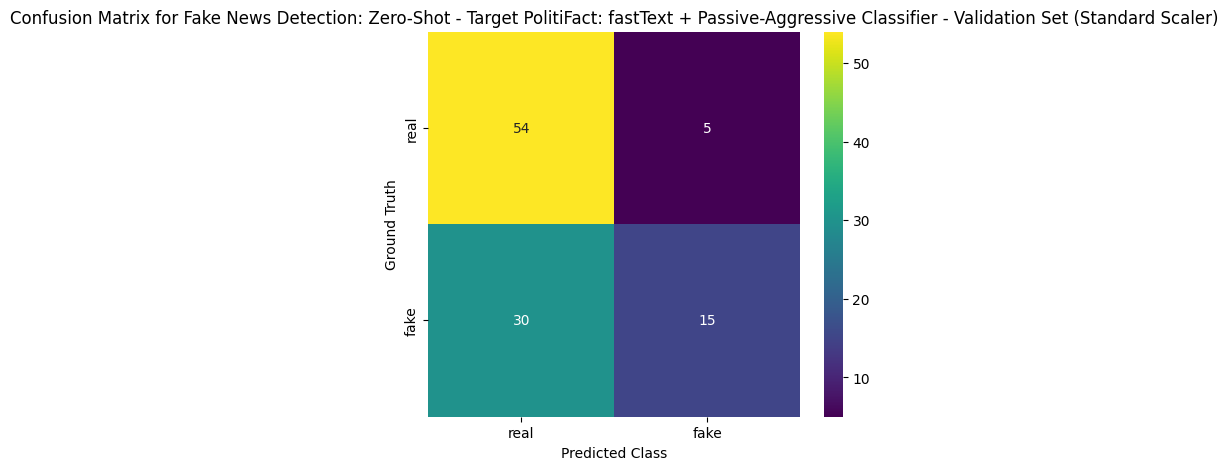

Accuracy: 0.5952
Precision (Macro): 0.6427
Recall (Macro): 0.6037
Macro F1-score: 0.5692

Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.87      0.68        61
           1       0.73      0.34      0.46        65

    accuracy                           0.60       126
   macro avg       0.64      0.60      0.57       126
weighted avg       0.65      0.60      0.57       126



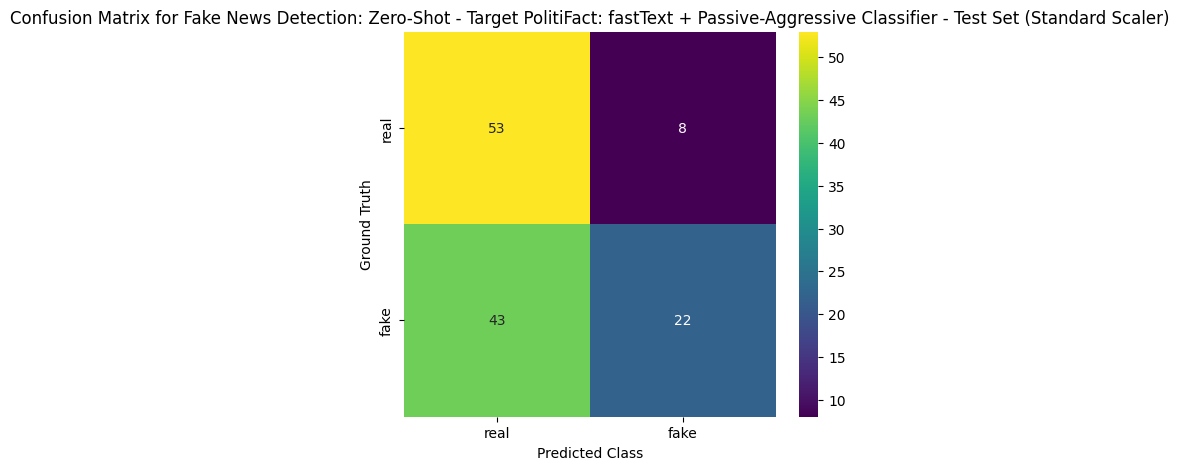

In [41]:
# Training data - returns both the features and a fitted Standard scaler
zero_shot_pf_X_train_std, zero_shot_pf_standard_fitted_scaler = combineFeatures(zero_shot_pf_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
zero_shot_pf_X_val_std = combineFeatures(zero_shot_pf_target_val_df, scaler=zero_shot_pf_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
zero_shot_pf_X_test_std = combineFeatures(zero_shot_pf_target_test_df, scaler=zero_shot_pf_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
zero_shot_pf_train_output_file_std = "../../FPData/FastText/zero_shot_pf_X_train_embeddings_std_scaled.npy"
zero_shot_pf_val_output_file_std = "../../FPData/FastText/zero_shot_pf_X_val_embeddings_std_scaled.npy"
zero_shot_pf_test_output_file_std = "../../FPData/FastText/zero_shot_pf_X_test_embeddings_std_scaled.npy"
np.save(zero_shot_pf_train_output_file_std, zero_shot_pf_X_train_std)
np.save(zero_shot_pf_val_output_file_std, zero_shot_pf_X_val_std)
np.save(zero_shot_pf_test_output_file_std, zero_shot_pf_X_test_std)

# Gets the labels
zero_shot_pf_y_train = zero_shot_pf_target_train_df["label"].values
zero_shot_pf_y_val = zero_shot_pf_target_val_df["label"].values
zero_shot_pf_y_test = zero_shot_pf_target_test_df["label"].values

# Trains the model using the standard scaled data
zero_shot_pf_std_pac_model, zero_shot_pf_std_best_c = trainPACModel(zero_shot_pf_X_train_std, zero_shot_pf_y_train)

# Evaluates the model on the validation set
zero_shot_pf_y_val_pred_std = zero_shot_pf_std_pac_model.predict(zero_shot_pf_X_val_std)
zero_shot_pf_std_val_eval_dict = classifierEvaluation(zero_shot_pf_y_val, zero_shot_pf_y_val_pred_std, 
                                            "Zero-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
zero_shot_pf_y_test_pred_std = zero_shot_pf_std_pac_model.predict(zero_shot_pf_X_test_std)
zero_shot_pf_std_test_eval_dict = classifierEvaluation(zero_shot_pf_y_test, zero_shot_pf_y_test_pred_std, 
                                             "Zero-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")

#### Min-Max Scaler




rocessing embeddings...: 100%|███████████| 126/126 [00:00<00:00, 232095.87it/s]

The best C value was: 0.1
Accuracy: 0.7019
Precision (Macro): 0.6969
Recall (Macro): 0.6898
Macro F1-score: 0.6916

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        59
           1       0.68      0.60      0.64        45

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104



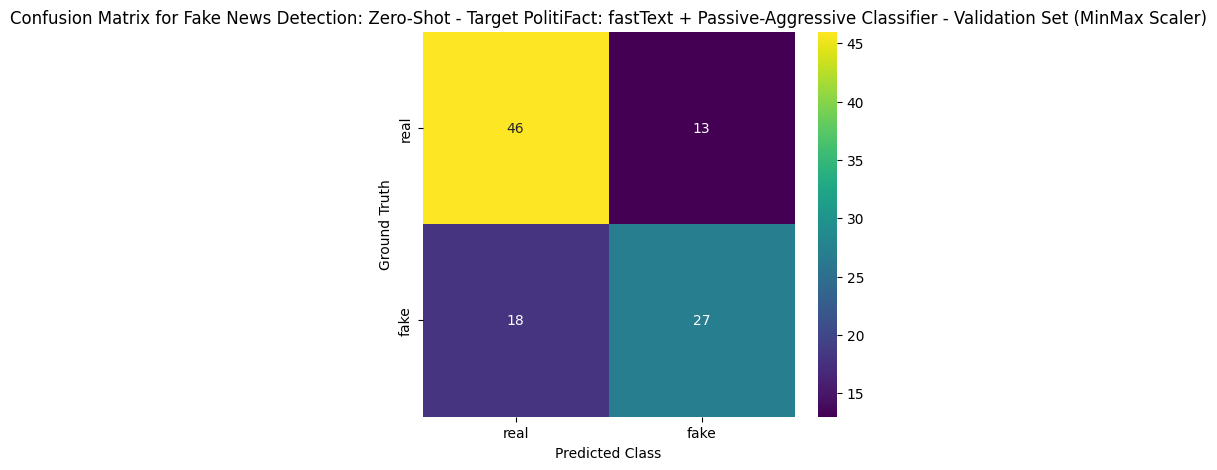

Accuracy: 0.7143
Precision (Macro): 0.7147
Recall (Macro): 0.7130
Macro F1-score: 0.7131

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.67      0.69        61
           1       0.71      0.75      0.73        65

    accuracy                           0.71       126
   macro avg       0.71      0.71      0.71       126
weighted avg       0.71      0.71      0.71       126



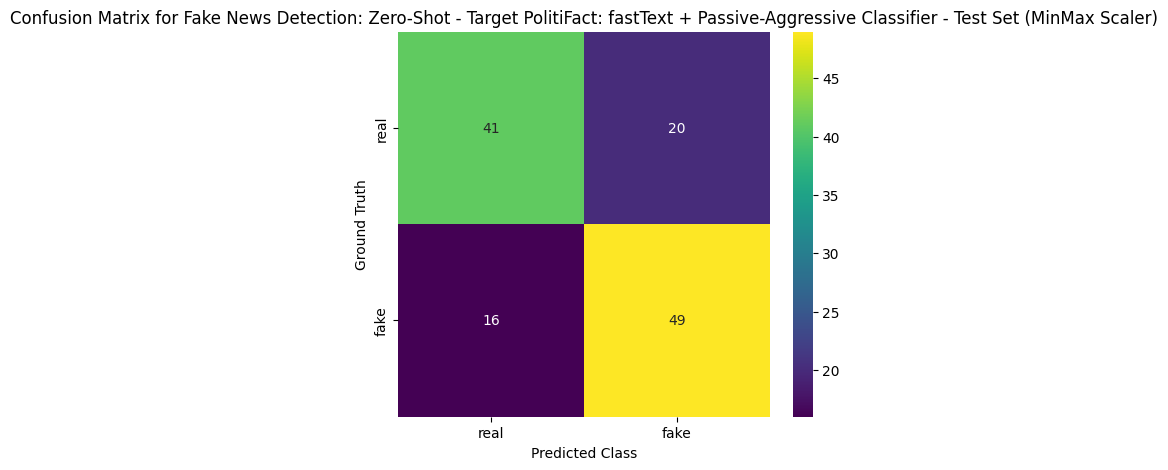

In [42]:
# Training data - returns both the features and a fitted MinMax scaler
zero_shot_pf_X_train_minmax, zero_shot_pf_minmax_fitted_scaler = combineFeatures(
    zero_shot_pf_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
zero_shot_pf_X_val_minmax = combineFeatures(zero_shot_pf_target_val_df, scaler=zero_shot_pf_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
zero_shot_pf_X_test_minmax = combineFeatures(zero_shot_pf_target_test_df, scaler=zero_shot_pf_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
zero_shot_pf_train_output_file_minmax = "../../FPData/FastText/zero_shot_pf_X_train_embeddings_minmax_scaled.npy"
zero_shot_pf_val_output_file_minmax = "../../FPData/FastText/zero_shot_pf_X_val_embeddings_minmax_scaled.npy"
zero_shot_pf_test_output_file_minmax = "../../FPData/FastText/zero_shot_pf_X_test_embeddings_minmax_scaled.npy"
np.save(zero_shot_pf_train_output_file_minmax, zero_shot_pf_X_train_minmax)
np.save(zero_shot_pf_val_output_file_minmax, zero_shot_pf_X_val_minmax)
np.save(zero_shot_pf_test_output_file_minmax, zero_shot_pf_X_test_minmax)

# Trains the model using the minmax scaled data
zero_shot_pf_minmax_pac_model, zero_shot_pf_minmax_best_c = trainPACModel(zero_shot_pf_X_train_minmax, zero_shot_pf_y_train)

# Evaluates the model on the validation set
zero_shot_pf_y_val_pred_minmax = zero_shot_pf_minmax_pac_model.predict(zero_shot_pf_X_val_minmax)
zero_shot_pf_minmax_val_eval_dict = classifierEvaluation(zero_shot_pf_y_val, zero_shot_pf_y_val_pred_minmax, 
                                            "Zero-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
zero_shot_pf_y_test_pred_minmax = zero_shot_pf_minmax_pac_model.predict(zero_shot_pf_X_test_minmax)
zero_shot_pf_minmax_test_eval_dict = classifierEvaluation(zero_shot_pf_y_test, zero_shot_pf_y_test_pred_minmax,
                                             "Zero-Shot - Target PolitiFact: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )

### Zero-Shot: GossipCop Target

#### StandardScaler




rocessing embeddings...: 100%|█████████| 3199/3199 [00:00<00:00, 322996.04it/s]

The best C value was: 0.1
Accuracy: 0.4513
Precision (Macro): 0.5419
Recall (Macro): 0.5525
Macro F1-score: 0.4451

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.36      0.50      2018
           1       0.26      0.74      0.39       612

    accuracy                           0.45      2630
   macro avg       0.54      0.55      0.45      2630
weighted avg       0.69      0.45      0.48      2630



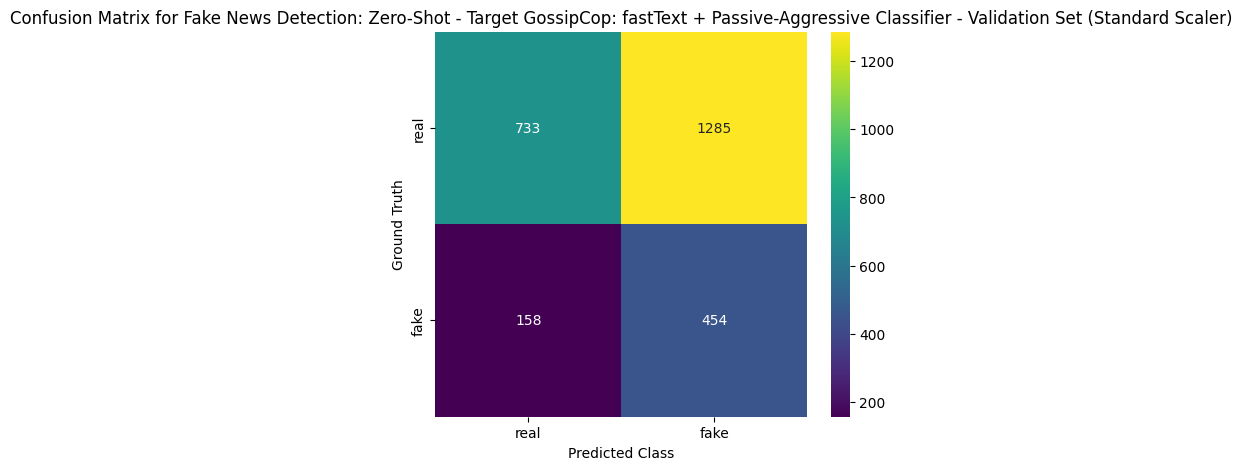

Accuracy: 0.4670
Precision (Macro): 0.5391
Recall (Macro): 0.5505
Macro F1-score: 0.4575

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.39      0.53      2444
           1       0.26      0.71      0.39       755

    accuracy                           0.47      3199
   macro avg       0.54      0.55      0.46      3199
weighted avg       0.68      0.47      0.50      3199



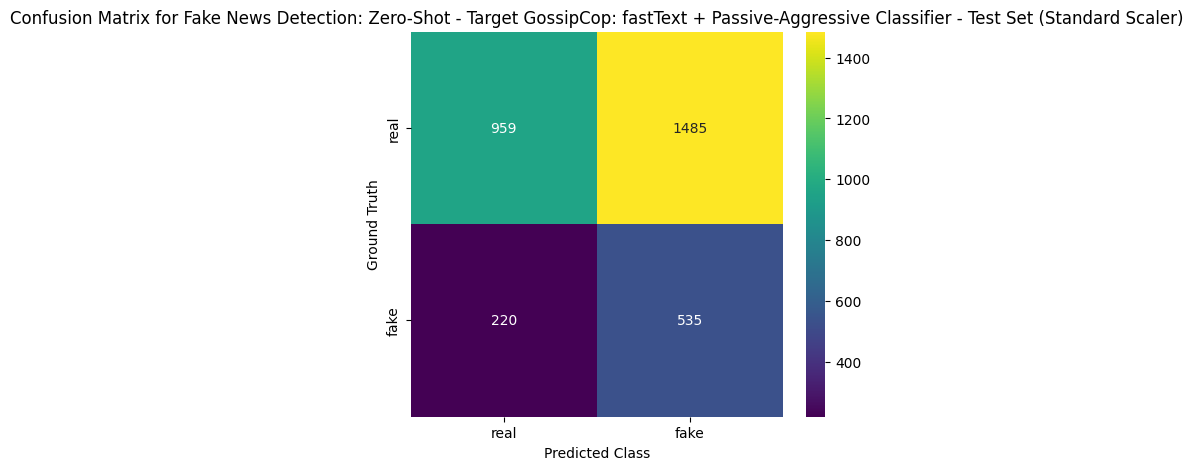

In [30]:
# Training data - returns both the features and a fitted Standard scaler
zero_shot_gc_X_train_std, zero_shot_gc_standard_fitted_scaler = combineFeatures(zero_shot_gc_target_train_df, scaler=None)

# Validation data - uses the fitted standard scaler 
zero_shot_gc_X_val_std = combineFeatures(zero_shot_gc_target_val_df, scaler=zero_shot_gc_standard_fitted_scaler)

# Test data - uses the fitted standard scaler
zero_shot_gc_X_test_std = combineFeatures(zero_shot_gc_target_test_df, scaler=zero_shot_gc_standard_fitted_scaler) 

# Saves the standard-scaled matrices to disk as .npy file to save time later 
zero_shot_gc_train_output_file_std = "../../FPData/FastText/zero_shot_gc_X_train_embeddings_std_scaled.npy"
zero_shot_gc_val_output_file_std = "../../FPData/FastText/zero_shot_gc_X_val_embeddings_std_scaled.npy"
zero_shot_gc_test_output_file_std = "../../FPData/FastText/zero_shot_gc_X_test_embeddings_std_scaled.npy"
np.save(zero_shot_gc_train_output_file_std, zero_shot_gc_X_train_std)
np.save(zero_shot_gc_val_output_file_std, zero_shot_gc_X_val_std)
np.save(zero_shot_gc_test_output_file_std, zero_shot_gc_X_test_std)

# Gets the labels
zero_shot_gc_y_train = zero_shot_gc_target_train_df["label"].values
zero_shot_gc_y_val = zero_shot_gc_target_val_df["label"].values
zero_shot_gc_y_test = zero_shot_gc_target_test_df["label"].values

# Trains the model using the standard scaled data
zero_shot_gc_std_pac_model, zero_shot_gc_std_best_c = trainPACModel(zero_shot_gc_X_train_std, zero_shot_gc_y_train)

# Evaluates the model on the validation set
zero_shot_gc_y_val_pred_std = zero_shot_gc_std_pac_model.predict(zero_shot_gc_X_val_std)
zero_shot_gc_std_val_eval_dict = classifierEvaluation(zero_shot_gc_y_val, zero_shot_gc_y_val_pred_std, 
                                            "Zero-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Validation Set (Standard Scaler)")

# Evaluates the model on the test set
zero_shot_gc_y_test_pred_std = zero_shot_gc_std_pac_model.predict(zero_shot_gc_X_test_std)
zero_shot_gc_std_test_eval_dict = classifierEvaluation(zero_shot_gc_y_test, zero_shot_gc_y_test_pred_std, 
                                             "Zero-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Test Set (Standard Scaler)")

#### Min-Max Scaler




rocessing embeddings...: 100%|█████████| 3199/3199 [00:00<00:00, 316639.02it/s]

The best C value was: 0.1
Accuracy: 0.4141
Precision (Macro): 0.5363
Recall (Macro): 0.5413
Macro F1-score: 0.4125

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.30      0.44      2018
           1       0.25      0.78      0.38       612

    accuracy                           0.41      2630
   macro avg       0.54      0.54      0.41      2630
weighted avg       0.69      0.41      0.43      2630



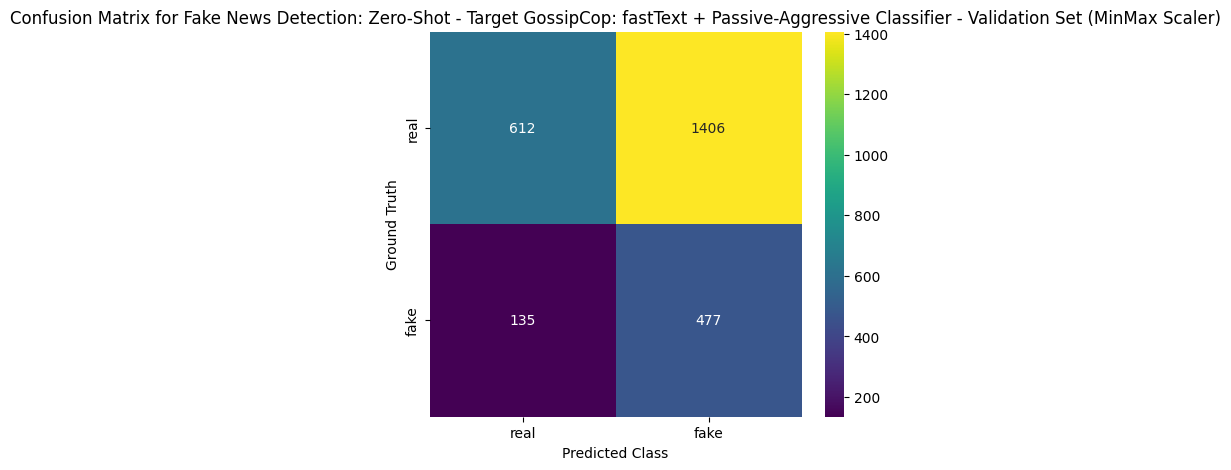

Accuracy: 0.4342
Precision (Macro): 0.5369
Recall (Macro): 0.5441
Macro F1-score: 0.4306

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.34      0.48      2444
           1       0.26      0.75      0.39       755

    accuracy                           0.43      3199
   macro avg       0.54      0.54      0.43      3199
weighted avg       0.68      0.43      0.45      3199



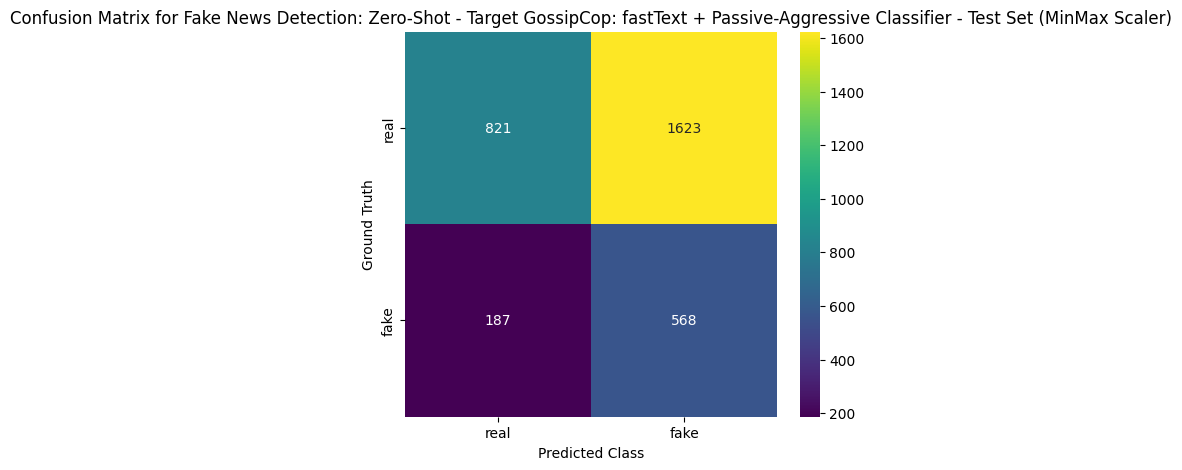

In [31]:
# Training data - returns both the features and a fitted MinMax scaler
zero_shot_gc_X_train_minmax, zero_shot_gc_minmax_fitted_scaler = combineFeatures(
    zero_shot_gc_target_train_df, scaler=None, use_min_max_scaler=True)

# Validation data - uses the fitted minmax scaler 
zero_shot_gc_X_val_minmax = combineFeatures(zero_shot_gc_target_val_df, scaler=zero_shot_gc_minmax_fitted_scaler)

# Test data - uses the fitted minmax scaler
zero_shot_gc_X_test_minmax = combineFeatures(zero_shot_gc_target_test_df, scaler=zero_shot_gc_minmax_fitted_scaler)

# Saves the minmax-scaled matrices to disk as .npy file to save time later 
zero_shot_gc_train_output_file_minmax = "../../FPData/FastText/zero_shot_gc_X_train_embeddings_minmax_scaled.npy"
zero_shot_gc_val_output_file_minmax = "../../FPData/FastText/zero_shot_gc_X_val_embeddings_minmax_scaled.npy"
zero_shot_gc_test_output_file_minmax = "../../FPData/FastText/zero_shot_gc_X_test_embeddings_minmax_scaled.npy"
np.save(zero_shot_gc_train_output_file_minmax, zero_shot_gc_X_train_minmax)
np.save(zero_shot_gc_val_output_file_minmax, zero_shot_gc_X_val_minmax)
np.save(zero_shot_gc_test_output_file_minmax, zero_shot_gc_X_test_minmax)

# Trains the model using minmax scaled data
zero_shot_gc_minmax_pac_model, zero_shot_gc_minmax_best_c = trainPACModel(zero_shot_gc_X_train_minmax, zero_shot_gc_y_train)

# Evaluates the model on the validation set
zero_shot_gc_y_val_pred_minmax = zero_shot_gc_minmax_pac_model.predict(zero_shot_gc_X_val_minmax)
zero_shot_gc_minmax_val_eval_dict = classifierEvaluation(zero_shot_gc_y_val, zero_shot_gc_y_val_pred_minmax, 
                                            "Zero-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Validation Set (MinMax Scaler)"
                                           )

# Evaluates the model on the test set
zero_shot_gc_y_test_pred_minmax = zero_shot_gc_minmax_pac_model.predict(zero_shot_gc_X_test_minmax)
zero_shot_gc_minmax_test_eval_dict = classifierEvaluation(zero_shot_gc_y_test, zero_shot_gc_y_test_pred_minmax,
                                             "Zero-Shot - Target GossipCop: fastText + Passive-Aggressive Classifier - Test Set (MinMax Scaler)"
                                            )

## Results Tables

### Best Results: Full-Scale Evaluation Scenario Table

| Dataset Name + Scaler Type                                | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score | Best Scaler   |
|-----------------------------------------------------------|----------|-------------------|---------------|---------------|---------------|
| WELFake Validation - Standard Scaler                      | 0.9823   | 0.9812            | 0.9825        | 0.9818        | Standard Scaler |
| WELFake Test - Standard Scaler                            | 0.9822   | 0.9803            | 0.9820        | 0.9811        | Standard Scaler |
| Fakeddit Validation - Standard Scaler                     | 0.8768   | 0.8754            | 0.8744        | 0.8749        | Standard Scaler |
| Fakeddit Test - Standard Scaler                           | 0.8771   | 0.8756            | 0.8746        | 0.8750        | Standard Scaler |
| Constraint Validation - Standard Scaler                   | 0.9441   | 0.9443            | 0.9436        | 0.9439        | Standard Scaler |
| Constraint Test - MinMax Scaler                           | 0.9439   | 0.9441            | 0.9434        | 0.9437        | MinMax Scaler  |
| PolitiFact Validation - MinMax Scaler                     | 0.8942   | 0.8974            | 0.9041        | 0.8940        | MinMax Scaler  |
| PolitiFact Test - Standard Scaler                         | 0.8968   | 0.9006            | 0.8985        | 0.8968        | Standard Scaler |
| GossipCop Validation - MinMax Scaler                      | 0.8502   | 0.8089            | 0.7419        | 0.7663        | MinMax Scaler  |
| GossipCop Test - MinMax Scaler                            | 0.8446   | 0.7975            | 0.7436        | 0.7643        | MinMax Scaler  |
| All-Four Combined Validation - Standard Scaler            | 0.9321   | 0.9288            | 0.9285        | 0.9286        | Standard Scaler |
| All-Four Combined Test - Standard Scaler                  | 0.9323   | 0.9270            | 0.9268        | 0.9269        | Standard Scaler |


### Best Results: Five-Shot Evaluation Scenario Table

| Dataset Name + Scaler Type                                      | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score | Best Scaler   |
|-----------------------------------------------------------------|----------|-------------------|---------------|---------------|---------------|
| Five-Shot WELFake Target Validation - Standard Scaler           | 0.6079   | 0.5936            | 0.5918        | 0.5923        | Standard Scaler |
| Five-Shot WELFake Target Test - Standard Scaler                 | 0.5906   | 0.5727            | 0.5751        | 0.5730        | Standard Scaler |
| Five-Shot Constraint Target Validation - MinMax Scaler          | 0.4873   | 0.4960            | 0.4966        | 0.4730        | MinMax Scaler  |
| Five-Shot Constraint Target Test - MinMax Scaler                | 0.4609   | 0.4656            | 0.4699        | 0.4480        | MinMax Scaler  |
| Five-Shot PolitiFact Target Validation - Standard Scaler       | 0.7019   | 0.7083            | 0.7109        | 0.7017        | Standard Scaler |
| Five-Shot PolitiFact Target Test - MinMax Scaler                | 0.7143   | 0.7147            | 0.7130        | 0.7131        | MinMax Scaler  |
| Five-Shot GossipCop Target Validation - MinMax Scaler          | 0.4205   | 0.5395            | 0.5456        | 0.4186        | MinMax Scaler  |
| Five-Shot GossipCop Target Test - MinMax Scaler                | 0.4361   | 0.5407            | 0.5486        | 0.4327        | MinMax Scaler  |


### Best Results: Zero-Shot Evaluation Scenario Table

| Dataset Name + Scaler Type                                      | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score | Best Scaler   |
|-----------------------------------------------------------------|----------|-------------------|---------------|---------------|---------------|
| Zero-Shot WELFake Target Validation - MinMax Scaler             | 0.5454   | 0.5604            | 0.5607        | 0.5454        | MinMax Scaler |
| Zero-Shot WELFake Target Test - MinMax Scaler                   | 0.5251   | 0.5578            | 0.5578        | 0.5251        | MinMax Scaler |
| Zero-Shot Constraint Target Validation - MinMax Scaler          | 0.5367   | 0.5320            | 0.5274        | 0.5144        | MinMax Scaler |
| Zero-Shot Constraint Target Test - MinMax Scaler                | 0.5226   | 0.5150            | 0.5127        | 0.4981        | MinMax Scaler |
| Zero-Shot PolitiFact Target Validation - MinMax Scaler         | 0.7019   | 0.6969            | 0.6898        | 0.6916        | MinMax Scaler |
| Zero-Shot PolitiFact Target Test - MinMax Scaler                | 0.7143   | 0.7147            | 0.7130        | 0.7131        | MinMax Scaler |
| Zero-Shot GossipCop Target Validation - Standard Scaler        | 0.4513   | 0.5419            | 0.5525        | 0.4451        | Standard Scaler |
| Zero-Shot GossipCop Target Test - Standard Scaler              | 0.4670   | 0.5391            | 0.5505        | 0.4575        | Standard Scaler |
